In [69]:
# ============================================================
# Cell 1 — Import Environment, Libraries, and Dataset
# ============================================================
# Purpose:
# - Set up the analysis environment (import pandas, numpy, matplotlib, seaborn).
# - Apply a consistent plotting style for all visuals.
# - Load the prepared master dataset from local storage.
# - Restrict analysis window to 2002–2023 (historical baseline).
# - Apply robust filters:
#     • HGV: keep "Average laden" only (one per year).
#     • Vans: keep "Average (up to 3.5 tonnes)" only (fuel-specific rows summed later).
# - Sanity checks ensure no missing years and no leakage of non-road data.
# - Create `df_road` as the clean, canonical subset for all downstream work.
# ============================================================


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn-v0_8')
sns.set_palette('deep')
plt.rcParams['figure.figsize'] = (12, 6)

# --- load master file ---
FILE_PATH = "C:/Users/User/OneDrive - University of Exeter/PostGradute/Business Project/Report/uk-freight-transport-ghg-analysis/data/3. final_master_dataset_with_divided variable.csv" 
df_raw = pd.read_csv(FILE_PATH)

# --- restrict to 2002–2023 (historical window I’ll use everywhere) ---
df = df_raw[(df_raw['Year'] >= 2002) & (df_raw['Year'] <= 2023)].copy()

# --- canonical, robust filters for road-only data ---
mask_hgv_avg = (
    (df['Vehicle Type'] == 'All HGVs') &
    (df['Fuel_Laden Type'].str.lower() == 'average laden')
)

# vans average subtype (robust to capitalization/spacing)
mask_vans_avg = (
    (df['Vehicle Type'] == 'Vans') &
    (
        df['Vehicle Sub Type'].str.contains('average', case=False, na=False) &
        df['Vehicle Sub Type'].str.contains('3.5', na=False)  # "up to 3.5 tonnes"
    )
)

df_road = df[mask_hgv_avg | mask_vans_avg].copy()

# ---- sanity guards so I don't double-count or miss data ----
# HGV must have exactly one "Average laden" record per year
hgv_year_counts = df[mask_hgv_avg].groupby('Year').size()
assert (hgv_year_counts > 0).all(), "Missing HGV 'Average laden' for some years."

# Vans Average(≤3.5t) should exist for each year (may be split by fuel; I will sum)
vans_year_counts = df[mask_vans_avg].groupby('Year').size()
assert (vans_year_counts > 0).all(), "Missing Vans 'Average (up to 3.5 tonnes)' rows for some years."

# no ships/other leaking into road-only dataframe
assert (df_road['Vehicle Type'].isin(['All HGVs','Vans']).all()), "Non-road rows leaked into df_road."

print("Loaded:", FILE_PATH)
print("df_raw shape:", df_raw.shape, "| df (2002–2023):", df.shape, "| df_road (clean road-only):", df_road.shape)
display(df_road.head())


Loaded: C:/Users/User/OneDrive - University of Exeter/PostGradute/Business Project/Report/uk-freight-transport-ghg-analysis/data/3. final_master_dataset_with_divided variable.csv
df_raw shape: (324, 12) | df (2002–2023): (324, 12) | df_road (clean road-only): (132, 12)


,Year,Vehicle Type,Vehicle Sub Type,Fuel_Laden Type,Emission Factor (kgCO2e/tonne.km),Load_Ratio,Emissions (ktCO2e),Fuel Energy (MJ),Congestion_Index,Dynamic_EF,Estimated Activity (tonne.km),Energy Intensity (MJ/tonne.km)
2,2014,All HGVs,All HGVs,Average laden,0.12320,0.75,16755.0,1.820000e+11,1,0.12320,1.360000e+11,1.34
5,2015,All HGVs,All HGVs,Average laden,0.11364,0.75,15888.0,1.860000e+11,1,0.11364,1.400000e+11,1.33
8,2016,All HGVs,All HGVs,Average laden,0.11430,0.75,17380.0,2.010000e+11,1,0.11430,1.520000e+11,1.32
11,2017,All HGVs,All HGVs,Average laden,0.10559,0.75,16329.0,2.040000e+11,1,0.10559,1.550000e+11,1.31
14,2018,All HGVs,All HGVs,Average laden,0.11360,0.75,17772.0,2.050000e+11,1,0.11360,1.570000e+11,1.31


[Check] Mean inflation if you summed ALL laden + ALL vans (WRONG): 154,423 ktCO2e/yr


,Correct (HGV Avg + Vans Avg),Wrong (HGV all laden + Vans all)
Year,,
2002,128711.3,163047.6
2003,132205.2,166925.2
2004,135677.0,170732.0
2005,140284.0,175262.0
2006,143671.5,178407.5


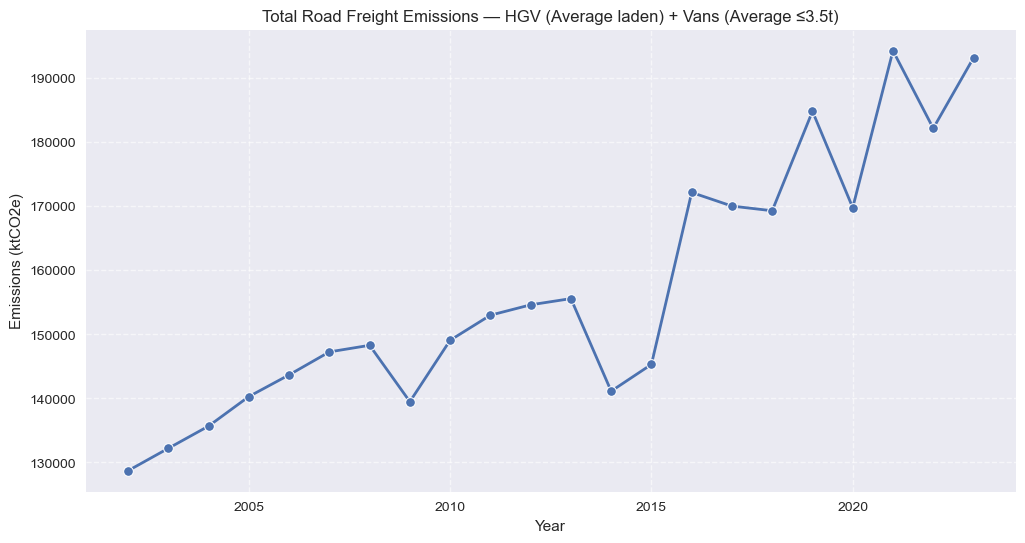

,Year,Emissions (ktCO2e)
0,2002,128711.3
1,2003,132205.2
2,2004,135677.0
3,2005,140284.0
4,2006,143671.5
5,2007,147259.5
6,2008,148287.1
7,2009,139489.2
8,2010,149074.9
9,2011,152985.8


In [70]:
# ============================================================
# Cell 2 — Total Road Freight Emissions (clean) + plot
# ============================================================
# Purpose:
# - Build a consistent time series (2002–2023) of total road freight emissions.
# - Use only:
#     • HGV "Average laden"
#     • Vans "Average (up to 3.5 tonnes)"
# - Combine these into a single yearly total (`road_total_y`).
# - Run a sanity check by comparing with the WRONG aggregation
#   (all laden types + all vans) to show the inflation effect.
# - Plot the clean series to confirm stable trend with no artificial spikes.
# - Save the historical emissions series (`EMIS_ROAD_hist`) for later modelling.
# ============================================================


# years I will use everywhere
years_hist = np.arange(2002, 2024)

# --- build clean yearly series ---
hgv_avg_y = (df.loc[mask_hgv_avg]
               .groupby('Year')['Emissions (ktCO2e)']
               .sum()
               .reindex(years_hist))

vans_avg_y = (df.loc[mask_vans_avg]
                .groupby('Year')['Emissions (ktCO2e)']
                .sum()
                .reindex(years_hist))

road_total_y = hgv_avg_y.add(vans_avg_y, fill_value=0)

total_road_emissions = (road_total_y
                        .reset_index()
                        .rename(columns={'index':'Year',
                                         0:'Emissions (ktCO2e)'}))
total_road_emissions.columns = ['Year', 'Emissions (ktCO2e)']

# --- sanity check against the WRONG aggregation ---
hgv_wrong_y  = (df[df['Vehicle Type']=='All HGVs']
                .groupby('Year')['Emissions (ktCO2e)'].sum()
                .reindex(years_hist))
vans_wrong_y = (df[df['Vehicle Type']=='Vans']
                .groupby('Year')['Emissions (ktCO2e)'].sum()
                .reindex(years_hist))
wrong_total_y = hgv_wrong_y.add(vans_wrong_y, fill_value=0)

inflate_mean = (wrong_total_y - road_total_y).mean()
print(f"[Check] Mean inflation if you summed ALL laden + ALL vans (WRONG): {inflate_mean:,.0f} ktCO2e/yr")
display(pd.DataFrame({
    'Correct (HGV Avg + Vans Avg)': road_total_y,
    'Wrong (HGV all laden + Vans all)': wrong_total_y
}).head())

# --- plot (no spike expected now) ---
plt.figure(figsize=(12,6))
sns.lineplot(data=total_road_emissions, x='Year', y='Emissions (ktCO2e)', marker='o', linewidth=2)
plt.title("Total Road Freight Emissions — HGV (Average laden) + Vans (Average ≤3.5t)")
plt.xlabel("Year"); plt.ylabel("Emissions (ktCO2e)")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# Save clean historical series for later modelling cells
EMIS_ROAD_hist = road_total_y.astype(float)   # pd.Series indexed by Year (2002–2023)

display(total_road_emissions.head(10))


C:\Users\User\AppData\Local\Temp\ipykernel_43064\2960966876.py:23: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(weighted_avg_ei)


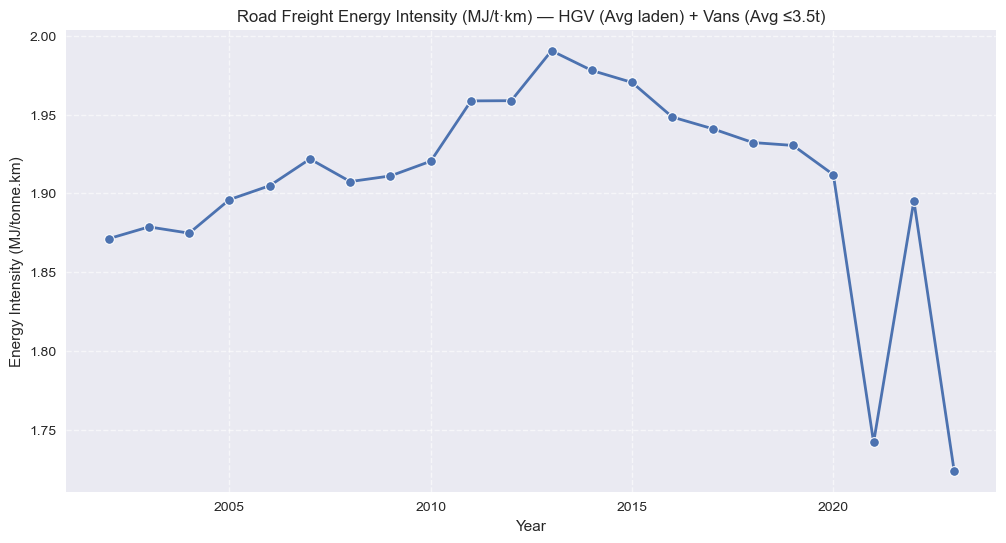

,Year,Energy_Intensity (MJ/tonne.km)
0,2002,1.871178
1,2003,1.878682
2,2004,1.874688
3,2005,1.895990
4,2006,1.904836
5,2007,1.921803
6,2008,1.907452
7,2009,1.911037
8,2010,1.920394
9,2011,1.958679


In [71]:
# ============================================================
# Cell 3 — Energy Intensity for Road Freight (weighted) + plot
# ============================================================
# Purpose:
# - Calculate road freight energy intensity (MJ/t·km) for 2002–2023.
# - Use only HGV "Average laden" and Vans "Average ≤3.5t" from df_road.
# - Apply activity-weighted average (tonne.km) to avoid bias from category counts.
# - Validate results (all finite and positive).
# - Plot yearly energy intensity to confirm historical trend.
# - Save weighted EI series (`EI_ROAD_hist`) for later modelling and scenarios.
# ============================================================


# Helper for weighted average
def weighted_avg_ei(g):
    w = (g['Energy Intensity (MJ/tonne.km)'] * g['Estimated Activity (tonne.km)']).sum()
    d = g['Estimated Activity (tonne.km)'].sum()
    return np.nan if d == 0 else w / d

# Weighted EI for total road freight (HGV avg + Vans avg)
EI_ROAD_hist = (df_road
                .groupby('Year')
                .apply(weighted_avg_ei)
                .reindex(years_hist)
                .astype(float))

# Sanity: values should be finite and positive
assert np.isfinite(EI_ROAD_hist).all(), "Non-finite EI values found."
assert (EI_ROAD_hist > 0).all(), "EI must be positive."

# Plot
ei_df = EI_ROAD_hist.reset_index()
ei_df.columns = ['Year','Energy_Intensity (MJ/tonne.km)']

plt.figure(figsize=(12,6))
sns.lineplot(data=ei_df, x='Year', y='Energy_Intensity (MJ/tonne.km)', marker='o', linewidth=2)
plt.title("Road Freight Energy Intensity (MJ/t·km) — HGV (Avg laden) + Vans (Avg ≤3.5t)")
plt.xlabel("Year"); plt.ylabel("Energy Intensity (MJ/tonne.km)")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

display(ei_df.head(10))


c:\Users\User\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


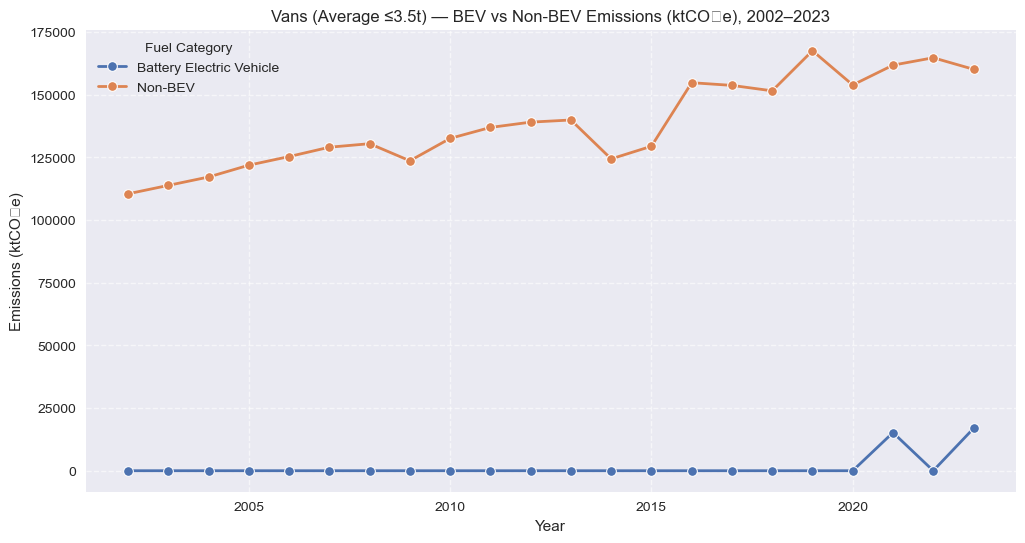

,Year,Fuel_Category,Emissions (ktCO2e)
0,2002,Battery Electric Vehicle,0.0
1,2002,Non-BEV,110443.3
2,2003,Battery Electric Vehicle,0.0
3,2003,Non-BEV,113805.2
4,2004,Battery Electric Vehicle,0.0
5,2004,Non-BEV,117149.0
6,2005,Battery Electric Vehicle,0.0
7,2005,Non-BEV,121864.0
8,2006,Battery Electric Vehicle,0.0
9,2006,Non-BEV,125302.5


In [72]:
# ============================================================
# Cell 4 — BEV vs Non-BEV Emissions for Vans (Average ≤3.5t)
# ============================================================
# Purpose:
# - Focus on vans (Average ≤3.5t) only, using the same filter as in previous cells.
# - Split emissions into two categories:
#     • Battery Electric Vehicles (BEVs)
#     • Non-BEVs (all other fuels combined)
# - Build yearly emission series for 2002–2023 (with BEVs appearing in 2021–2023).
# - Add a guard to warn if no BEV rows are present in the dataset.
# - Plot BEV vs Non-BEV emissions to illustrate the shift towards electrification.
# - Output the breakdown table (`bev_vs_nonbev`) for reference in later analysis.
# ============================================================


# Subset: Vans (Average ≤3.5t) only
vans_avg_df = df.loc[mask_vans_avg].copy()

# Classify BEV vs Non-BEV from Fuel_Laden Type (case-insensitive)
vans_avg_df['Fuel_Category'] = np.where(
    vans_avg_df['Fuel_Laden Type'].str.contains('battery', case=False, na=False),
    'Battery Electric Vehicle',
    'Non-BEV'
)

# Limit to 2021–2023 for clarity
years_recent = np.arange(2002, 2024)
bev_vs_nonbev = (
    vans_avg_df[vans_avg_df['Year'].isin(years_recent)]
      .groupby(['Year','Fuel_Category'])['Emissions (ktCO2e)']
      .sum()
      .reset_index()
      .sort_values(['Year','Fuel_Category'])
)

# Guard: if there are no BEV rows, warn but still plot Non-BEV
if not (bev_vs_nonbev['Fuel_Category'] == 'Battery Electric Vehicle').any():
    print("Note: No BEV rows found for Vans (Average ≤3.5t) in 2002–2023.")

# Plot
plt.figure(figsize=(12,6))
sns.lineplot(
    data=bev_vs_nonbev,
    x='Year', y='Emissions (ktCO2e)',
    hue='Fuel_Category', marker='o', linewidth=2
)
plt.title("Vans (Average ≤3.5t) — BEV vs Non-BEV Emissions (ktCO₂e), 2002–2023")
plt.xlabel("Year"); plt.ylabel("Emissions (ktCO₂e)")
plt.legend(title="Fuel Category"); plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

display(bev_vs_nonbev)


c:\Users\User\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


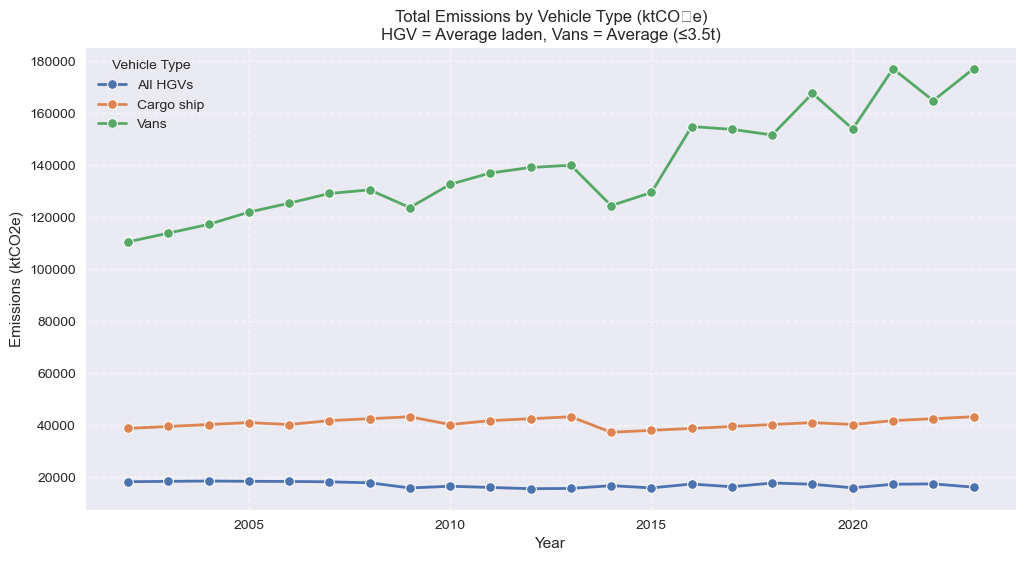

,Year,Vehicle Type,Emissions (ktCO2e)
0,2002,All HGVs,18268.0
1,2003,All HGVs,18400.0
2,2004,All HGVs,18528.0
3,2005,All HGVs,18420.0
4,2006,All HGVs,18369.0
5,2007,All HGVs,18230.0
6,2008,All HGVs,17850.0
7,2009,All HGVs,15875.0
8,2010,All HGVs,16530.0
9,2011,All HGVs,16070.0


In [73]:
# ============================================================
# Cell 5 — Total Emissions by Vehicle Type (HGV, Vans, Ships)
# ============================================================
# Purpose:
# - Build yearly emissions series (2002–2023) for three key groups:
#     • HGVs (Average laden only)
#     • Vans (Average ≤3.5 tonnes)
#     • Cargo ships (sum over all ship classes)
# - Combine these series into a tidy dataframe for comparison.
# - Plot trends side-by-side to show relative contributions
#   of each vehicle type to total freight emissions.
# - Output the combined table for inspection and later analysis.
# ============================================================


# Build per-year series
hgv_by_year   = (df.loc[mask_hgv_avg]
                   .groupby('Year')['Emissions (ktCO2e)']
                   .sum()
                   .reindex(years_hist)
                   .rename('All HGVs'))

vans_by_year  = (df.loc[mask_vans_avg]
                   .groupby('Year')['Emissions (ktCO2e)']
                   .sum()
                   .reindex(years_hist)
                   .rename('Vans'))

ships_by_year = (df[df['Vehicle Type'] == 'Cargo ship']
                   .groupby('Year')['Emissions (ktCO2e)']
                   .sum()
                   .reindex(years_hist)
                   .rename('Cargo ship'))

# Combine & tidy
emissions_by_vehicle_wide = pd.concat(
    [hgv_by_year, vans_by_year, ships_by_year], axis=1
)

emissions_by_vehicle = (emissions_by_vehicle_wide
                        .reset_index()
                        .melt(id_vars='Year',
                              var_name='Vehicle Type',
                              value_name='Emissions (ktCO2e)')
                        .sort_values(['Vehicle Type','Year']))

# Plot
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=emissions_by_vehicle,
    x='Year', y='Emissions (ktCO2e)',
    hue='Vehicle Type', marker='o', linewidth=2
)
plt.title("Total Emissions by Vehicle Type (ktCO₂e)\nHGV = Average laden, Vans = Average (≤3.5t)")
plt.xlabel("Year"); plt.ylabel("Emissions (ktCO2e)")
plt.legend(title="Vehicle Type")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# Inspect table
display(emissions_by_vehicle.head(12))


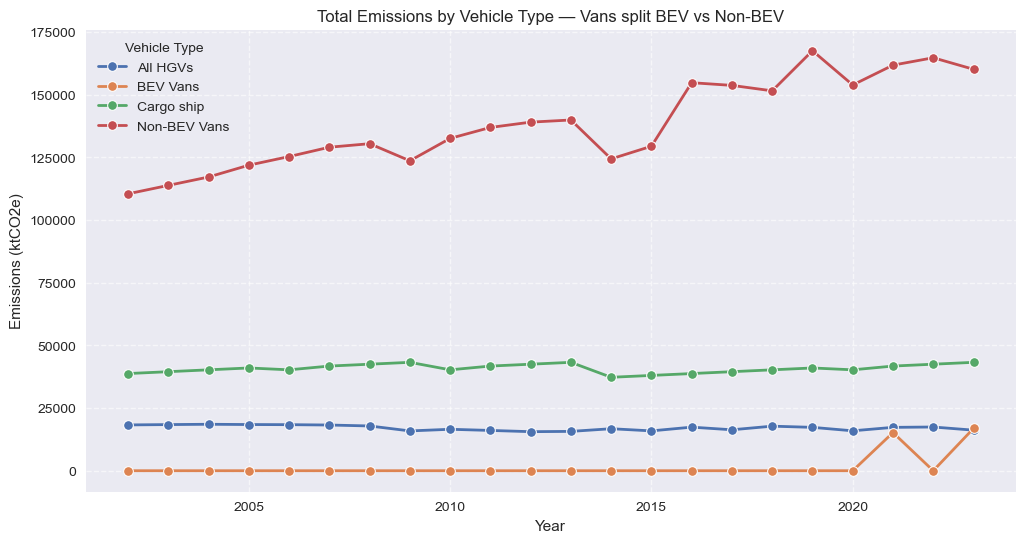

,Year,Vehicle Type Detailed,Emissions (ktCO2e)
0,2002,All HGVs,18268.0
1,2003,All HGVs,18400.0
2,2004,All HGVs,18528.0
3,2005,All HGVs,18420.0
4,2006,All HGVs,18369.0
5,2007,All HGVs,18230.0
6,2008,All HGVs,17850.0
7,2009,All HGVs,15875.0
8,2010,All HGVs,16530.0
9,2011,All HGVs,16070.0


In [ ]:
# ============================================================
# Cell 6 — Emissions by Vehicle Type (Vans split: BEV vs Non-BEV)
# ============================================================
# Purpose:
# - Extend Cell 5 by splitting Vans (Average ≤3.5t) into:
#     • BEV Vans
#     • Non-BEV Vans
# - Keep HGVs (Average laden) and optionally add Cargo ships.
# - Ensure both BEV and Non-BEV columns exist, even if BEVs are
#   missing in early years (pre-2020s).
# - Combine into a long-format dataframe for plotting and analysis.
# - Plot emissions trends to show where BEVs start contributing.
# - Provide a sanity note if BEV values are zero across the window.
# ============================================================

include_ships = True  

# ---- build base series ----
# HGV (Average laden)
hgv_series = (df.loc[mask_hgv_avg]
                .groupby('Year')['Emissions (ktCO2e)']
                .sum()
                .reindex(years_hist)
                .rename('All HGVs'))

# Vans (Average ≤3.5t) split BEV vs Non-BEV
vans_avg_df = df.loc[mask_vans_avg].copy()
vans_avg_df['Fuel_Category'] = np.where(
    vans_avg_df['Fuel_Laden Type'].str.contains('battery', case=False, na=False),
    'BEV Vans', 'Non-BEV Vans'
)

vans_split = (vans_avg_df
              .groupby(['Year','Fuel_Category'])['Emissions (ktCO2e)']
              .sum()
              .unstack(fill_value=0)
              .reindex(years_hist, fill_value=0))

# Ensure both columns exist even if one is missing in early years
for col in ['BEV Vans','Non-BEV Vans']:
    if col not in vans_split.columns:
        vans_split[col] = 0.0
vans_split = vans_split[['BEV Vans','Non-BEV Vans']]  # order

# Cargo ship (optional)
if include_ships:
    ships_series = (df[df['Vehicle Type']=='Cargo ship']
                      .groupby('Year')['Emissions (ktCO2e)']
                      .sum()
                      .reindex(years_hist, fill_value=0)
                      .rename('Cargo ship'))
else:
    ships_series = pd.Series(0.0, index=years_hist, name='Cargo ship')

# ---- combine to long format ----
wide = pd.concat([hgv_series, vans_split, ships_series], axis=1)
wide = wide.loc[years_hist]  # ensure year order
emissions_by_vehicle_detailed = (wide
    .reset_index()
    .melt(id_vars='Year', var_name='Vehicle Type Detailed', value_name='Emissions (ktCO2e)')
    .sort_values(['Vehicle Type Detailed','Year'])
)

# ---- plot ----
plt.figure(figsize=(12,6))
sns.lineplot(
    data=emissions_by_vehicle_detailed,
    x='Year', y='Emissions (ktCO2e)',
    hue='Vehicle Type Detailed', marker='o', linewidth=2
)
title_suffix = "" if include_ships else " (Road only)"
plt.title(f"Total Emissions by Vehicle Type — Vans split BEV vs Non-BEV{title_suffix}")
plt.xlabel("Year"); plt.ylabel("Emissions (ktCO2e)")
plt.legend(title="Vehicle Type"); plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# ---- sanity note if BEV missing in many years ----
if (vans_split['BEV Vans']==0).all():
    print("Note: No BEV Vans emissions found in 2002–2023 (common before 2020s).")

display(emissions_by_vehicle_detailed.head(12))


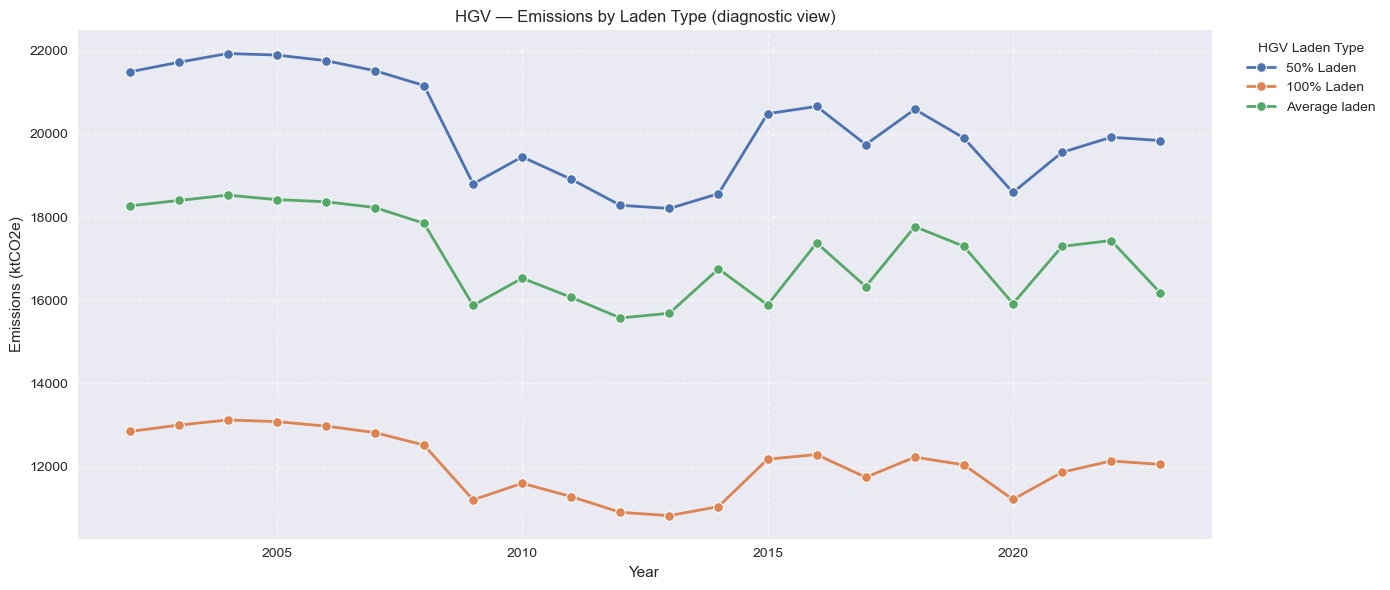

,Year,Fuel_Laden Type,Emissions (ktCO2e)
22,2002,100% Laden,12843.9
23,2003,100% Laden,12997.0
24,2004,100% Laden,13121.0
25,2005,100% Laden,13081.0
26,2006,100% Laden,12974.0
27,2007,100% Laden,12818.0
28,2008,100% Laden,12517.0
29,2009,100% Laden,11200.6
30,2010,100% Laden,11597.7
31,2011,100% Laden,11278.0


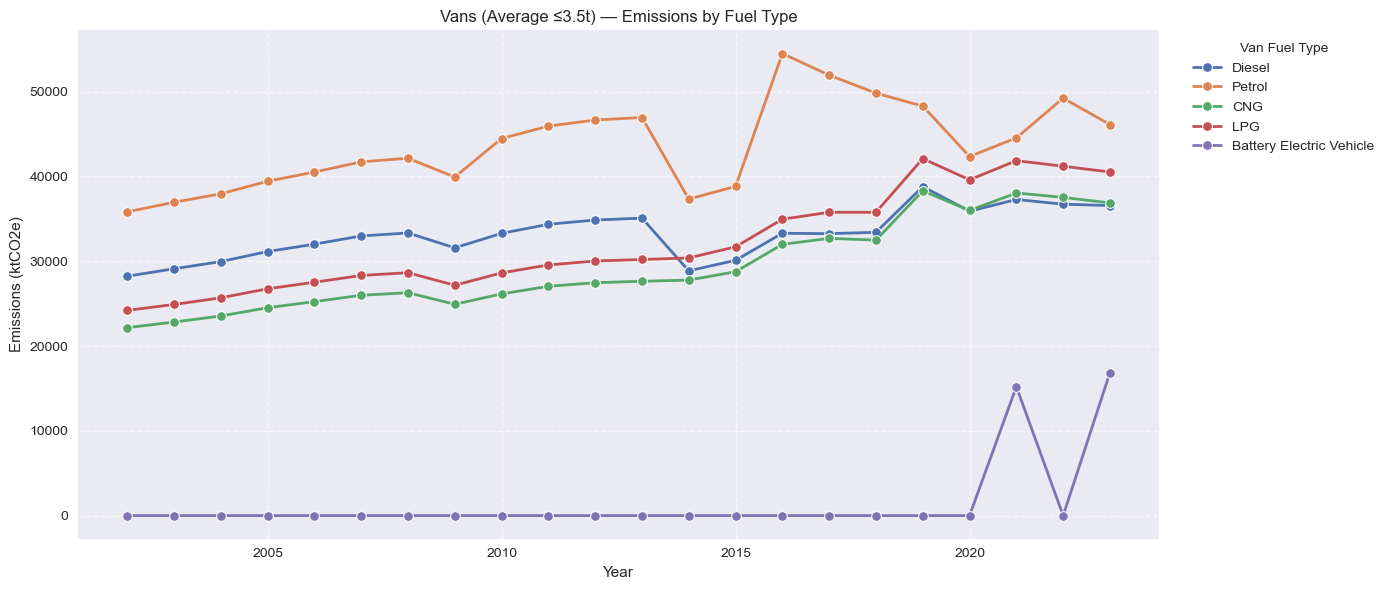

,Year,Fuel_Laden Type,Emissions (ktCO2e)
88,2002,Battery Electric Vehicle,0.0
89,2003,Battery Electric Vehicle,0.0
90,2004,Battery Electric Vehicle,0.0
91,2005,Battery Electric Vehicle,0.0
92,2006,Battery Electric Vehicle,0.0
93,2007,Battery Electric Vehicle,0.0
94,2008,Battery Electric Vehicle,0.0
95,2009,Battery Electric Vehicle,0.0
96,2010,Battery Electric Vehicle,0.0
97,2011,Battery Electric Vehicle,0.0


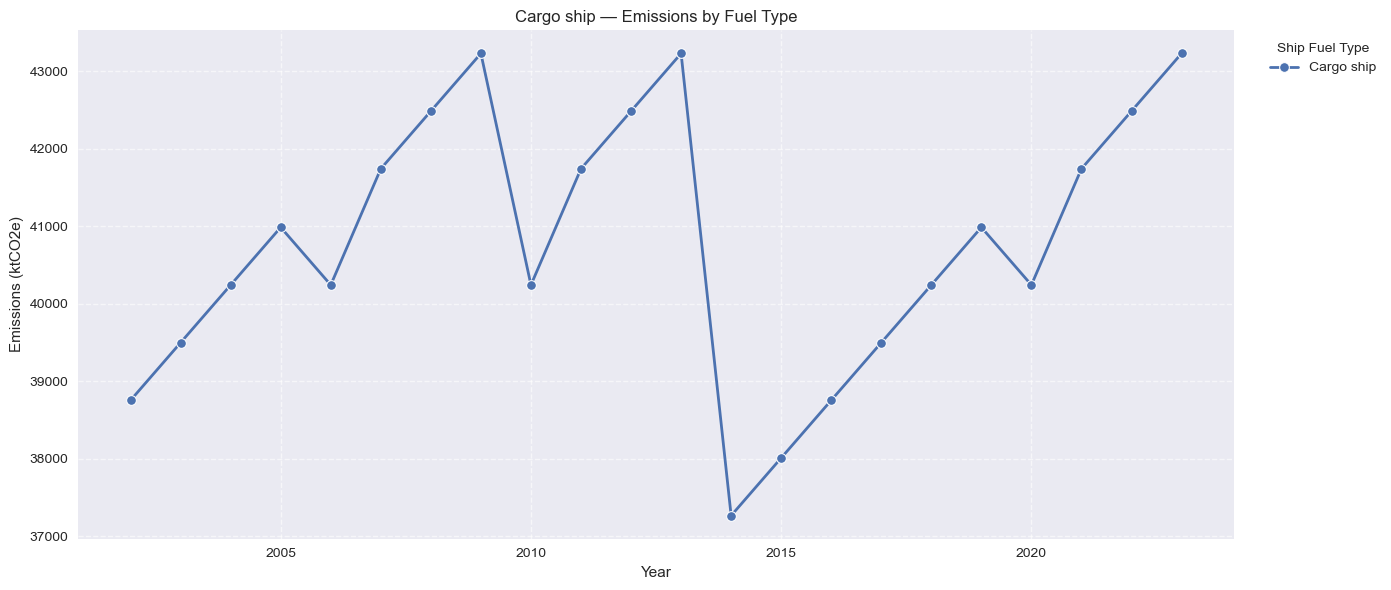

,Year,Fuel_Laden Type,Emissions (ktCO2e)
0,2002,Cargo ship,38753.7
1,2003,Cargo ship,39497.9
2,2004,Cargo ship,40242.2
3,2005,Cargo ship,40986.5
4,2006,Cargo ship,40242.2
5,2007,Cargo ship,41742.5
6,2008,Cargo ship,42486.8
7,2009,Cargo ship,43231.1
8,2010,Cargo ship,40242.2
9,2011,Cargo ship,41742.5


NOTE:
- HGV 50%/100%/Average are separate diagnostic series — do NOT sum them.
- Vans chart uses ONLY 'Average (up to 3.5 tonnes)' and splits by fuel (safe to sum across fuels).
- Cargo ship chart splits by available ship fuel types.



In [75]:
# ============================================================
# Cell 7 — Total Emissions by Fuel / Laden (disaggregated, robust)
# ============================================================
# Purpose:
# - Provide a diagnostic breakdown of emissions by laden/fuel categories.
# - HGVs: show separate laden types (50%, 100%, Average) — for comparison only,
#   not to be summed (diagnostic view).
# - Vans (Average ≤3.5t): split emissions by fuel type (Diesel, Petrol, CNG, LPG, BEV).
# - Cargo ships: split by available ship fuel types (if present).
# - Build pivot tables for each group and reformat into long format for plotting.
# - Generate separate plots for each vehicle group to visualise differences
#   across fuel/laden types.
# - Note: HGV laden categories are diagnostic only; vans and ships can be safely
#   summed by fuel type.
# ============================================================


# ---------- HGV by Laden Type (diagnostic, not for totals) ----------
keep_laden = ['50% Laden', '100% Laden', 'Average laden']

hgv_laden = (
    df[df['Vehicle Type'] == 'All HGVs']
      [['Year','Fuel_Laden Type','Emissions (ktCO2e)']]
      .copy()
)
hgv_laden = hgv_laden[hgv_laden['Fuel_Laden Type'].isin(keep_laden)]

hgv_laden_piv = (hgv_laden.pivot_table(
                    index='Year', columns='Fuel_Laden Type',
                    values='Emissions (ktCO2e)', aggfunc='sum')
                 .reindex(index=years_hist))

hgv_cols = [c for c in keep_laden if c in hgv_laden_piv.columns]
hgv_laden_piv = hgv_laden_piv.reindex(columns=hgv_cols, fill_value=0)

hgv_laden_long = (hgv_laden_piv
                  .reset_index()
                  .melt(id_vars='Year', var_name='Fuel_Laden Type',
                        value_name='Emissions (ktCO2e)'))

plt.figure(figsize=(14,6))
sns.lineplot(
    data=hgv_laden_long,
    x='Year', y='Emissions (ktCO2e)',
    hue='Fuel_Laden Type', marker='o', linewidth=2
)
plt.title("HGV — Emissions by Laden Type (diagnostic view)")
plt.xlabel("Year"); plt.ylabel("Emissions (ktCO2e)")
plt.legend(title="HGV Laden Type", bbox_to_anchor=(1.02, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

display(hgv_laden_long.sort_values(['Fuel_Laden Type','Year']).head(12))

# ---------- Vans (Average ≤3.5t) by Fuel Type ----------
vans_avg_fuel = (
    df.loc[mask_vans_avg, ['Year','Fuel_Laden Type','Emissions (ktCO2e)']]
      .copy()
)

vans_piv = (vans_avg_fuel.pivot_table(
                index='Year', columns='Fuel_Laden Type',
                values='Emissions (ktCO2e)', aggfunc='sum')
            .reindex(index=years_hist))

fuel_order = ['Diesel','Petrol','CNG','LPG','Battery Electric Vehicle']
fuel_cols = [f for f in fuel_order if f in vans_piv.columns]
vans_piv = vans_piv.reindex(columns=fuel_cols, fill_value=0)

vans_long = (vans_piv
             .reset_index()
             .melt(id_vars='Year', var_name='Fuel_Laden Type',
                   value_name='Emissions (ktCO2e)'))

plt.figure(figsize=(14,6))
sns.lineplot(
    data=vans_long,
    x='Year', y='Emissions (ktCO2e)',
    hue='Fuel_Laden Type', marker='o', linewidth=2
)
plt.title("Vans (Average ≤3.5t) — Emissions by Fuel Type")
plt.xlabel("Year"); plt.ylabel("Emissions (ktCO2e)")
plt.legend(title="Van Fuel Type", bbox_to_anchor=(1.02, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

display(vans_long.sort_values(['Fuel_Laden Type','Year']).head(12))

# ---------- Cargo ship by Fuel Type ----------
ships_fuel = (
    df[df['Vehicle Type'] == 'Cargo ship']
      [['Year','Fuel_Laden Type','Emissions (ktCO2e)']]
      .copy()
)

if ships_fuel.empty:
    print("Note: No Cargo ship rows found.")
else:
    ships_piv = (ships_fuel.pivot_table(
                    index='Year', columns='Fuel_Laden Type',
                    values='Emissions (ktCO2e)', aggfunc='sum')
                 .reindex(index=years_hist))

    ship_cols = sorted([c for c in ships_piv.columns if pd.notna(c)])
    ships_piv = ships_piv.reindex(columns=ship_cols, fill_value=0)

    ships_long = (ships_piv
                  .reset_index()
                  .melt(id_vars='Year', var_name='Fuel_Laden Type',
                        value_name='Emissions (ktCO2e)'))

    plt.figure(figsize=(14,6))
    sns.lineplot(
        data=ships_long,
        x='Year', y='Emissions (ktCO2e)',
        hue='Fuel_Laden Type', marker='o', linewidth=2
    )
    plt.title("Cargo ship — Emissions by Fuel Type")
    plt.xlabel("Year"); plt.ylabel("Emissions (ktCO2e)")
    plt.legend(title="Ship Fuel Type", bbox_to_anchor=(1.02, 1), loc='upper left')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

    display(ships_long.sort_values(['Fuel_Laden Type','Year']).head(12))

print(
    "NOTE:\n"
    "- HGV 50%/100%/Average are separate diagnostic series — do NOT sum them.\n"
    "- Vans chart uses ONLY 'Average (up to 3.5 tonnes)' and splits by fuel (safe to sum across fuels).\n"
    "- Cargo ship chart splits by available ship fuel types.\n"
)


C:\Users\User\AppData\Local\Temp\ipykernel_43064\489239743.py:39: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(weighted_avg_ei)


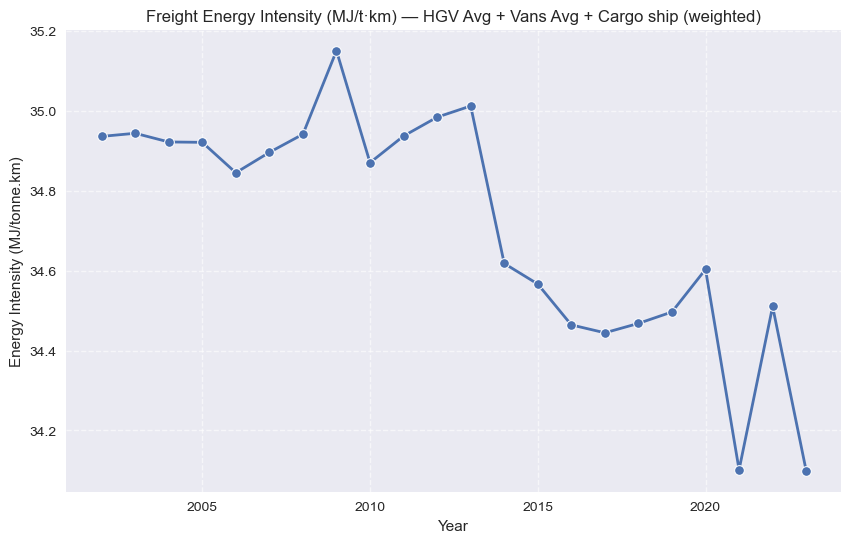

,Year,Energy_Intensity (MJ/tonne.km)
0,2002,34.935895
1,2003,34.943700
2,2004,34.922003
3,2005,34.921044
4,2006,34.844965
5,2007,34.895927
6,2008,34.941324
7,2009,35.150326
8,2010,34.870123
9,2011,34.936832


C:\Users\User\AppData\Local\Temp\ipykernel_43064\489239743.py:71: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(weighted_avg_ei)


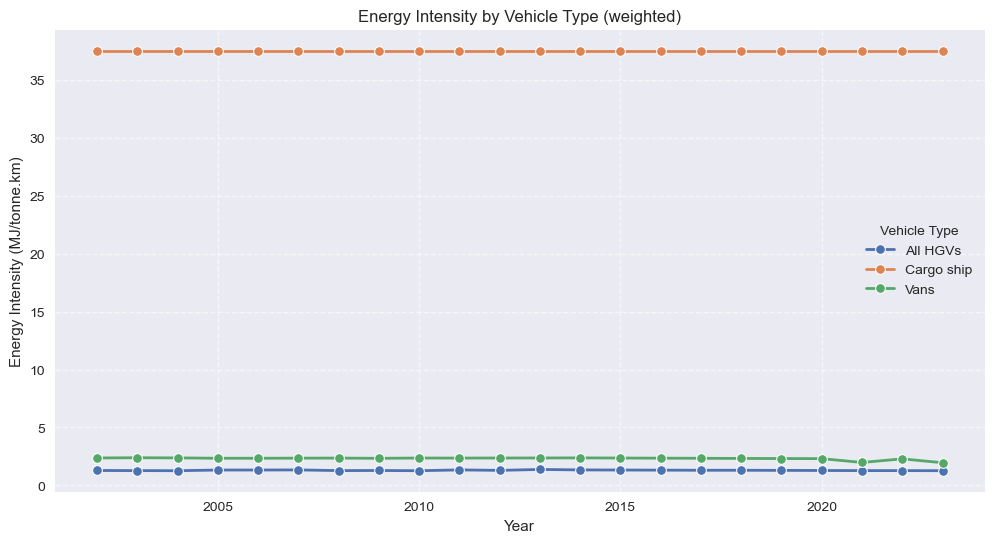

Vehicle Type,All HGVs,Cargo ship,Vans
Year,,,
2002,1.29,37.5,2.3700
2003,1.28,37.5,2.3900
2004,1.27,37.5,2.3775
2005,1.33,37.5,2.3450
2006,1.33,37.5,2.3450
2007,1.34,37.5,2.3550
2008,1.28,37.5,2.3600
2009,1.29,37.5,2.3400
2010,1.27,37.5,2.3650


In [ ]:
# ============================================================
# Cell 8 — Energy Intensity per tonne-km (All Vehicle Types)
# ============================================================
# Purpose:
# - Extend energy intensity analysis from road-only (Cell 3) to all freight:
#     • HGVs (Average laden)
#     • Vans (Average ≤3.5t)
#     • Cargo ships (all rows)
# - Compute weighted averages using tonne.km as weights (avoids bias).
# - Build:
#     • EI_ALL_hist  — single series for total freight energy intensity.
#     • energy_intensity_all_df — tidy table for total freight EI plotting.
#     • energy_intensity_by_vehicle — optional per-vehicle weighted EI.
# - Interpolate missing values to maintain continuity across 2002–2023.
# - Plot:
#     • Overall freight EI trend.
#     • Per-vehicle EI comparison (optional chart).
# - Ensure all EI values are finite and positive before downstream modelling.
# ============================================================

# helper for weighted average EI
if 'weighted_avg_ei' not in globals():
    def weighted_avg_ei(g):
        w = (g['Energy Intensity (MJ/tonne.km)'] * g['Estimated Activity (tonne.km)']).sum()
        d = g['Estimated Activity (tonne.km)'].sum()
        return np.nan if d == 0 else w / d
# assemble the ALL-freight subset
hgv_ei   = df.loc[mask_hgv_avg].copy()
vans_ei  = df.loc[mask_vans_avg].copy()
ships_ei = df[df['Vehicle Type'] == 'Cargo ship'].copy()

df_all_ei = pd.concat([hgv_ei, vans_ei, ships_ei], ignore_index=True)
# ----- total EI (all vehicle types, weighted) -----
EI_ALL_hist = (df_all_ei
               .groupby('Year')
               .apply(weighted_avg_ei)
               .reindex(years_hist))
# handle any missing years by linear interpolation (and warn)
if EI_ALL_hist.isna().any():
    missing = EI_ALL_hist[EI_ALL_hist.isna()].index.tolist()
    print(f"Note: missing EI years {missing}; interpolating.")
    EI_ALL_hist = EI_ALL_hist.interpolate(limit_direction='both')
# tidy table for plotting
energy_intensity_all_df = EI_ALL_hist.reset_index()
energy_intensity_all_df.columns = ['Year','Energy_Intensity (MJ/tonne.km)']
# sanity
assert np.isfinite(EI_ALL_hist).all(), "Non-finite EI values after interpolation."
assert (EI_ALL_hist > 0).all(), "EI must be positive."
# plot total EI
plt.figure(figsize=(10,6))
sns.lineplot(data=energy_intensity_all_df, x='Year',
             y='Energy_Intensity (MJ/tonne.km)', marker='o', linewidth=2)
plt.title("Freight Energy Intensity (MJ/t·km) — HGV Avg + Vans Avg + Cargo ship (weighted)")
plt.xlabel("Year"); plt.ylabel("Energy Intensity (MJ/tonne.km)")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

display(energy_intensity_all_df.head(12))
# ----- (optional) per-vehicle-type weighted EI -----
energy_intensity_by_vehicle = (
    df_all_ei
    .groupby(['Vehicle Type','Year'])
    .apply(weighted_avg_ei)
    .reset_index(name='Energy_Intensity (MJ/tonne.km)')
    .pivot(index='Year', columns='Vehicle Type', values='Energy_Intensity (MJ/tonne.km)')
    .reindex(years_hist)
)
# plot per-vehicle EI (if useful)
plt.figure(figsize=(12,6))
sns.lineplot(data=energy_intensity_by_vehicle.reset_index().melt('Year',
             var_name='Vehicle Type', value_name='Energy_Intensity (MJ/tonne.km)'),
             x='Year', y='Energy_Intensity (MJ/tonne.km)', hue='Vehicle Type', marker='o', linewidth=2)
plt.title("Energy Intensity by Vehicle Type (weighted)")
plt.xlabel("Year"); plt.ylabel("Energy Intensity (MJ/tonne.km)")
plt.legend(title="Vehicle Type"); plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

display(energy_intensity_by_vehicle.head(12))


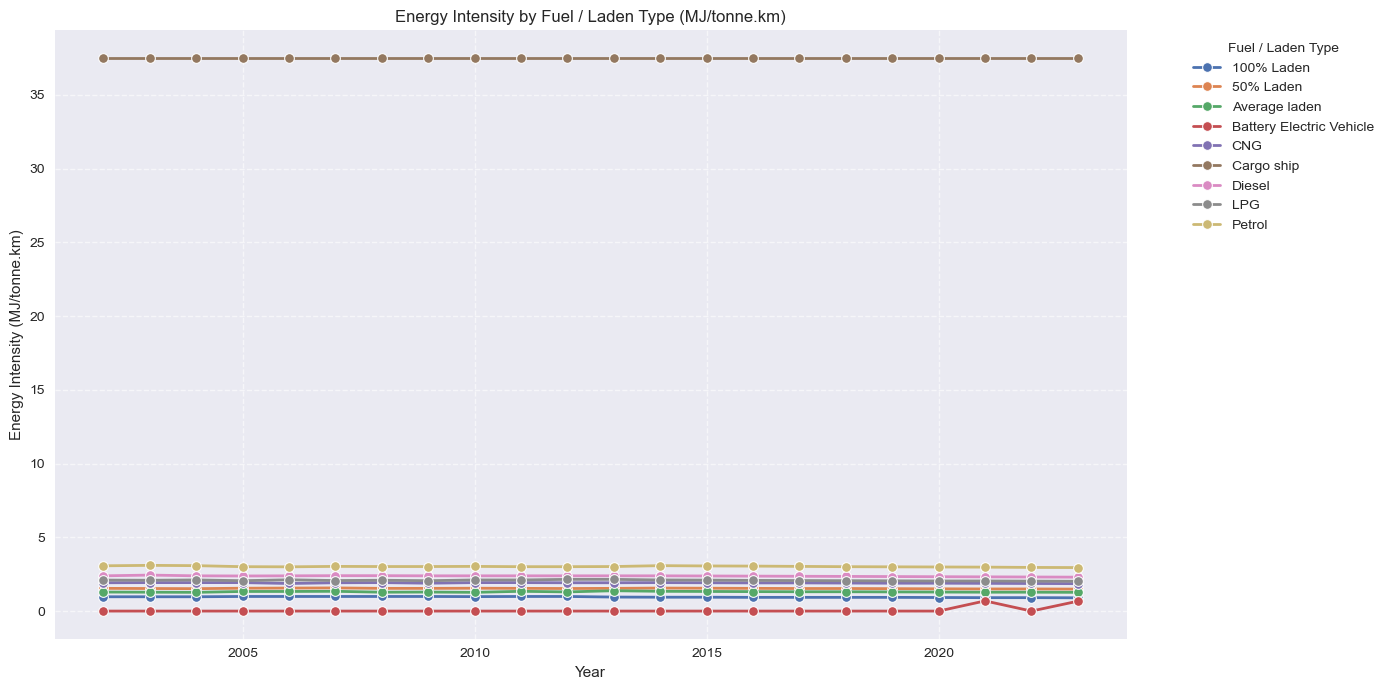

,Year,Fuel_Laden Type,Energy Intensity (MJ/tonne.km)
0,2002,100% Laden,0.97
9,2003,100% Laden,0.97
18,2004,100% Laden,0.97
27,2005,100% Laden,0.99
36,2006,100% Laden,0.99
...,...,...,...
161,2019,Petrol,3.00
170,2020,Petrol,2.99
179,2021,Petrol,2.98
188,2022,Petrol,2.96


In [77]:
# ============================================================
# Cell 9 — Energy Intensity by Fuel Type
# ============================================================
# Purpose:
# - Break down energy intensity trends by fuel / laden category.
# - Group by Year and Fuel_Laden Type, taking the mean intensity
#   for each combination.
# - Produce a tidy dataframe sorted by fuel type and year.
# - Plot time series to compare efficiency performance
#   across different fuels and laden types.
# - Output the full table for inspection or later diagnostics.
# ============================================================


# 1. Aggregate mean Energy Intensity by Year & Fuel_Laden Type
energy_intensity_fuel = (
    df.groupby(['Year', 'Fuel_Laden Type'])['Energy Intensity (MJ/tonne.km)']
    .mean()
    .reset_index()
    .sort_values(['Fuel_Laden Type', 'Year'])
)

# 2. Plot energy intensity by fuel/laden type
plt.figure(figsize=(14, 7))
sns.lineplot(
    data=energy_intensity_fuel,
    x='Year',
    y='Energy Intensity (MJ/tonne.km)',
    hue='Fuel_Laden Type',
    marker='o',
    linewidth=2
)
plt.title("Energy Intensity by Fuel / Laden Type (MJ/tonne.km)")
plt.xlabel("Year")
plt.ylabel("Energy Intensity (MJ/tonne.km)")
plt.legend(title="Fuel / Laden Type", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# 3. Display table
display(energy_intensity_fuel)


C:\Users\User\AppData\Local\Temp\ipykernel_43064\13859288.py:34: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(weighted_avg_ei)
C:\Users\User\AppData\Local\Temp\ipykernel_43064\13859288.py:51: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(weighted_avg_ei)
C:\Users\User\AppData\Local\Temp\ipykernel_43064\13859288.py:71: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns

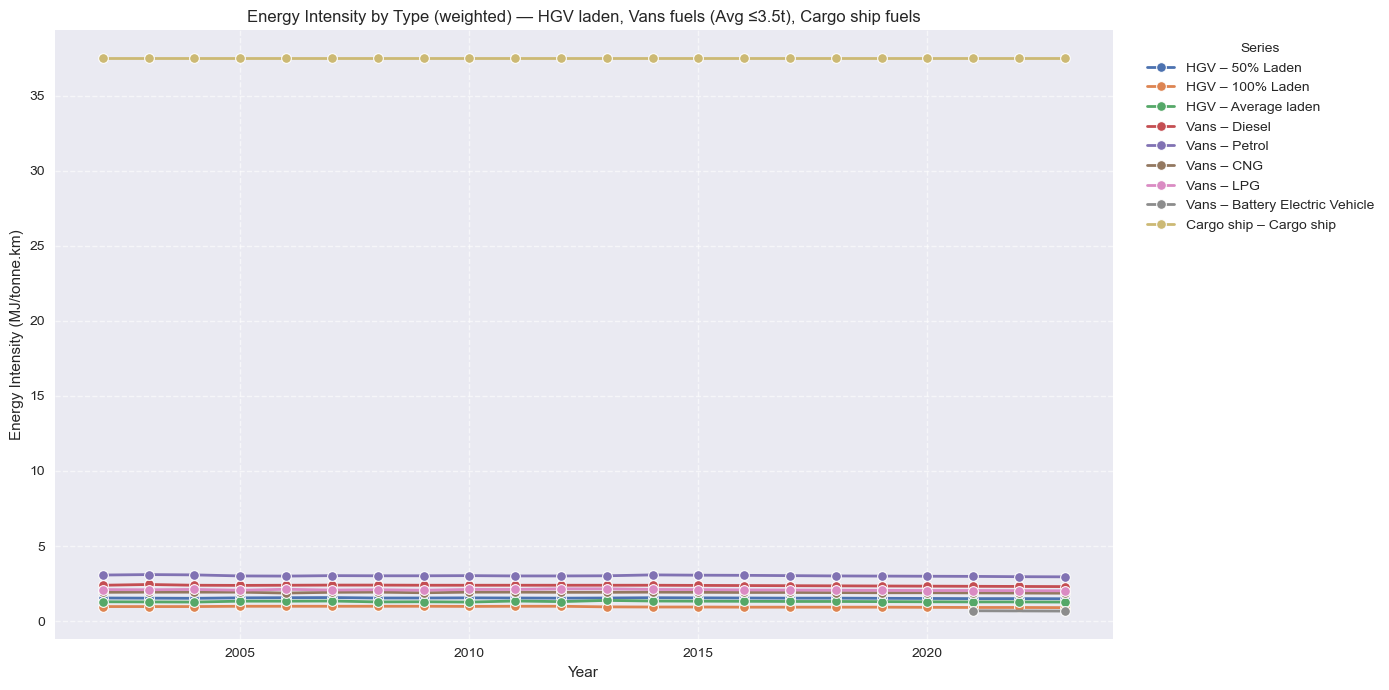

,Year,Subtype,Energy Intensity (MJ/tonne.km),Series
0,2002,50% Laden,1.54,HGV – 50% Laden
1,2003,50% Laden,1.53,HGV – 50% Laden
2,2004,50% Laden,1.52,HGV – 50% Laden
3,2005,50% Laden,1.55,HGV – 50% Laden
4,2006,50% Laden,1.56,HGV – 50% Laden
5,2007,50% Laden,1.57,HGV – 50% Laden
6,2008,50% Laden,1.54,HGV – 50% Laden
7,2009,50% Laden,1.54,HGV – 50% Laden
8,2010,50% Laden,1.55,HGV – 50% Laden
9,2011,50% Laden,1.54,HGV – 50% Laden


In [78]:
# ============================================================
# Cell 10 — Energy Intensity by Type (ALL vehicles, weighted)
# ============================================================
# Purpose:
# - Provide a full disaggregated view of energy intensity trends.
# - Breaks down freight EI into:
#     • HGV by laden type (50%, 100%, Average).
#     • Vans (≤3.5t Average) by individual fuel type (Diesel, Petrol, CNG, LPG, BEV).
#     • Cargo ships by fuel type.
# - All results are weighted by activity (tonne.km) to avoid bias
#   from unequal sample counts.
# - Produces one combined tidy dataframe and a single chart
#   comparing all vehicle/fuel sub-series side by side.
# - Used for deep-dive diagnostic comparisons, not modelling baselines.
# ============================================================


# helper (weighted EI)
if 'weighted_avg_ei' not in globals():
    def weighted_avg_ei(g):
        w = (g['Energy Intensity (MJ/tonne.km)'] * g['Estimated Activity (tonne.km)']).sum()
        d = g['Estimated Activity (tonne.km)'].sum()
        return np.nan if d == 0 else w / d

keep_laden  = ['50% Laden','100% Laden','Average laden']
fuel_order  = ['Diesel','Petrol','CNG','LPG','Battery Electric Vehicle']

# ---------- HGV (by laden type) ----------
hgv_ei_src = (df[df['Vehicle Type']=='All HGVs']
              [['Year','Fuel_Laden Type','Energy Intensity (MJ/tonne.km)','Estimated Activity (tonne.km)']].copy())

hgv_ei = (hgv_ei_src[hgv_ei_src['Fuel_Laden Type'].isin(keep_laden)]
          .groupby(['Fuel_Laden Type','Year'])
          .apply(weighted_avg_ei)
          .unstack('Fuel_Laden Type')
          .reindex(index=years_hist))

hgv_cols = [c for c in keep_laden if c in hgv_ei.columns]
hgv_ei = hgv_ei.reindex(columns=hgv_cols)

hgv_long = (hgv_ei.reset_index()
            .melt(id_vars='Year', var_name='Subtype', value_name='Energy Intensity (MJ/tonne.km)'))
hgv_long['Series'] = 'HGV – ' + hgv_long['Subtype']

# ---------- Vans (Average ≤3.5t) by fuel type ----------
vans_ei_src = (df.loc[mask_vans_avg, ['Year','Fuel_Laden Type',
                                      'Energy Intensity (MJ/tonne.km)','Estimated Activity (tonne.km)']].copy())

vans_ei = (vans_ei_src
           .groupby(['Fuel_Laden Type','Year'])
           .apply(weighted_avg_ei)
           .unstack('Fuel_Laden Type')
           .reindex(index=years_hist))

van_cols = [f for f in fuel_order if f in vans_ei.columns]
vans_ei = vans_ei.reindex(columns=van_cols)

vans_long = (vans_ei.reset_index()
             .melt(id_vars='Year', var_name='Subtype', value_name='Energy Intensity (MJ/tonne.km)'))
vans_long['Series'] = 'Vans – ' + vans_long['Subtype']

# ---------- Cargo ship by fuel type ----------
ships_src = (df[df['Vehicle Type']=='Cargo ship']
             [['Year','Fuel_Laden Type','Energy Intensity (MJ/tonne.km)','Estimated Activity (tonne.km)']].copy())

if ships_src.empty:
    ships_long = pd.DataFrame(columns=['Year','Subtype','Energy Intensity (MJ/tonne.km)','Series'])
else:
    ships_ei = (ships_src
                .groupby(['Fuel_Laden Type','Year'])
                .apply(weighted_avg_ei)
                .unstack('Fuel_Laden Type')
                .reindex(index=years_hist))
    ship_cols = [c for c in ships_ei.columns if pd.notna(c)]
    ships_ei = ships_ei.reindex(columns=ship_cols)

    ships_long = (ships_ei.reset_index()
                  .melt(id_vars='Year', var_name='Subtype', value_name='Energy Intensity (MJ/tonne.km)'))
    ships_long['Series'] = 'Cargo ship – ' + ships_long['Subtype']

# ---------- combine & plot ----------
combined_ei_long = pd.concat([hgv_long, vans_long, ships_long], ignore_index=True)
# drop rows that are entirely missing (e.g., early years with no BEV)
combined_ei_long = combined_ei_long.dropna(subset=['Energy Intensity (MJ/tonne.km)'])

plt.figure(figsize=(14,7))
sns.lineplot(
    data=combined_ei_long,
    x='Year', y='Energy Intensity (MJ/tonne.km)',
    hue='Series', marker='o', linewidth=2
)
plt.title("Energy Intensity by Type (weighted) — HGV laden, Vans fuels (Avg ≤3.5t), Cargo ship fuels")
plt.xlabel("Year"); plt.ylabel("Energy Intensity (MJ/tonne.km)")
plt.legend(title="Series", bbox_to_anchor=(1.02, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

display(combined_ei_long.head(20))


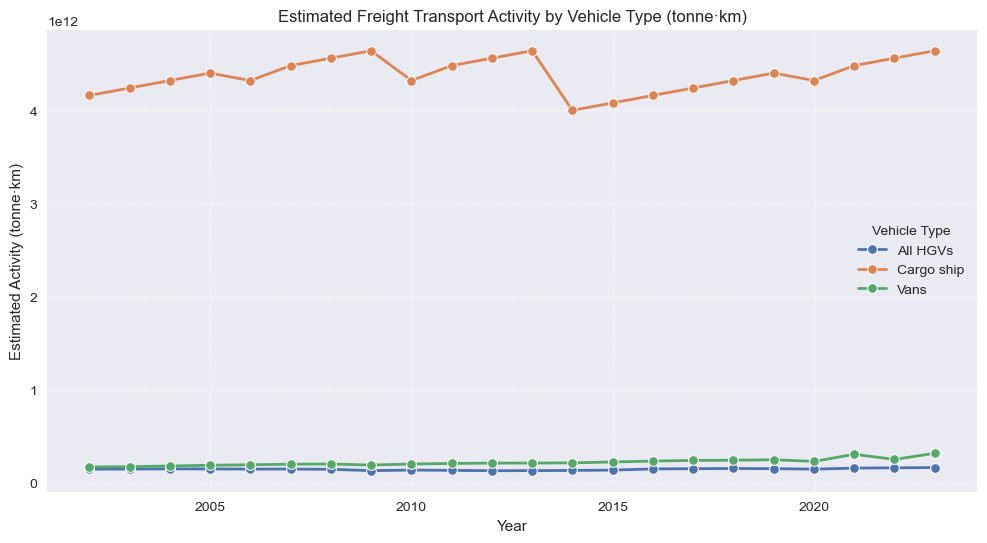

,Year,Vehicle Type,Estimated Activity (tonne.km)
0,2002,All HGVs,1.490000e+11
1,2003,All HGVs,1.510000e+11
2,2004,All HGVs,1.530000e+11
3,2005,All HGVs,1.520000e+11
4,2006,All HGVs,1.510000e+11
5,2007,All HGVs,1.510000e+11
6,2008,All HGVs,1.480000e+11
7,2009,All HGVs,1.340000e+11
8,2010,All HGVs,1.400000e+11
9,2011,All HGVs,1.370000e+11


In [79]:
# ============================================================
# Cell 11 — Estimated Freight Transport Activity (tonne.km)
# ============================================================
# Purpose:
# - Calculates annual freight activity by vehicle type:
#     • HGV (Average laden).
#     • Vans (Average ≤3.5t).
#     • Cargo ships (all classes combined).
# - Window: 2002–2023 (years_hist).
# - Produces:
#     • activity_by_vehicle : tidy long-format dataset.
#     • Line plot of tonne.km activity trends by vehicle type.
# - Core diagnostic for understanding demand drivers behind
#   emissions and energy intensity trends.
# ============================================================


# Build per-year activity series
hgv_activity = (df.loc[mask_hgv_avg]
                  .groupby('Year')['Estimated Activity (tonne.km)']
                  .sum()
                  .reindex(years_hist)
                  .rename('All HGVs'))

vans_activity = (df.loc[mask_vans_avg]
                   .groupby('Year')['Estimated Activity (tonne.km)']
                   .sum()
                   .reindex(years_hist)
                   .rename('Vans'))

ships_activity = (df[df['Vehicle Type'] == 'Cargo ship']
                    .groupby('Year')['Estimated Activity (tonne.km)']
                    .sum()
                    .reindex(years_hist)
                    .rename('Cargo ship'))

# Combine to long format
activity_by_vehicle = (
    pd.concat([hgv_activity, vans_activity, ships_activity], axis=1)
      .reset_index()
      .melt(id_vars='Year', var_name='Vehicle Type', value_name='Estimated Activity (tonne.km)')
      .sort_values(['Vehicle Type','Year'])
)

# Sanity: ensure no missing years for each vehicle series (fill zeros if truly absent)
for vt in ['All HGVs','Vans','Cargo ship']:
    if activity_by_vehicle[activity_by_vehicle['Vehicle Type']==vt]['Estimated Activity (tonne.km)'].isna().any():
        print(f"Note: filling missing activity values with 0 for {vt}.")
        activity_by_vehicle.loc[
            activity_by_vehicle['Vehicle Type']==vt, 'Estimated Activity (tonne.km)'
        ] = activity_by_vehicle.loc[
            activity_by_vehicle['Vehicle Type']==vt, 'Estimated Activity (tonne.km)'
        ].fillna(0)

# Plot
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=activity_by_vehicle,
    x='Year', y='Estimated Activity (tonne.km)',
    hue='Vehicle Type', marker='o', linewidth=2
)
plt.title("Estimated Freight Transport Activity by Vehicle Type (tonne·km)")
plt.xlabel("Year"); plt.ylabel("Estimated Activity (tonne·km)")
plt.legend(title="Vehicle Type"); plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

display(activity_by_vehicle.head(12))


C:\Users\User\AppData\Local\Temp\ipykernel_43064\825906005.py:34: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(weighted_avg_ei)
C:\Users\User\AppData\Local\Temp\ipykernel_43064\825906005.py:45: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(weighted_avg_ei)
C:\Users\User\AppData\Local\Temp\ipykernel_43064\825906005.py:56: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping colu

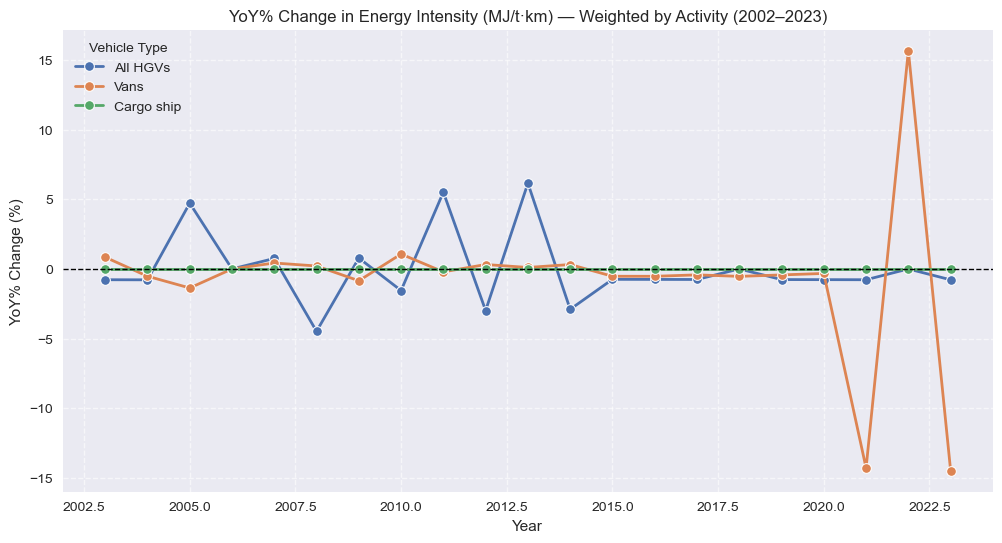

,Year,Vehicle Type,Energy Intensity (MJ/tonne.km),YoY% Change
0,2002,All HGVs,1.29,NaN
1,2003,All HGVs,1.28,-0.775194
2,2004,All HGVs,1.27,-0.781250
3,2005,All HGVs,1.33,4.724409
4,2006,All HGVs,1.33,0.000000
5,2007,All HGVs,1.34,0.751880
6,2008,All HGVs,1.28,-4.477612
7,2009,All HGVs,1.29,0.781250
8,2010,All HGVs,1.27,-1.550388
9,2011,All HGVs,1.34,5.511811


In [ ]:
# ============================================================
# Cell 12 — YoY% Change in Energy Intensity (by Vehicle Type)
# ============================================================
# Purpose:
# - Computes year-on-year % change in weighted energy intensity.
# - Vehicle groups:
#     • HGV (Average laden).
#     • Vans (Average ≤3.5t).
#     • Cargo ship (all classes).
# - Weighting = tonne.km.
# - Window: 2002–2023 (years_hist).
# - Outputs:
#     • energy_intensity_change: tidy dataset with YoY% change.
#     • Line chart of YoY% swings (with 0% reference line).

# helper for weighted EI (reuse if already defined)
if 'weighted_avg_ei' not in globals():
    def weighted_avg_ei(g):
        w = (g['Energy Intensity (MJ/tonne.km)'] * g['Estimated Activity (tonne.km)']).sum()
        d = g['Estimated Activity (tonne.km)'].sum()
        return np.nan if d == 0 else w / d

# build per-vehicle, per-year weighted EI across 2002–2023
series_list = []

# HGV (Average laden)
ei_hgv = (df.loc[mask_hgv_avg]
            .groupby('Year')
            .apply(weighted_avg_ei)
            .reindex(years_hist))
series_list.append(pd.DataFrame({
    'Year': years_hist,
    'Vehicle Type': 'All HGVs',
    'Energy Intensity (MJ/tonne.km)': ei_hgv.values
}))

# Vans (Average ≤3.5t)
ei_vans = (df.loc[mask_vans_avg]
             .groupby('Year')
             .apply(weighted_avg_ei)
             .reindex(years_hist))
series_list.append(pd.DataFrame({
    'Year': years_hist,
    'Vehicle Type': 'Vans',
    'Energy Intensity (MJ/tonne.km)': ei_vans.values
}))

# Cargo ship (all)
ei_ship = (df[df['Vehicle Type']=='Cargo ship']
             .groupby('Year')
             .apply(weighted_avg_ei)
             .reindex(years_hist))
series_list.append(pd.DataFrame({
    'Year': years_hist,
    'Vehicle Type': 'Cargo ship',
    'Energy Intensity (MJ/tonne.km)': ei_ship.values
}))

energy_intensity_change = pd.concat(series_list, ignore_index=True)

# YoY% change (compute on full range so each year compares to its prior year)
energy_intensity_change['YoY% Change'] = (
    energy_intensity_change
    .groupby('Vehicle Type')['Energy Intensity (MJ/tonne.km)']
    .pct_change() * 100
)

# energy_intensity_change['YoY% Change'] = energy_intensity_change['YoY% Change'].clip(-100, 100)

# Plot 2002–2023
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=energy_intensity_change,
    x='Year', y='YoY% Change',
    hue='Vehicle Type', marker='o', linewidth=2
)
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.title("YoY% Change in Energy Intensity (MJ/t·km) — Weighted by Activity (2002–2023)")
plt.xlabel("Year"); plt.ylabel("YoY% Change (%)")
plt.legend(title="Vehicle Type"); plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

display(energy_intensity_change.sort_values(['Vehicle Type','Year']).head(15))


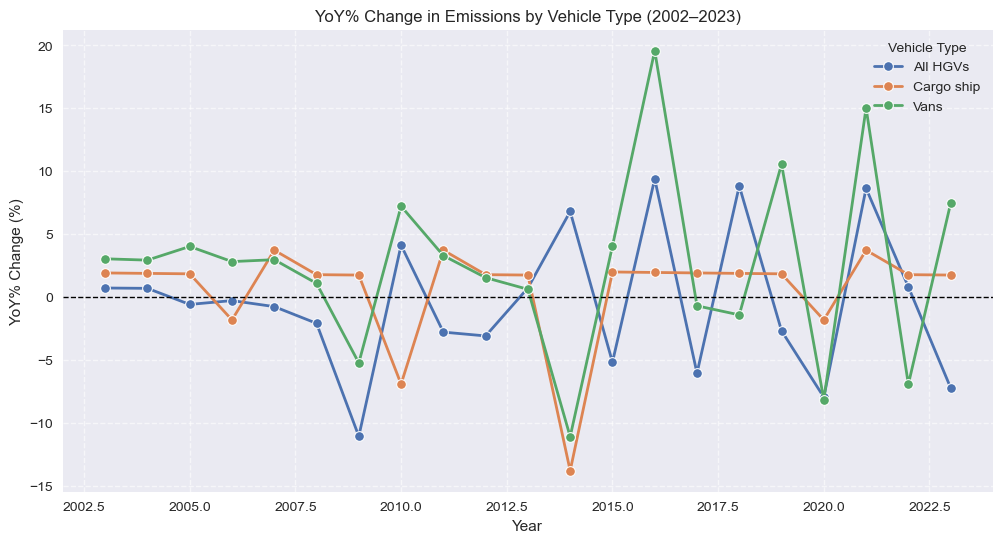

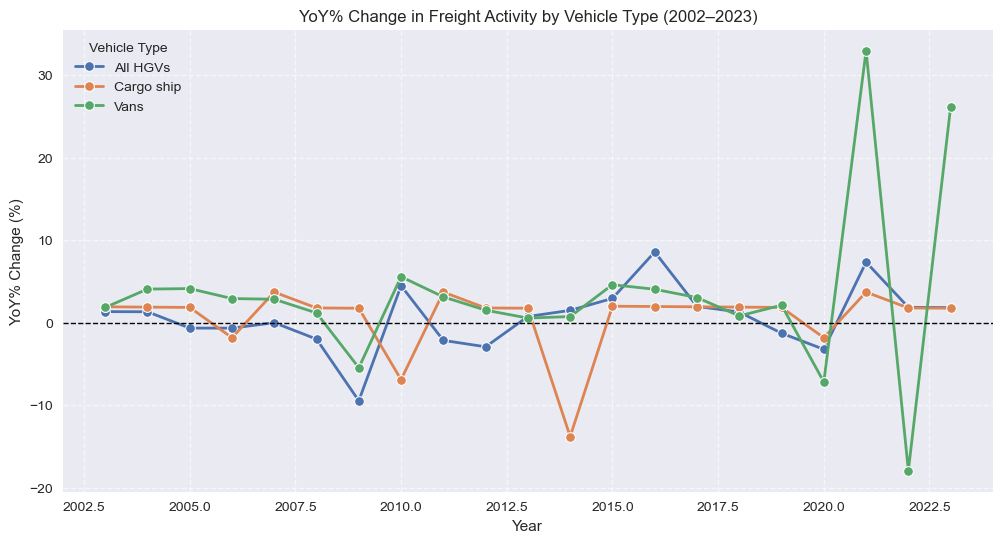

,Year,Vehicle Type,Emissions (ktCO2e),Estimated Activity (tonne.km),YoY% Change - Emissions,YoY% Change - Activity
0,2002,All HGVs,18268.0,1.490000e+11,NaN,NaN
1,2003,All HGVs,18400.0,1.510000e+11,0.722575,1.342282
2,2004,All HGVs,18528.0,1.530000e+11,0.695652,1.324503
3,2005,All HGVs,18420.0,1.520000e+11,-0.582902,-0.653595
4,2006,All HGVs,18369.0,1.510000e+11,-0.276873,-0.657895
5,2007,All HGVs,18230.0,1.510000e+11,-0.756710,0.000000
6,2008,All HGVs,17850.0,1.480000e+11,-2.084476,-1.986755
7,2009,All HGVs,15875.0,1.340000e+11,-11.064426,-9.459459
8,2010,All HGVs,16530.0,1.400000e+11,4.125984,4.477612
9,2011,All HGVs,16070.0,1.370000e+11,-2.782819,-2.142857


In [ ]:
# ============================================================
# Cell 13 — YoY% Change: Emissions & Activity (2002–2023)
# ============================================================
# Purpose:
# - Measures year-on-year % change for both emissions and freight activity.
# - Vehicle coverage:
#     • HGV (Average laden).
#     • Vans (Average ≤3.5t).
#     • Cargo ship (all classes combined).
# - Time window: 2002–2023.
#
# Outputs:
# - yoy_data: combined table with YoY% changes for emissions and activity.
# - Two line charts:
#     1. YoY% change in emissions by vehicle type.
#     2. YoY% change in activity by vehicle type.
#
# Notes:
# - Sharp swings highlight shocks (e.g., 2008 financial crisis, 2020 pandemic).
# - Useful for understanding whether emissions changes were demand-driven
#   (activity shifts) or efficiency-driven (decoupling of activity vs emissions).
# - Infinite values (from zero baselines) are cleaned to NaN for clarity.
# ============================================================


# --- build per-vehicle per-year series (2002–2023) ---
hgv_emis = (df.loc[mask_hgv_avg]
              .groupby('Year')['Emissions (ktCO2e)']
              .sum().reindex(years_hist).rename('All HGVs'))
vans_emis = (df.loc[mask_vans_avg]
               .groupby('Year')['Emissions (ktCO2e)']
               .sum().reindex(years_hist).rename('Vans'))
ship_emis = (df[df['Vehicle Type']=='Cargo ship']
               .groupby('Year')['Emissions (ktCO2e)']
               .sum().reindex(years_hist).rename('Cargo ship'))

hgv_act = (df.loc[mask_hgv_avg]
             .groupby('Year')['Estimated Activity (tonne.km)']
             .sum().reindex(years_hist).rename('All HGVs'))
vans_act = (df.loc[mask_vans_avg]
              .groupby('Year')['Estimated Activity (tonne.km)']
              .sum().reindex(years_hist).rename('Vans'))
ship_act = (df[df['Vehicle Type']=='Cargo ship']
              .groupby('Year')['Estimated Activity (tonne.km)']
              .sum().reindex(years_hist).rename('Cargo ship'))

# combine to long table
emis_long = (pd.concat([hgv_emis, vans_emis, ship_emis], axis=1)
               .reset_index()
               .melt(id_vars='Year', var_name='Vehicle Type',
                     value_name='Emissions (ktCO2e)'))
act_long  = (pd.concat([hgv_act, vans_act, ship_act], axis=1)
               .reset_index()
               .melt(id_vars='Year', var_name='Vehicle Type',
                     value_name='Estimated Activity (tonne.km)'))

yoy_data = (emis_long.merge(act_long, on=['Year','Vehicle Type'])
                     .sort_values(['Vehicle Type','Year']))

# --- YoY% changes (handle div-by-zero to avoid +/-inf) ---
yoy_data['YoY% Change - Emissions'] = (
    yoy_data.groupby('Vehicle Type')['Emissions (ktCO2e)']
            .pct_change() * 100
)
yoy_data['YoY% Change - Activity'] = (
    yoy_data.groupby('Vehicle Type')['Estimated Activity (tonne.km)']
            .pct_change() * 100
)

# replace infinite values (from 0→nonzero or vice versa) with NaN for cleanliness
yoy_data.replace([np.inf, -np.inf], np.nan, inplace=True)

# --- Plot: YoY% change in emissions ---
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=yoy_data, x='Year', y='YoY% Change - Emissions',
    hue='Vehicle Type', marker='o', linewidth=2
)
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.title("YoY% Change in Emissions by Vehicle Type (2002–2023)")
plt.xlabel("Year"); plt.ylabel("YoY% Change (%)")
plt.legend(title="Vehicle Type"); plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# --- Plot: YoY% change in activity ---
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=yoy_data, x='Year', y='YoY% Change - Activity',
    hue='Vehicle Type', marker='o', linewidth=2
)
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.title("YoY% Change in Freight Activity by Vehicle Type (2002–2023)")
plt.xlabel("Year"); plt.ylabel("YoY% Change (%)")
plt.legend(title="Vehicle Type"); plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

display(yoy_data.head(15))


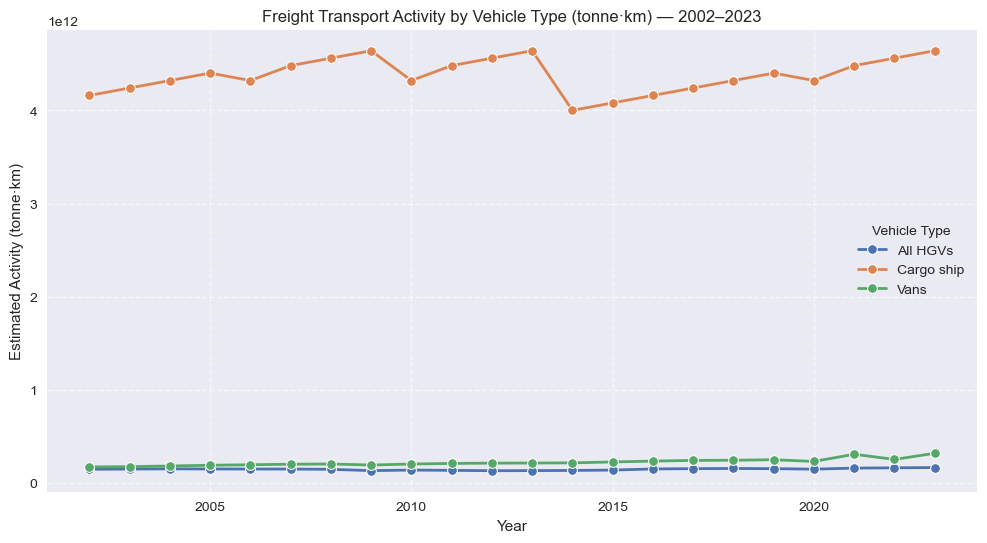

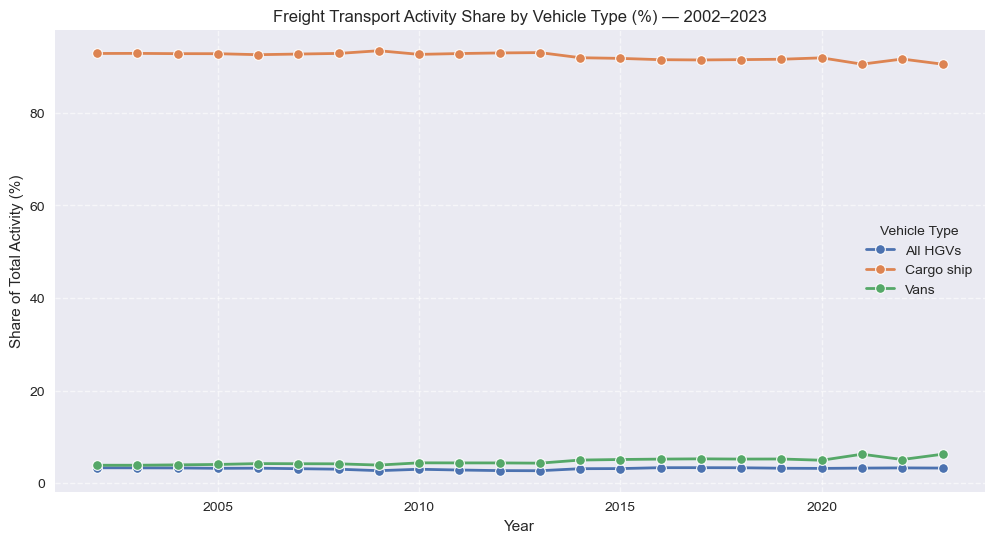

,Year,Vehicle Type,Estimated Activity (tonne.km),% Share
0,2002,All HGVs,1.490000e+11,3.323964
1,2002,Cargo ship,4.160000e+12,92.803284
2,2002,Vans,1.736000e+11,3.872752
3,2003,All HGVs,1.510000e+11,3.305749
4,2003,Cargo ship,4.240000e+12,92.823679
5,2003,Vans,1.768000e+11,3.870572
6,2004,All HGVs,1.530000e+11,3.285377
7,2004,Cargo ship,4.320000e+12,92.763582
8,2004,Vans,1.840000e+11,3.951041
9,2005,All HGVs,1.520000e+11,3.204317


In [ ]:
# ============================================================
# Cell 14 — Freight Transport Activity by Vehicle Type
# ============================================================
# Purpose:
# - Tracks freight activity (tonne·km) for:
#     • HGV = Average laden.
#     • Vans = Average ≤3.5t.
#     • Cargo ship = all.
# - Window: 2002–2023.
# Outputs:
# - activity_abs: tidy table with both absolute values and % shares.
# - Line chart 1: Absolute activity (tonne·km).
# - Line chart 2: Share of total activity (%).
# Notes:
# - Absolute chart shows total demand growth/decline over time.
# - Share chart highlights modal shifts (e.g., road vs maritime).
# - Clean handling: true absences set to zero so yearly shares always sum to 100%.
# ============================================================
# 1) Build clean per-year activity series
hgv_act = (df.loc[mask_hgv_avg]
             .groupby('Year')['Estimated Activity (tonne.km)']
             .sum().reindex(years_hist).rename('All HGVs'))

vans_act = (df.loc[mask_vans_avg]
              .groupby('Year')['Estimated Activity (tonne.km)']
              .sum().reindex(years_hist).rename('Vans'))

ships_act = (df[df['Vehicle Type'] == 'Cargo ship']
               .groupby('Year')['Estimated Activity (tonne.km)']
               .sum().reindex(years_hist).rename('Cargo ship'))
# Combine to long, fill true absences with 0 (so shares sum to 100% every year)
activity_abs = (pd.concat([hgv_act, vans_act, ships_act], axis=1)
                  .fillna(0)
                  .reset_index()
                  .melt(id_vars='Year', var_name='Vehicle Type',
                        value_name='Estimated Activity (tonne.km)')
                  .sort_values(['Year','Vehicle Type'])
                  .reset_index(drop=True))
# 2) % share per year
total_activity_per_year = activity_abs.groupby('Year')['Estimated Activity (tonne.km)'].transform('sum')
# avoid divide-by-zero edge case
activity_abs['% Share'] = np.where(
    total_activity_per_year > 0,
    activity_abs['Estimated Activity (tonne.km)'] / total_activity_per_year * 100,
    np.nan
)
# 3) Plot absolute activity
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=activity_abs,
    x='Year', y='Estimated Activity (tonne.km)',
    hue='Vehicle Type', marker='o', linewidth=2
)
plt.title("Freight Transport Activity by Vehicle Type (tonne·km) — 2002–2023")
plt.xlabel("Year"); plt.ylabel("Estimated Activity (tonne·km)")
plt.legend(title="Vehicle Type"); plt.grid(True, linestyle='--', alpha=0.6)
plt.show()
# 4) Plot percentage share
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=activity_abs,
    x='Year', y='% Share',
    hue='Vehicle Type', marker='o', linewidth=2
)
plt.title("Freight Transport Activity Share by Vehicle Type (%) — 2002–2023")
plt.xlabel("Year"); plt.ylabel("Share of Total Activity (%)")
plt.legend(title="Vehicle Type"); plt.grid(True, linestyle='--', alpha=0.6)
plt.show()
# 5) Display table
display(activity_abs.head(15))


Correlation computed on 324 rows (after numeric coercion & NA drop).


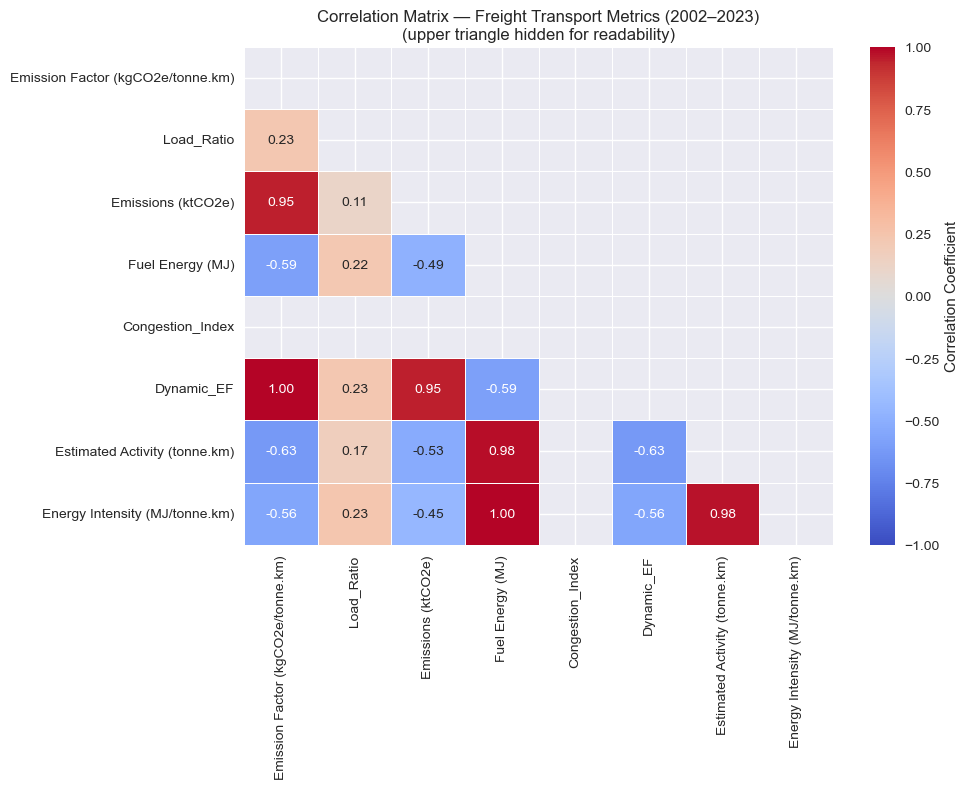

,Emission Factor (kgCO2e/tonne.km),Load_Ratio,Emissions (ktCO2e),Fuel Energy (MJ),Congestion_Index,Dynamic_EF,Estimated Activity (tonne.km),Energy Intensity (MJ/tonne.km)
Emission Factor (kgCO2e/tonne.km),1.000,0.233,0.946,-0.590,NaN,1.000,-0.629,-0.555
Load_Ratio,0.233,1.000,0.110,0.223,NaN,0.233,0.168,0.234
Emissions (ktCO2e),0.946,0.110,1.000,-0.488,NaN,0.946,-0.530,-0.452
Fuel Energy (MJ),-0.590,0.223,-0.488,1.000,NaN,-0.590,0.981,0.998
Congestion_Index,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Dynamic_EF,1.000,0.233,0.946,-0.590,NaN,1.000,-0.629,-0.555
Estimated Activity (tonne.km),-0.629,0.168,-0.530,0.981,NaN,-0.629,1.000,0.976
Energy Intensity (MJ/tonne.km),-0.555,0.234,-0.452,0.998,NaN,-0.555,0.976,1.000


In [ ]:
# ============================================================
# Cell 15 — Correlation Matrix (robust, 2002–2023)
# ============================================================
# Purpose:
# - Examines statistical relationships among key numeric freight metrics.
# - Correlation computed only for available columns in df (2002–2023).
# Inputs:
# - Candidate variables:
#     • Emission Factor (kgCO2e/tonne.km)
#     • Load_Ratio
#     • Emissions (ktCO2e)
#     • Fuel Energy (MJ)
#     • Congestion_Index
#     • Dynamic_EF
#     • Estimated Activity (tonne.km)
#     • Energy Intensity (MJ/tonne.km)
# Outputs:
# - corr_df: Pearson correlation matrix (rounded 3 dp).
# - Heatmap (lower-triangle only) for readability.
# Notes:
# - Drops rows with NA across candidate columns.
# - Prints number of rows used after cleaning.
# - Warns if candidate columns are missing in df.
# - Strong positive/negative values highlight potential drivers of emissions.
# ============================================================
import numpy as np
# 1) Candidate numeric columns
numeric_cols = [
    'Emission Factor (kgCO2e/tonne.km)',
    'Load_Ratio',
    'Emissions (ktCO2e)',
    'Fuel Energy (MJ)',
    'Congestion_Index',
    'Dynamic_EF',
    'Estimated Activity (tonne.km)',
    'Energy Intensity (MJ/tonne.km)'
]
# Keep only those that exist
available_cols = [c for c in numeric_cols if c in df.columns]
missing_cols = [c for c in numeric_cols if c not in df.columns]
if missing_cols:
    print("Note: missing columns excluded from correlation:", missing_cols)
# 2) Coerce to numeric and drop rows with NA in these cols
corr_input = df[available_cols].apply(pd.to_numeric, errors='coerce').dropna(how='any')
n_used = len(corr_input)
print(f"Correlation computed on {n_used} rows (after numeric coercion & NA drop).")
# Guard: require at least 2 columns
assert len(available_cols) >= 2, "Need at least two numeric columns for correlation."
# 3) Correlation matrix (Pearson)
corr_df = corr_input.corr(method='pearson')
# 4) Plot upper-triangle heatmap
mask = np.triu(np.ones_like(corr_df, dtype=bool))  # mask upper triangle? (True hides)
# I actually want to SHOW lower triangle and hide upper, so use mask on upper:
plt.figure(figsize=(10, 8))
sns.heatmap(
    corr_df,
    mask=mask,
    annot=True,
    cmap='coolwarm',
    fmt=".2f",
    linewidths=0.5,
    cbar_kws={'label': 'Correlation Coefficient'},
    vmin=-1, vmax=1
)
plt.title("Correlation Matrix — Freight Transport Metrics (2002–2023)\n(upper triangle hidden for readability)")
plt.tight_layout()
plt.show()

display(corr_df.round(3))


Forecast

In [84]:
# ============================================
# Cell F0 — Forecast Setup & Helpers (2002–2023 → 2050)
# ============================================
# Purpose:
# - Prepares the modelling environment for freight emissions/activity forecasting.
# - Defines reusable helper functions for Linear, Polynomial (3rd degree),
#   and Logistic (3-parameter) fits.
# - Establishes evaluation metrics (R², RMSE, MAE) with NaN-safe handling.
#
# Inputs:
# - Historical data window: 2002–2023 (from df).
# - Forecast horizon: 2024–2050.
#
# Outputs / Helpers:
# - Logistic model function: logistic_3p (K, r, t0).
# - fit_predict_* functions for each model type.
# - metrics() utility for comparing fitted vs observed values.
# - years_hist and years_fut arrays for later cells.
#
# Notes:
# - Encodes year t relative to YEAR_MIN for stable fitting.
# - Provides robust initial guesses for logistic curve fitting to reduce failures.
# - Prints summary of historical vs forecast ranges for clarity.
# ============================================


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from scipy.optimize import curve_fit

# ----- time anchors (prefer years_hist if already defined) -----
try:
    YEAR_MIN = int(np.min(years_hist))
    YEAR_MAX = int(np.max(years_hist))
except NameError:
    YEAR_MIN, YEAR_MAX = 2002, 2023  # fallback if years_hist isn't defined yet

FCAST_START = YEAR_MAX + 1          # 2024
FCAST_END   = 2050

def to_t(year_array):
    """Encode years relative to YEAR_MIN (e.g., 2002→0)."""
    return np.asarray(year_array, dtype=float) - YEAR_MIN

# ----- models -----
# 3-parameter logistic (upper asymptote K, growth r, midpoint t0)
def logistic_3p(t, K, r, t0):
    t = np.asarray(t, dtype=float)
    return K / (1.0 + np.exp(-r * (t - t0)))

def fit_predict_linear(x_t, y, x_t_future):
    mdl = LinearRegression()
    X = x_t.reshape(-1, 1)
    Xf = x_t_future.reshape(-1, 1)
    mdl.fit(X, y)
    y_in  = mdl.predict(X)
    y_fut = mdl.predict(Xf)
    return y_in, y_fut, mdl

def fit_predict_poly(x_t, y, x_t_future, degree=3):
    poly = PolynomialFeatures(degree=degree, include_bias=False)
    X  = poly.fit_transform(x_t.reshape(-1,1))
    Xf = poly.transform(x_t_future.reshape(-1,1))
    mdl = LinearRegression()
    mdl.fit(X, y)
    y_in  = mdl.predict(X)
    y_fut = mdl.predict(Xf)
    return y_in, y_fut, (mdl, poly, degree)

def fit_predict_logistic(x_t, y, x_t_future):
    # robust-ish initial guesses from data scale
    x_t = np.asarray(x_t, dtype=float)
    y   = np.asarray(y,   dtype=float)

    K0 = np.nanmax(y) * 1.2 if np.isfinite(y).any() else 1.0
    slope = np.polyfit(x_t, y, 1)[0] if len(x_t) >= 2 else 0.05
    r0 = 0.05 if slope >= 0 else -0.05
    t00 = np.nanmedian(x_t)
    bounds = ([0.0, -1.0, np.nanmin(x_t)-20], [np.inf, 1.0, np.nanmax(x_t)+20])

    try:
        popt, _ = curve_fit(logistic_3p, x_t, y, p0=[K0, r0, t00],
                            bounds=bounds, maxfev=20000)
        y_in  = logistic_3p(x_t,        *popt)
        y_fut = logistic_3p(x_t_future, *popt)
        meta = {"params": {"K": popt[0], "r": popt[1], "t0": popt[2]}}
    except Exception:
        y_in  = np.full_like(x_t,        np.nan, dtype=float)
        y_fut = np.full_like(x_t_future, np.nan, dtype=float)
        meta = {"params": None}
    return y_in, y_fut, meta

# ----- metrics -----
def metrics(y_true, y_hat):
    """NaN-safe metrics on overlapping finite points."""
    y_true = np.asarray(y_true, dtype=float)
    y_hat  = np.asarray(y_hat,  dtype=float)
    mask = np.isfinite(y_true) & np.isfinite(y_hat)
    if mask.sum() >= 2:
        return {
            "R2":   float(r2_score(y_true[mask], y_hat[mask])),
            "RMSE": float(mean_squared_error(y_true[mask], y_hat[mask], squared=False)),
            "MAE":  float(mean_absolute_error(y_true[mask], y_hat[mask]))
        }
    return {"R2": np.nan, "RMSE": np.nan, "MAE": np.nan}

# ----- convenience year arrays for next cells -----
years_hist = np.arange(YEAR_MIN, YEAR_MAX + 1)   # 2002..2023
years_fut  = np.arange(FCAST_START, FCAST_END+1) # 2024..2050

print(f"History: {YEAR_MIN}–{YEAR_MAX}  ({len(years_hist)} yrs) | Forecast: {FCAST_START}–{FCAST_END}")


History: 2002–2023  (22 yrs) | Forecast: 2024–2050


In [85]:
# ============================================
# Cell F1 — Build Target Series (2002–2023)
# ============================================
# Purpose:
# - Prepares the CLEAN target variables for forecasting.
# - Builds two aligned series for 2002–2023:
#   (A) y_emis_all → total freight emissions (ktCO2e)
#   (B) y_ei_all   → activity-weighted Energy Intensity (MJ/t·km)
#
# How it works:
# 1. Defines modelling subset to avoid double counting:
#    • HGV = "Average laden"
#    • Vans = "Average ≤3.5t"
#    • Cargo ships = all rows
# 2. Aggregates emissions per year (ktCO2e).
# 3. Computes activity-weighted Energy Intensity (EI) per year.
#    • Weight = Estimated Activity (tonne.km)
#    • If missing years → fills by linear interpolation.
# 4. Assembles a tidy table (ts_all) for validation.
# 5. Encodes years into numeric t_hist (2002–2023) & t_fut (2024–2050).
# 6. Exports final numpy arrays:
#    • y_emis_all for emission models
#    • y_ei_all for EI models
#
# Outputs:
# - ts_all (dataframe with emissions + EI per year)
# - y_emis_all, y_ei_all (numpy arrays for modelling)
# - t_hist, t_fut (time axes for fitting & forecasting)
# ============================================


# Build the modelling subset to avoid double counting:
#   HGV = Average laden only
#   Vans = Average (≤3.5t) only
#   Cargo ship = all rows
df_model = pd.concat([
    df.loc[mask_hgv_avg],
    df.loc[mask_vans_avg],
    df[df['Vehicle Type'] == 'Cargo ship']
], ignore_index=True)

# A) Total emissions per year (ktCO2e)
emissions_all = (
    df_model.groupby('Year', as_index=True)['Emissions (ktCO2e)']
            .sum()
            .reindex(years_hist, fill_value=0.0)
            .astype(float)
)

# B) Activity-weighted EI per year (MJ/t·km)
def weighted_avg_ei(g):
    num = (g['Energy Intensity (MJ/tonne.km)'] * g['Estimated Activity (tonne.km)']).sum()
    den = g['Estimated Activity (tonne.km)'].sum()
    return np.nan if den == 0 else num / den

ei_weighted = (
    df_model.groupby('Year').apply(weighted_avg_ei)
            .reindex(years_hist)
)

# If any year is missing (NaN), interpolate across the 2002–2023 span
if ei_weighted.isna().any():
    missing = ei_weighted[ei_weighted.isna()].index.tolist()
    print(f"Note: EI missing for years {missing}; linearly interpolating.")
    ei_weighted = ei_weighted.interpolate(limit_direction='both')

ei_all = ei_weighted.astype(float)

# Assemble tidy table for sanity-check
ts_all = pd.DataFrame({
    'Emissions_All_ktCO2e': emissions_all,
    'EI_All_MJ_per_tkm': ei_all
})
ts_all.index.name = 'Year'

display(ts_all.head(5))
display(ts_all.tail(5))

# Time axes (from F0)
t_hist = to_t(years_hist)               # 2002..2023 encoded from YEAR_MIN
t_fut  = to_t(years_fut)                # 2024..2050 encoded from YEAR_MIN

# Numpy targets for modelling
y_emis_all = ts_all['Emissions_All_ktCO2e'].values.astype(float)
y_ei_all   = ts_all['EI_All_MJ_per_tkm'].values.astype(float)

print(f"Targets built: y_emis_all={y_emis_all.shape}, y_ei_all={y_ei_all.shape}")


C:\Users\User\AppData\Local\Temp\ipykernel_43064\1544496332.py:57: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_model.groupby('Year').apply(weighted_avg_ei)


,Emissions_All_ktCO2e,EI_All_MJ_per_tkm
Year,,
2002,167465.0,34.935895
2003,171703.1,34.943700
2004,175919.2,34.922003
2005,181270.5,34.921044
2006,183913.7,34.844965


,Emissions_All_ktCO2e,EI_All_MJ_per_tkm
Year,,
2019,225799.3,34.496516
2020,210017.6,34.603183
2021,236012.1,34.101507
2022,224638.2,34.510288
2023,236392.7,34.099193


Targets built: y_emis_all=(22,), y_ei_all=(22,)


c:\Users\User\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\User\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\User\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


,R2,RMSE,MAE
Model,,,
Polynomial(d=3),0.857,7473.281,5628.957
Logistic,0.813,8559.006,5843.626
Linear,0.808,8682.663,5885.804


c:\Users\User\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


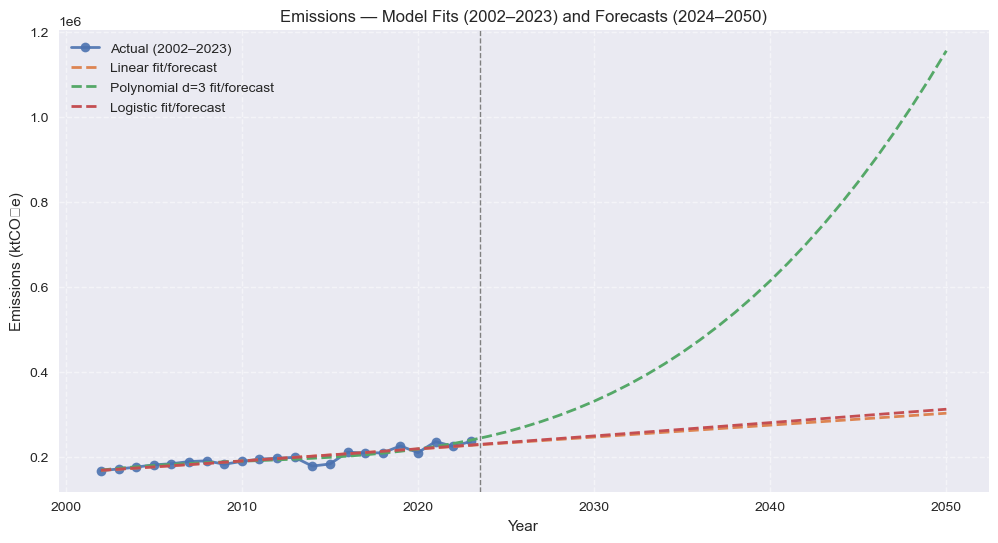

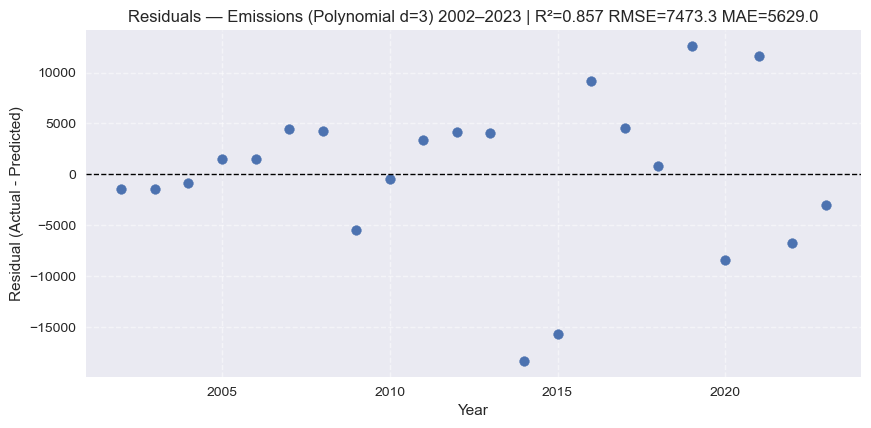

2030: Linear=246,663 | Poly d3=330,885 | Logistic=249,313
2040: Linear=274,698 | Poly d3=614,216 | Logistic=280,603
2050: Linear=302,733 | Poly d3=1,155,302 | Logistic=312,115


In [86]:
# ============================================
# Cell F2 — Emissions models (2002–2023 → 2050)
# ============================================
# Purpose:
# - Fit three models to total freight emissions (y_emis_all):
#   • Linear, • Polynomial (degree 3), • Logistic (3-parameter).
# - Generate in-sample fits (2002–2023) and forecasts (2024–2050).
# - Compare models with R², RMSE, MAE; visualise fits vs actuals.
#
# Steps:
# 1) Fit Linear, Poly(d=3), Logistic; store in results_emis_all.
# 2) Build a metrics table (sorted by RMSE) for quick comparison.
# 3) Plot actuals + each model’s fit/forecast on one chart.
# 4) Show residuals for the chosen baseline (Poly d=3 per methodology).
# 5) Print 2030/2040/2050 forecast snapshots for a quick sanity check.
#
# Outputs:
# - results_emis_all: dict with in_sample, forecast, metrics, meta.
# - metrics_emis_all: comparison table of model performance.
# - Fit/forecast chart + residuals plot for Poly d=3.
#
# Notes:
# - Logistic can fail on some series; code guards by skipping if NaNs.
# - Residual plot helps check bias/structure (non-random patterns).
# - This cell sets up the model choice I’ll carry into scenarios.
# ============================================


results_emis_all = {}

# --- Linear ---
lin_in, lin_fut, lin_mdl = fit_predict_linear(t_hist, y_emis_all, t_fut)
results_emis_all['Linear'] = {
    'in_sample': lin_in,
    'forecast' : lin_fut,
    'metrics'  : metrics(y_emis_all, lin_in),
    'meta'     : {'model': 'Linear'}
}

# --- Polynomial (degree = 3) ---
p_in, p_fut, p_meta = fit_predict_poly(t_hist, y_emis_all, t_fut, degree=3)
results_emis_all['Polynomial(d=3)'] = {
    'in_sample': p_in,
    'forecast' : p_fut,
    'metrics'  : metrics(y_emis_all, p_in),
    'meta'     : {'model': 'Polynomial', 'details': p_meta}
}

# --- Logistic (3-parameter) ---
log_in, log_fut, log_meta = fit_predict_logistic(t_hist, y_emis_all, t_fut)
results_emis_all['Logistic'] = {
    'in_sample': log_in,
    'forecast' : log_fut,
    'metrics'  : metrics(y_emis_all, log_in),
    'meta'     : {'model': 'Logistic', **log_meta}
}

# --- Metrics table ---
metrics_emis_all = []
for name, out in results_emis_all.items():
    row = out['metrics'].copy()
    row['Model'] = name
    metrics_emis_all.append(row)

metrics_emis_all = (pd.DataFrame(metrics_emis_all)
                    .set_index('Model')
                    .sort_values('RMSE'))
display(metrics_emis_all.round(3))

# --- Quick fit/forecast plot ---
years_all = np.concatenate([years_hist, years_fut])
actual_series = np.concatenate([y_emis_all, np.full(len(years_fut), np.nan)])

df_plot = pd.DataFrame({'Year': years_all,
                        'Actual': actual_series,
                        'Linear': np.concatenate([lin_in, lin_fut]),
                        'Poly_d3': np.concatenate([p_in, p_fut])})

# Logistic may fail (NaNs). Add only if it have finite values.
if np.isfinite(log_in).any():
    df_plot['Logistic'] = np.concatenate([log_in, log_fut])

plt.figure(figsize=(12,6))
plt.plot(df_plot['Year'], df_plot['Actual'], 'o-', label='Actual (2002–2023)', linewidth=2, alpha=0.9)
plt.plot(df_plot['Year'], df_plot['Linear'], '--', label='Linear fit/forecast', linewidth=2)
plt.plot(df_plot['Year'], df_plot['Poly_d3'], '--', label='Polynomial d=3 fit/forecast', linewidth=2)
if 'Logistic' in df_plot.columns:
    plt.plot(df_plot['Year'], df_plot['Logistic'], '--', label='Logistic fit/forecast', linewidth=2)
plt.axvline(x=years_hist.max()+0.5, ls='--', c='gray', lw=1)
plt.title("Emissions — Model Fits (2002–2023) and Forecasts (2024–2050)")
plt.xlabel("Year"); plt.ylabel("Emissions (ktCO₂e)")
plt.grid(True, linestyle='--', alpha=0.5); plt.legend()
plt.show()

# --- Residuals for chosen baseline (Polynomial d=3 per methodology) ---
resid_poly = y_emis_all - p_in
m_poly = results_emis_all['Polynomial(d=3)']['metrics']

plt.figure(figsize=(10,4.5))
plt.scatter(years_hist, resid_poly)
plt.axhline(0, ls='--', c='k', lw=1)
plt.title(f"Residuals — Emissions (Polynomial d=3) 2002–2023 | R²={m_poly['R2']:.3f} RMSE={m_poly['RMSE']:.1f} MAE={m_poly['MAE']:.1f}")
plt.xlabel("Year"); plt.ylabel("Residual (Actual - Predicted)")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

# --- Snapshot of selected forecast years (sanity) ---
for yr in [2030, 2040, 2050]:
    lin_v  = df_plot.loc[df_plot['Year']==yr, 'Linear'].values[0]
    poly_v = df_plot.loc[df_plot['Year']==yr, 'Poly_d3'].values[0]
    msg = f"{yr}: Linear={lin_v:,.0f} | Poly d3={poly_v:,.0f}"
    if 'Logistic' in df_plot.columns:
        log_v = df_plot.loc[df_plot['Year']==yr, 'Logistic'].values[0]
        msg += f" | Logistic={log_v:,.0f}"
    print(msg)


c:\Users\User\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\User\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\User\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


,R2,RMSE,MAE
Model,,,
Polynomial(d=3),0.7807,0.1338,0.1136
Logistic,0.6738,0.1632,0.1359
Linear,0.6737,0.1633,0.1359


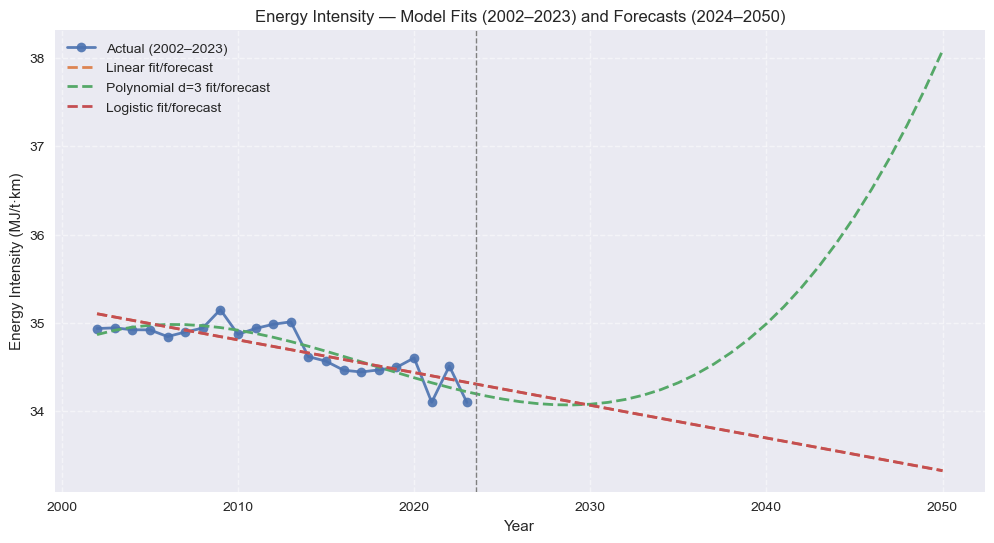

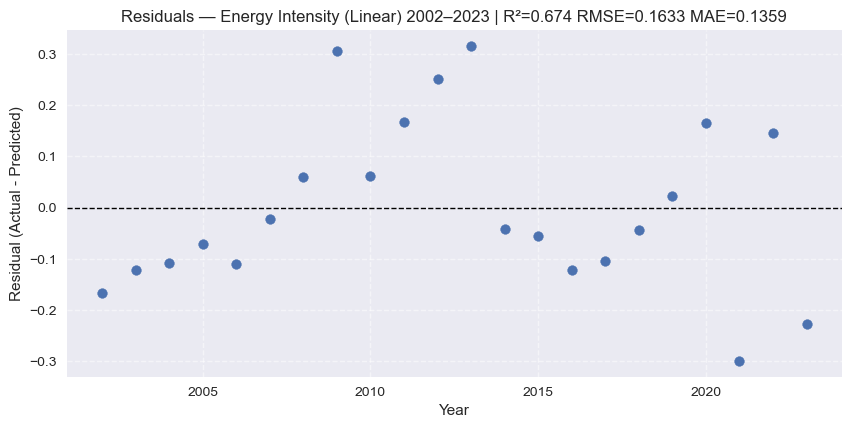

2030: Linear=34.068 | Poly d3=34.080 | Logistic=34.067
2040: Linear=33.698 | Poly d3=34.990 | Logistic=33.697
2050: Linear=33.328 | Poly d3=38.080 | Logistic=33.327


In [87]:
# ============================================
# Cell F3 — Energy Intensity models (2002–2023 → 2050)
# ============================================
# Purpose:
# - Model the total freight Energy Intensity (y_ei_all, MJ/t·km) using:
#   • Linear (baseline), • Polynomial (degree 3), • Logistic (3-parameter).
# - Produce in-sample fits (2002–2023) and forecasts (2024–2050).
# - Compare model accuracy with R², RMSE, MAE; visualise fits vs actuals.
#
# Steps:
# 1) Fit Linear / Poly(d=3) / Logistic; store outputs in results_ei_all.
# 2) Build metrics table (sorted by RMSE) for quick model comparison.
# 3) Plot actual EI with each model’s fit/forecast on one figure.
# 4) Show residuals for the baseline (Linear) to check bias/structure.
# 5) Print EI snapshots for 2030, 2040, 2050 as a sanity check.
#
# Outputs:
# - results_ei_all: dict with in_sample, forecast, metrics, meta for each model.
# - metrics_ei_all: model comparison table.
# - Fit/forecast chart + Linear residuals plot.
#
# Notes:
# - Linear is the baseline for EI to avoid overfitting and reflect gradual
#   efficiency trends; Poly/Logistic are included for robustness checks.
# - Logistic may return NaNs if the data don’t support S-curve fitting; guarded.
# - Residual inspection helps validate baseline choice before scenario work.
# ============================================


results_ei_all = {}

# --- Linear (baseline) ---
ei_lin_in, ei_lin_fut, ei_lin_mdl = fit_predict_linear(t_hist, y_ei_all, t_fut)
results_ei_all['Linear'] = {
    'in_sample': ei_lin_in,
    'forecast' : ei_lin_fut,
    'metrics'  : metrics(y_ei_all, ei_lin_in),
    'meta'     : {'model': 'Linear'}
}

# --- Polynomial (degree = 3) ---
ei_p_in, ei_p_fut, ei_p_meta = fit_predict_poly(t_hist, y_ei_all, t_fut, degree=3)
results_ei_all['Polynomial(d=3)'] = {
    'in_sample': ei_p_in,
    'forecast' : ei_p_fut,
    'metrics'  : metrics(y_ei_all, ei_p_in),
    'meta'     : {'model': 'Polynomial', 'details': ei_p_meta}
}

# --- Logistic (3-parameter) ---
ei_log_in, ei_log_fut, ei_log_meta = fit_predict_logistic(t_hist, y_ei_all, t_fut)
results_ei_all['Logistic'] = {
    'in_sample': ei_log_in,
    'forecast' : ei_log_fut,
    'metrics'  : metrics(y_ei_all, ei_log_in),
    'meta'     : {'model': 'Logistic', **ei_log_meta}
}

# --- Metrics table ---
metrics_ei_all = []
for name, out in results_ei_all.items():
    row = out['metrics'].copy()
    row['Model'] = name
    metrics_ei_all.append(row)

metrics_ei_all = (pd.DataFrame(metrics_ei_all)
                  .set_index('Model')
                  .sort_values('RMSE'))
display(metrics_ei_all.round(4))

# --- Quick fit/forecast plot ---
years_all = np.concatenate([years_hist, years_fut])
actual_ei = np.concatenate([y_ei_all, np.full(len(years_fut), np.nan)])

df_ei_plot = pd.DataFrame({
    'Year': years_all,
    'Actual': actual_ei,
    'Linear': np.concatenate([ei_lin_in, ei_lin_fut]),
    'Poly_d3': np.concatenate([ei_p_in, ei_p_fut]),
})

# Add Logistic if not all NaN
if np.isfinite(ei_log_in).any():
    df_ei_plot['Logistic'] = np.concatenate([ei_log_in, ei_log_fut])

plt.figure(figsize=(12,6))
plt.plot(df_ei_plot['Year'], df_ei_plot['Actual'], 'o-', label='Actual (2002–2023)', linewidth=2, alpha=0.9)
plt.plot(df_ei_plot['Year'], df_ei_plot['Linear'], '--', label='Linear fit/forecast', linewidth=2)
plt.plot(df_ei_plot['Year'], df_ei_plot['Poly_d3'], '--', label='Polynomial d=3 fit/forecast', linewidth=2)
if 'Logistic' in df_ei_plot.columns:
    plt.plot(df_ei_plot['Year'], df_ei_plot['Logistic'], '--', label='Logistic fit/forecast', linewidth=2)
plt.axvline(x=years_hist.max()+0.5, ls='--', c='gray', lw=1)
plt.title("Energy Intensity — Model Fits (2002–2023) and Forecasts (2024–2050)")
plt.xlabel("Year"); plt.ylabel("Energy Intensity (MJ/t·km)")
plt.grid(True, linestyle='--', alpha=0.5); plt.legend()
plt.show()

# --- Residuals for baseline (Linear) ---
resid_ei_lin = y_ei_all - ei_lin_in
m_lin = results_ei_all['Linear']['metrics']

plt.figure(figsize=(10,4.5))
plt.scatter(years_hist, resid_ei_lin)
plt.axhline(0, ls='--', c='k', lw=1)
plt.title(f"Residuals — Energy Intensity (Linear) 2002–2023 | R²={m_lin['R2']:.3f} RMSE={m_lin['RMSE']:.4f} MAE={m_lin['MAE']:.4f}")
plt.xlabel("Year"); plt.ylabel("Residual (Actual - Predicted)")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

# --- Snapshot of selected forecast years (sanity) ---
for yr in [2030, 2040, 2050]:
    lin_v  = df_ei_plot.loc[df_ei_plot['Year']==yr, 'Linear'].values[0]
    poly_v = df_ei_plot.loc[df_ei_plot['Year']==yr, 'Poly_d3'].values[0]
    msg = f"{yr}: Linear={lin_v:,.3f} | Poly d3={poly_v:,.3f}"
    if 'Logistic' in df_ei_plot.columns:
        log_v = df_ei_plot.loc[df_ei_plot['Year']==yr, 'Logistic'].values[0]
        msg += f" | Logistic={log_v:,.3f}"
    print(msg)


C:\Users\User\AppData\Local\Temp\ipykernel_43064\2442504646.py:44: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from current font.
  plt.tight_layout()
c:\Users\User\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


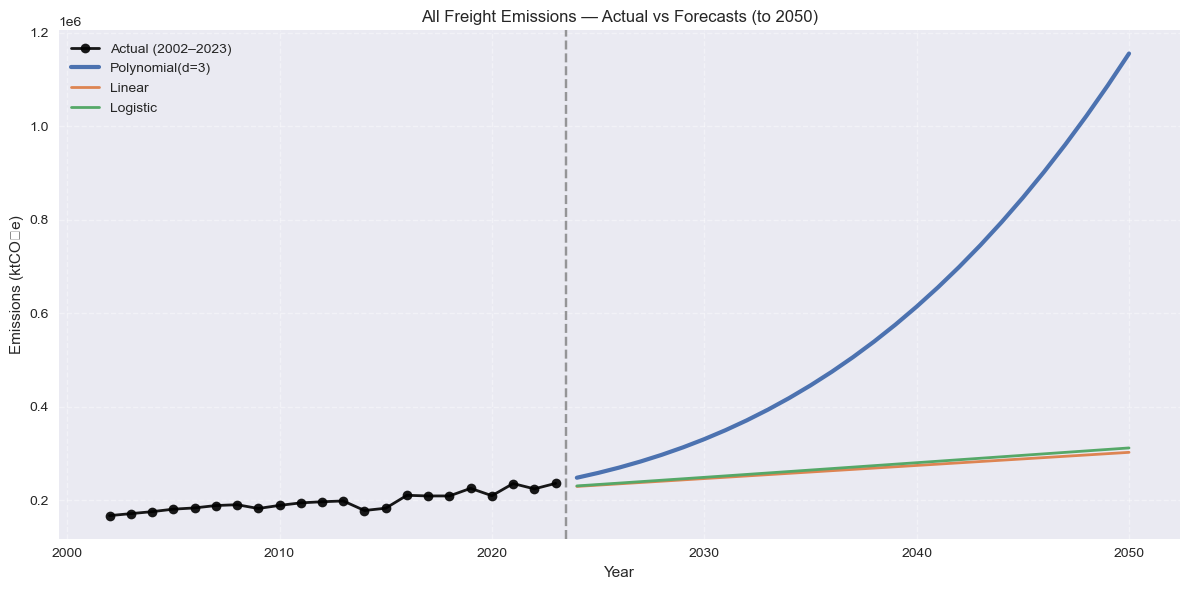

In [88]:
# ============================================
# Cell F4 — Emissions: Actual vs Forecasts (to 2050)
# ============================================
# Purpose:
# - Visualise total freight emissions history (2002–2023) against
#   model forecasts (2024–2050) from:
#     • Polynomial (degree 3)
#     • Linear
#     • Logistic (if finite)
#
# What this shows:
# - Solid points/line = observed emissions (y_emis_all).
# - Forecast lines start after a vertical separator at 2023.
# - Compares model trajectories on the same axes for readability.
#
# Notes:
# - Logistic curve is plotted only if the fit produced finite values.
# - Use this figure to reference model behaviour (trend, curvature)
#   before selecting the baseline for scenarios.
# ============================================


plt.figure(figsize=(12,6))

# Actuals (2002–2023)
plt.plot(years_hist, y_emis_all, 'o-', label='Actual (2002–2023)', color='black', linewidth=2, alpha=0.9)

# Forecasts (2024–2050)
plt.plot(years_fut, results_emis_all['Polynomial(d=3)']['forecast'], '-', linewidth=3, label='Polynomial(d=3)')
plt.plot(years_fut, results_emis_all['Linear']['forecast'], '-', linewidth=2, label='Linear')

# Logistic may fail; only plot if finite
log_fut = results_emis_all.get('Logistic', {}).get('forecast', None)
if log_fut is not None and np.isfinite(log_fut).any():
    plt.plot(years_fut, log_fut, '-', linewidth=2, label='Logistic')

# Vertical line separating history and forecast
plt.axvline(x=years_hist.max()+0.5, linestyle='--', color='gray', alpha=0.8)

plt.title('All Freight Emissions — Actual vs Forecasts (to 2050)')
plt.xlabel('Year'); plt.ylabel('Emissions (ktCO₂e)')
plt.grid(True, linestyle='--', alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()


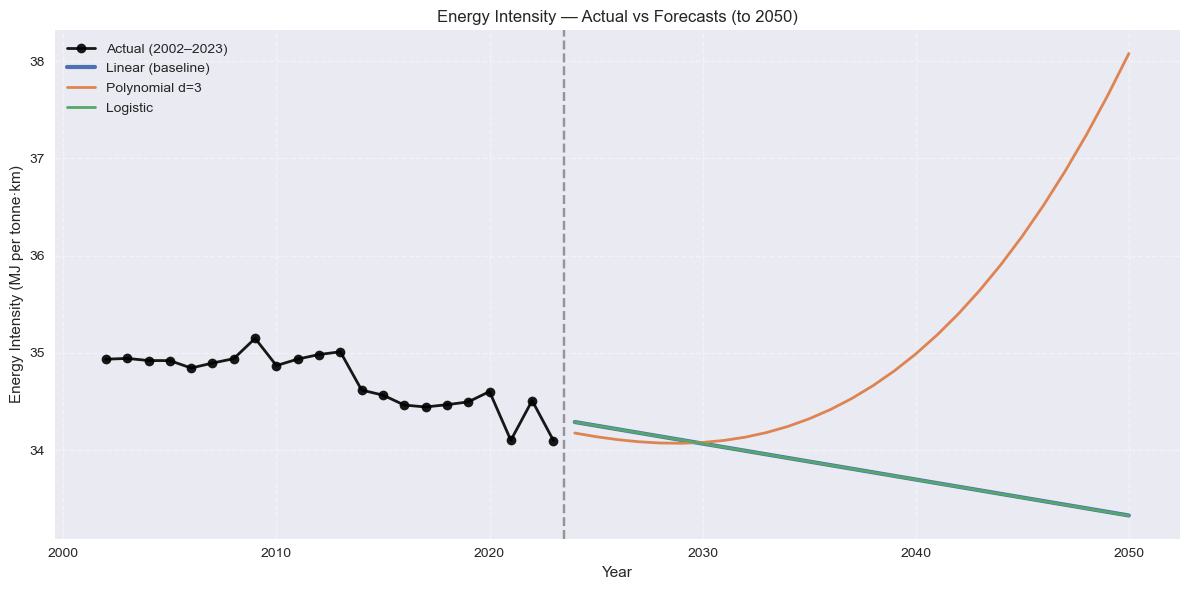

In [89]:
# ============================================
# Cell F5 — Energy Intensity: Actual vs Forecasts (to 2050)
# ============================================
# Purpose:
# - Visualise historical Energy Intensity (2002–2023) against model
#   forecasts (2024–2050) for:
#     • Linear (baseline)
#     • Polynomial (degree 3)
#     • Logistic (3-parameter, if finite)
#
# What this shows:
# - Black line/markers = observed EI (y_ei_all).
# - Forecast lines begin after the vertical delimiter at 2023.
# - Side-by-side comparison of model trajectories to assess trend and curvature.
#
# Notes:
# - Logistic is plotted only if the fit returned finite values.
# - Use this figure to justify Linear as the EI baseline (stability,
#   parsimony) while showing Poly/Logistic as robustness checks.
# ============================================


plt.figure(figsize=(12,6))

# Actuals (2002–2023)
plt.plot(years_hist, y_ei_all, 'o-', label='Actual (2002–2023)', color='black', linewidth=2, alpha=0.9)

# Forecasts (2024–2050)
plt.plot(years_fut, results_ei_all['Linear']['forecast'], '-', linewidth=3, label='Linear (baseline)')
plt.plot(years_fut, results_ei_all['Polynomial(d=3)']['forecast'], '-', linewidth=2, label='Polynomial d=3')

# Logistic may fail; only plot if finite
ei_log_fut = results_ei_all.get('Logistic', {}).get('forecast', None)
if ei_log_fut is not None and np.isfinite(ei_log_fut).any():
    plt.plot(years_fut, ei_log_fut, '-', linewidth=2, label='Logistic')

# Vertical delimiter between history and forecast
plt.axvline(x=years_hist.max()+0.5, linestyle='--', color='gray', alpha=0.8)

plt.title('Energy Intensity — Actual vs Forecasts (to 2050)')
plt.xlabel('Year'); plt.ylabel('Energy Intensity (MJ per tonne·km)')
plt.grid(True, linestyle='--', alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()


C:\Users\User\AppData\Local\Temp\ipykernel_43064\3731346766.py:46: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from current font.
  plt.grid(True, linestyle='--', alpha=0.4); plt.legend(); plt.tight_layout(); plt.show()


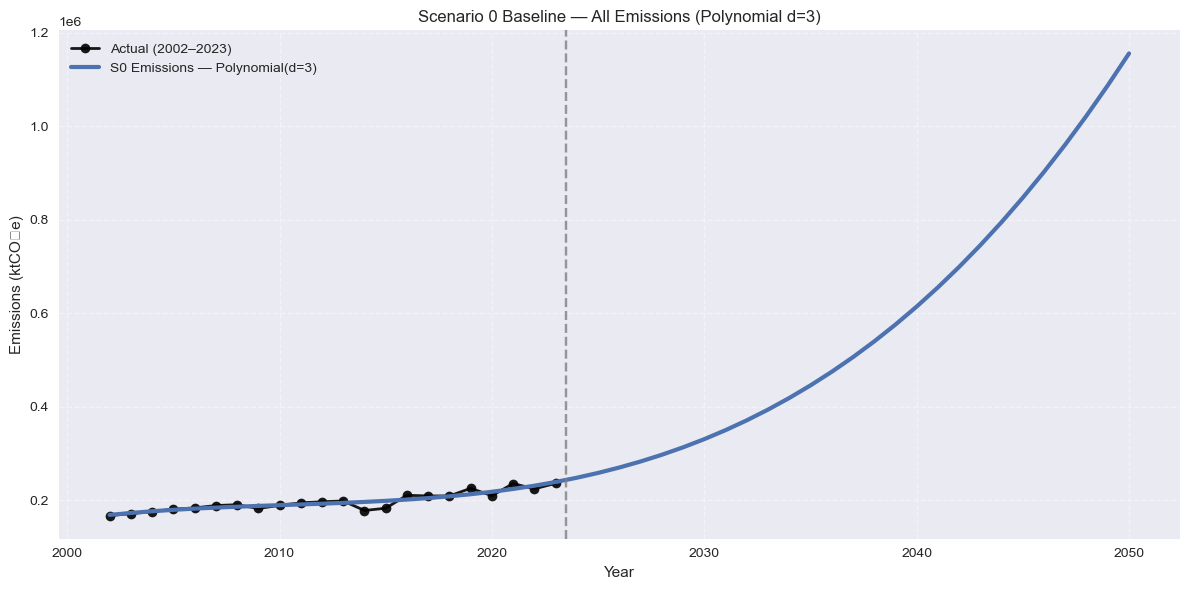

2002    168936.367866
2003    173170.872225
2004    176766.822530
2005    179811.140536
2006    182390.748000
Name: S0_Emissions_All_ktCO2e, dtype: float64

2046    9.023742e+05
2047    9.607403e+05
2048    1.022292e+06
2049    1.087117e+06
2050    1.155302e+06
Name: S0_Emissions_All_ktCO2e, dtype: float64

In [ ]:
# ============================================
# Cell F6 — Scenario 0 (S0) Emissions Baseline — Poly(d=3)
# ============================================
# Purpose:
# - Create a continuous baseline series (2002–2050) for total emissions
#   using the Polynomial (degree 3) model from F2.
# - Plot actuals (2002–2023) alongside the S0 baseline trajectory.
#
# Steps:
# 1) Guard that F2 has populated results_emis_all.
# 2) Concatenate in-sample fit (2002–2023) + forecast (2024–2050)
#    to form S0_emission_all.
# 3) Plot baseline vs actuals with a clear 2023 separator.
# 4) (Optional) Provide CSV export line for downstream use.
#
# Outputs:
# - S0_emission_all: pd.Series indexed 2002–2050 (ktCO2e).
# - Figure: Scenario 0 baseline vs actual emissions.
#
# Notes:
# - This baseline is used as the reference curve for all later scenarios (S1+).
# - Keep consistent units (ktCO2e) to align with scenario deltas and reporting.
# ============================================


# guards
assert 'Polynomial(d=3)' in results_emis_all, "Run F2 first to populate results_emis_all."

# Build S0 series for Emissions (ALL) using Polynomial(d=3)
S0_emission_all = pd.Series(
    np.concatenate([
        results_emis_all['Polynomial(d=3)']['in_sample'],
        results_emis_all['Polynomial(d=3)']['forecast']
    ]),
    index=np.concatenate([years_hist, years_fut]),
    name='S0_Emissions_All_ktCO2e'
)

# Plot S0 baseline
plt.figure(figsize=(12,6))
plt.plot(years_hist, y_emis_all, 'o-', color='black', label='Actual (2002–2023)', linewidth=2, alpha=0.9)
plt.plot(S0_emission_all.index, S0_emission_all.values, '-', linewidth=3, label='S0 Emissions — Polynomial(d=3)')
plt.axvline(x=years_hist.max()+0.5, linestyle='--', color='gray', alpha=0.8)
plt.title('Scenario 0 Baseline — All Emissions (Polynomial d=3)')
plt.xlabel('Year'); plt.ylabel('Emissions (ktCO₂e)')
plt.grid(True, linestyle='--', alpha=0.4); plt.legend(); plt.tight_layout(); plt.show()

display(S0_emission_all.head(5))
display(S0_emission_all.tail(5))



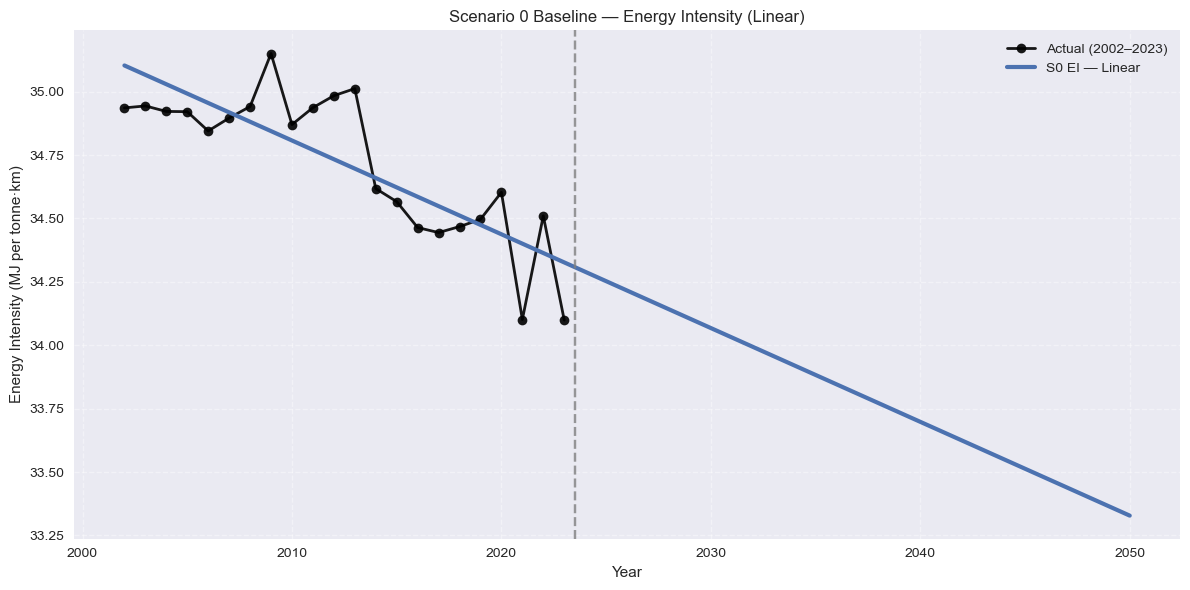

2002    35.103220
2003    35.066245
2004    35.029269
2005    34.992294
2006    34.955318
Name: S0_EI_MJ_per_tkm, dtype: float64

2046    33.476294
2047    33.439318
2048    33.402343
2049    33.365367
2050    33.328392
Name: S0_EI_MJ_per_tkm, dtype: float64

In [ ]:
# ============================================
# Cell F7 — Scenario 0 (S0) Energy Intensity Baseline — Linear
# ============================================
# Purpose:
# - Build the continuous baseline series (2002–2050) for Energy Intensity
#   using the Linear model from F3 (baseline choice).
# - Plot observed EI (2002–2023) alongside the S0 baseline.
#
# Steps:
# 1) Guard that F3 populated results_ei_all.
# 2) Concatenate in-sample fit (2002–2023) + forecast (2024–2050)
#    into S0_EI (MJ per tonne·km).
# 3) Plot S0_EI vs actuals with a 2023 separator for clarity.
# 4) (Optional) CSV export line provided for downstream use.
#
# Outputs:
# - S0_EI: pd.Series indexed 2002–2050 (MJ per tonne·km).
# - Figure: Scenario 0 EI baseline vs observed EI.
#
# Notes:
# - Linear EI baseline avoids overfitting and is consistent with gradual,
#   structural efficiency improvements; used as reference for S1+ scenarios.
# ============================================


# guards
assert 'Linear' in results_ei_all, "Run F3 first to populate results_ei_all."

# Build S0 series for EI using Linear
S0_EI = pd.Series(
    np.concatenate([
        results_ei_all['Linear']['in_sample'],
        results_ei_all['Linear']['forecast']
    ]),
    index=np.concatenate([years_hist, years_fut]),
    name='S0_EI_MJ_per_tkm'
)

# Plot S0 baseline
plt.figure(figsize=(12,6))
plt.plot(years_hist, y_ei_all, 'o-', color='black', label='Actual (2002–2023)', linewidth=2, alpha=0.9)
plt.plot(S0_EI.index, S0_EI.values, '-', linewidth=3, label='S0 EI — Linear')
plt.axvline(x=years_hist.max()+0.5, linestyle='--', color='gray', alpha=0.8)
plt.title('Scenario 0 Baseline — Energy Intensity (Linear)')
plt.xlabel('Year'); plt.ylabel('Energy Intensity (MJ per tonne·km)')
plt.grid(True, linestyle='--', alpha=0.4); plt.legend(); plt.tight_layout(); plt.show()

display(S0_EI.head(5))
display(S0_EI.tail(5))



Scenario Simulation

2023 totals by group:


,Emissions_kt,MJ,tkm
Group,,,
HGV,16180.0,2.120000e+11,1.670000e+11
Vans,176981.6,6.269470e+11,3.204000e+11
Ships,43231.1,1.740000e+14,4.640000e+12


2023 shares by group:


,Group,Emissions_share_2023,MJ_share_2023,Activity_share_2023
0,HGV,0.068445,0.001213,0.032570
1,Vans,0.748676,0.003586,0.062488
2,Ships,0.182878,0.995202,0.904942


S0 per-group emissions (head/tail):


,HGV,Vans,Ships
2002,18268.0,110443.3,40225.067866
2003,18400.0,113805.2,40965.672225
2004,18528.0,117149.0,41089.822530
2005,18420.0,121864.0,39527.140536
2006,18369.0,125302.5,38719.248000


,HGV,Vans,Ships
2046,61763.387253,675586.099967,165024.670623
2047,65758.280540,719283.417994,175698.566244
2048,69971.241185,765366.020947,186955.112781
2049,74408.218586,813898.985080,198810.206337
2050,79075.162141,864947.386647,211279.743018


C:\Users\User\AppData\Local\Temp\ipykernel_43064\3346993128.py:118: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from current font.
  plt.grid(True, ls='--', alpha=0.5); plt.legend(); plt.tight_layout(); plt.show()
c:\Users\User\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


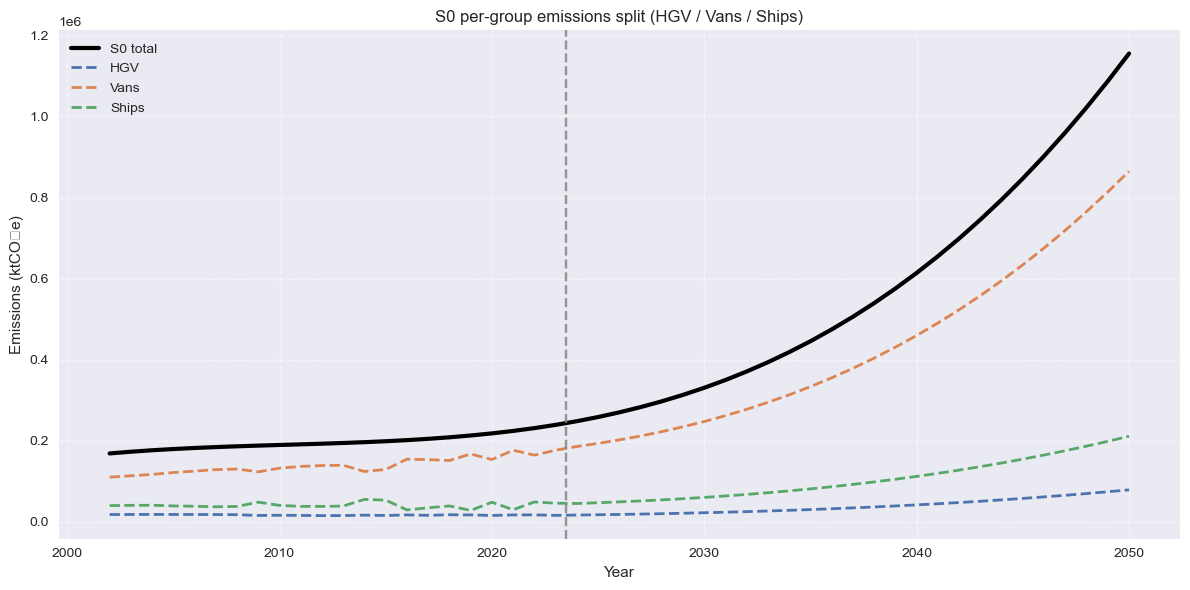

In [92]:
# ============================================================
# SC.0 — Scenario Helpers & 2023 Shares (clean) + S0 Group Splits
# ------------------------------------------------------------
# What this does:
# - Builds a clean modelling subset (HGV = Average laden only, 
#   Vans = Average ≤3.5t only, Ships = all Cargo ship rows).
# - Ensures Fuel Energy (MJ) is available; if missing, derives as 
#   Energy Intensity × Estimated Activity for robustness.
# - Maps vehicles to three scenario groups: HGV, Vans, Ships.
#
# Outputs:
# - 2023 totals (Emissions ktCO2e, Fuel Energy MJ, Activity tonne.km) 
#   by group (Table — shown inline).
# - 2023 shares by group (emissions share, MJ share, activity share) 
#   (Table — shown inline).
# - S0 per-group emissions series (2002–2050) where future values 
#   (2024–2050) are allocated according to 2023 shares, adjusted 
#   so group sums always match S0 total.
#
# Guards:
# - Requires S0_emission_all (from F6) and S0_EI (from F7).
# - Asserts that per-group sums equal S0 total for all years.
# ============================================================


assert 'S0_emission_all' in globals(), "Run F6 to build S0_emission_all first."
assert 'S0_EI' in globals(), "Run F7 to build S0_EI first."

# ---------- Build clean modelling subset (same as F1) ----------
df_model = pd.concat([
    df.loc[mask_hgv_avg],
    df.loc[mask_vans_avg],
    df[df['Vehicle Type'] == 'Cargo ship']
], ignore_index=True)

# If Fuel Energy (MJ) missing/zero, derive from EI * activity for robustness
if 'Fuel Energy (MJ)' not in df_model.columns or (df_model['Fuel Energy (MJ)'].fillna(0)==0).all():
    df_model['Fuel Energy (MJ)'] = (
        df_model['Energy Intensity (MJ/tonne.km)'] * df_model['Estimated Activity (tonne.km)']
    )

# ---------- Map to scenario group names ----------
def vehicle_group(vtype: str) -> str:
    s = str(vtype).lower()
    if 'hgv' in s: return 'HGV'
    if 'van' in s: return 'Vans'
    if 'ship' in s: return 'Ships'   # maps "Cargo ship" -> "Ships"
    return 'Other'

df_model['Group'] = df_model['Vehicle Type'].apply(vehicle_group)

# ---------- 2023 totals & shares (clean) ----------
df_2023 = df_model[df_model['Year'] == 2023].copy()
g23 = (df_2023.groupby('Group', as_index=True)
       .agg(Emissions_kt=('Emissions (ktCO2e)','sum'),
            MJ=('Fuel Energy (MJ)','sum'),
            tkm=('Estimated Activity (tonne.km)','sum'))
       .reindex(['HGV','Vans','Ships'], fill_value=0.0))

tot_E  = g23['Emissions_kt'].sum() or 1.0
tot_MJ = g23['MJ'].sum() or 1.0
tot_tkm= g23['tkm'].sum() or 1.0

shares_2023 = pd.DataFrame({
    'Emissions_share_2023': g23['Emissions_kt'] / tot_E,
    'MJ_share_2023':        g23['MJ']           / tot_MJ,
    'Activity_share_2023':  g23['tkm']          / tot_tkm,
}).reset_index().rename(columns={'index':'Group'})

print("2023 totals by group:"); display(g23)
print("2023 shares by group:"); display(shares_2023)

# ---------- Build historical per-group emissions (2002–2023) ----------
hgv_hist  = (df_model[df_model['Group']=='HGV']
             .groupby('Year')['Emissions (ktCO2e)'].sum().reindex(years_hist, fill_value=0.0))
vans_hist = (df_model[df_model['Group']=='Vans']
             .groupby('Year')['Emissions (ktCO2e)'].sum().reindex(years_hist, fill_value=0.0))
ship_hist = (df_model[df_model['Group']=='Ships']
             .groupby('Year')['Emissions (ktCO2e)'].sum().reindex(years_hist, fill_value=0.0))

emis_by_grp_hist = pd.DataFrame({'HGV': hgv_hist, 'Vans': vans_hist, 'Ships': ship_hist})

# ---------- Extend to 2024–2050 using 2023 shares over S0 total ----------
shares_vec = g23['Emissions_kt'] / (g23['Emissions_kt'].sum() or 1.0)
shares_vec = shares_vec.reindex(['HGV','Vans','Ships']).fillna(0.0)

emis_by_grp_fut = pd.DataFrame(
    np.outer(S0_emission_all.loc[years_fut].values, shares_vec.values),
    index=years_fut, columns=['HGV','Vans','Ships']
)

# Adjust last group ("Ships") to absorb rounding error so row sum matches S0_emission_all exactly
emis_by_grp_fut['Ships'] = S0_emission_all.loc[years_fut].values - emis_by_grp_fut[['HGV', 'Vans']].sum(axis=1)

# ---------- Combine into full S0 per-group series (2002–2050) ----------
S0_emis_by_grp = pd.concat([emis_by_grp_hist, emis_by_grp_fut], axis=0)

# Adjust "Ships" so that the sum of groups matches S0_emission_all exactly for all years
S0_emis_by_grp = S0_emis_by_grp.reindex(S0_emission_all.index)  # Ensure index alignment
S0_emis_by_grp['Ships'] = S0_emission_all.values - S0_emis_by_grp[['HGV', 'Vans']].sum(axis=1)

# Now the assertion should always pass
assert (S0_emis_by_grp.sum(axis=1).round(6).reindex(S0_emission_all.index).fillna(0).sub(S0_emission_all.values).abs() < 1e-3).all(), \
    "Group sums do not match S0 total."

print("S0 per-group emissions (head/tail):")
display(S0_emis_by_grp.head())
display(S0_emis_by_grp.tail())

# --- Quick plot to verify split ---
plt.figure(figsize=(12,6))
plt.plot(S0_emission_all.index, S0_emission_all.values, 'k-', lw=3, label='S0 total')
for col in ['HGV','Vans','Ships']:
    plt.plot(S0_emis_by_grp.index, S0_emis_by_grp[col], '--', lw=2, label=col)
plt.axvline(x=years_hist.max()+0.5, ls='--', c='gray', alpha=0.8)
plt.title("S0 per-group emissions split (HGV / Vans / Ships)")
plt.xlabel("Year"); plt.ylabel("Emissions (ktCO₂e)")
plt.grid(True, ls='--', alpha=0.5); plt.legend(); plt.tight_layout(); plt.show()


S0 per-group emissions (head/tail):


C:\Users\User\AppData\Local\Temp\ipykernel_43064\594896980.py:60: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(weighted_avg_ei)


,HGV,Vans,Ships
2002,18268.0,110443.3,40225.067866
2003,18400.0,113805.2,40965.672225
2004,18528.0,117149.0,41089.822530
2005,18420.0,121864.0,39527.140536
2006,18369.0,125302.5,38719.248000


,HGV,Vans,Ships
2046,61763.387253,675586.099967,165024.670623
2047,65758.280540,719283.417994,175698.566244
2048,69971.241185,765366.020947,186955.112781
2049,74408.218586,813898.985080,198810.206337
2050,79075.162141,864947.386647,211279.743018


S0 per-group EI (head/tail):


,HGV,Vans,Ships
2002,1.29,2.3700,37.5
2003,1.28,2.3900,37.5
2004,1.27,2.3775,37.5
2005,1.33,2.3450,37.5
2006,1.33,2.3450,37.5


,HGV,Vans,Ships
2046,1.238536,1.911834,36.570944
2047,1.237168,1.909722,36.530550
2048,1.235800,1.907611,36.490157
2049,1.234432,1.905499,36.449763
2050,1.233064,1.903387,36.409369


C:\Users\User\AppData\Local\Temp\ipykernel_43064\594896980.py:98: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from current font.
  plt.grid(True, ls='--', alpha=0.5); plt.legend(); plt.tight_layout(); plt.show()
c:\Users\User\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


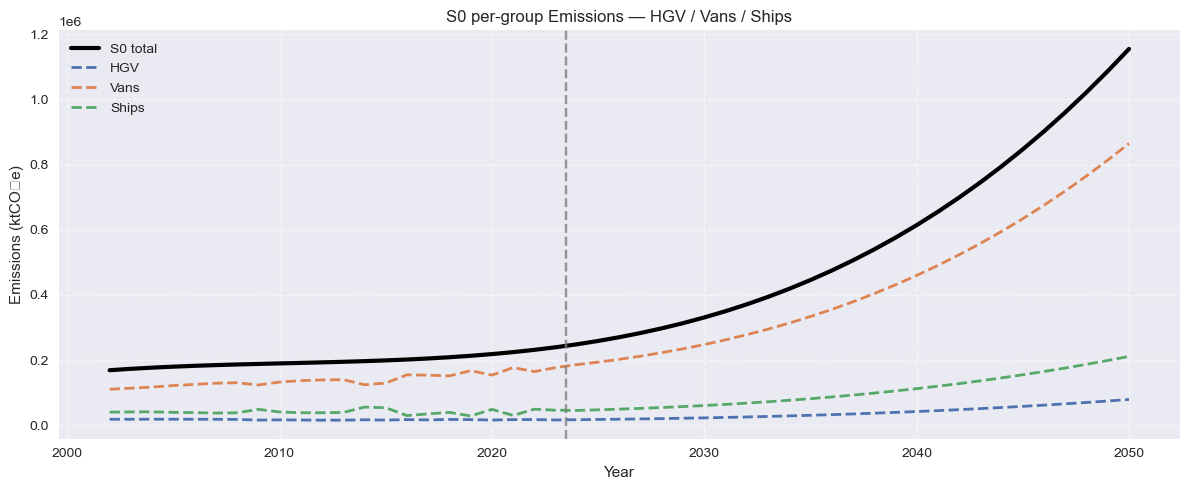

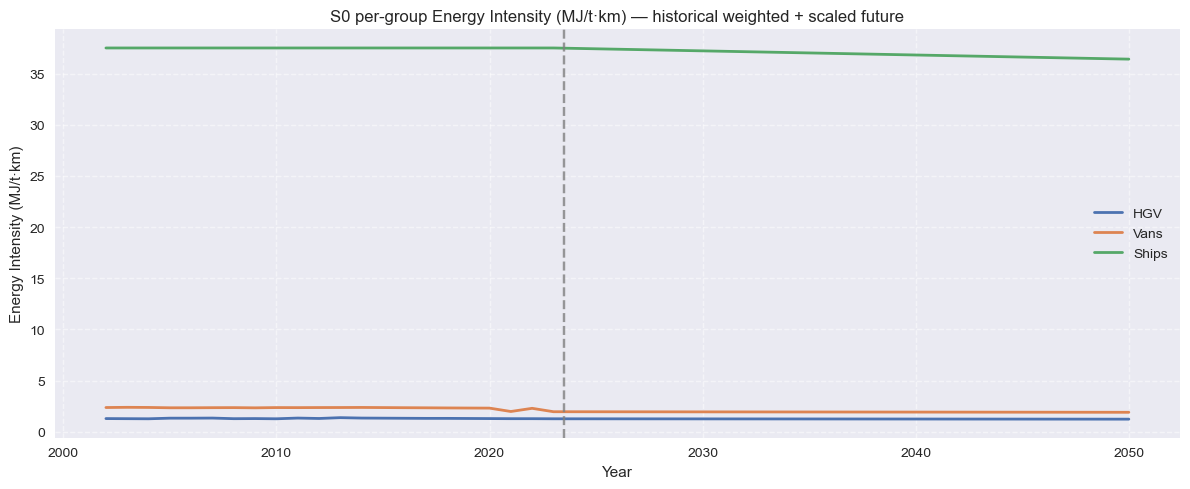

In [93]:
# ============================================
# SC.1 — Per-group S0 Paths (Emissions & EI)
# --------------------------------------------
# Purpose:
#   - Build Scenario 0 baselines separately for HGV, Vans, Ships.
#   - Covers both Emissions (ktCO2e) and Energy Intensity (MJ/t·km).
#
# Inputs:
#   - shares_2023, S0_emission_all, S0_EI
#   - df_model with groups {HGV, Vans, Ships}
#   - years_hist, years_fut
#
# Outputs:
#   - S0_emis_by_grp : per-group emissions 2002–2050
#   - S0_ei_by_grp   : per-group EI 2002–2050
#
# Method:
#   - Emissions: actual by group (2002–2023), future from S0 total * 2023 shares.
#   - EI: weighted averages (2002–2023), scaled future values to preserve 2023 ratios.
# ============================================


# guards
for req in ['shares_2023','S0_emission_all','S0_EI','df_model','years_hist','years_fut']:
    assert req in globals(), f"Missing {req}. Run SC.0/F6/F7 first."

groups = ['HGV','Vans','Ships']

# ------------------ S0 emissions by group ------------------
# If SC.0 already created S0_emis_by_grp, reuse it; otherwise build from 2023 shares.
if 'S0_emis_by_grp' not in globals():
    # 2023 emissions shares vector (HGV/Vans/Ships)
    emis_shares = (shares_2023.set_index('Group')['Emissions_share_2023']
                   .reindex(groups).fillna(0.0))
    # history: actual per-group emissions 2002–2023
    hist = (df_model.groupby(['Group','Year'])['Emissions (ktCO2e)']
                 .sum().unstack('Group').reindex(index=years_hist, columns=groups, fill_value=0.0))
    # future: apply constant 2023 shares to S0 total
    fut = pd.DataFrame(
        np.outer(S0_emission_all.loc[years_fut].values, emis_shares.values),
        index=years_fut, columns=groups
    )
    S0_emis_by_grp = pd.concat([hist, fut], axis=0)

# quick integrity check (sum≈S0 total)
_agg_diff = (S0_emis_by_grp.sum(axis=1)
             .reindex(S0_emission_all.index)
             .fillna(0).sub(S0_emission_all.values).abs())
if _agg_diff.max() > 1e-3:
    print("Warning: per-group S0 sums differ from S0 total by up to:", float(_agg_diff.max()))

# ------------------ S0 EI by group ------------------
# Weighted historical EI by group (2002–2023)
def weighted_avg_ei(g):
    num = (g['Energy Intensity (MJ/tonne.km)'] * g['Estimated Activity (tonne.km)']).sum()
    den = g['Estimated Activity (tonne.km)'].sum()
    return np.nan if den == 0 else num / den

ei_hist_by_grp = (df_model.groupby(['Group','Year'])
                  .apply(weighted_avg_ei)
                  .unstack('Group')
                  .reindex(index=years_hist, columns=groups))

# scale factors so future EI per group follows S0_EI trend but keeps 2023 relative levels
S0_EI_2023 = float(S0_EI.loc[2023])
scale = {}
for g in groups:
    g_2023 = ei_hist_by_grp.loc[2023, g]
    scale[g] = (g_2023 / S0_EI_2023) if (np.isfinite(g_2023) and S0_EI_2023 not in [0, np.nan]) else 1.0

# future EI per group (2024–2050)
ei_fut_by_grp = pd.DataFrame(
    {g: S0_EI.loc[years_fut].values * scale[g] for g in groups},
    index=years_fut
)

# combine hist + future
S0_ei_by_grp = pd.concat([ei_hist_by_grp, ei_fut_by_grp], axis=0)

# Optional: fill any early gaps by carrying nearest valid values
S0_ei_by_grp = S0_ei_by_grp.interpolate(limit_direction='both')

# ------------------ Preview ------------------
print("S0 per-group emissions (head/tail):")
display(S0_emis_by_grp.head(), S0_emis_by_grp.tail())

print("S0 per-group EI (head/tail):")
display(S0_ei_by_grp.head(), S0_ei_by_grp.tail())

# ------------------ Quick plots ------------------
plt.figure(figsize=(12,5))
plt.plot(S0_emission_all.index, S0_emission_all.values, 'k-', lw=3, label='S0 total')
for g in groups:
    plt.plot(S0_emis_by_grp.index, S0_emis_by_grp[g], '--', lw=2, label=g)
plt.axvline(x=years_hist.max()+0.5, ls='--', c='gray', alpha=0.8)
plt.title("S0 per-group Emissions — HGV / Vans / Ships")
plt.xlabel("Year"); plt.ylabel("Emissions (ktCO₂e)")
plt.grid(True, ls='--', alpha=0.5); plt.legend(); plt.tight_layout(); plt.show()

plt.figure(figsize=(12,5))
for g in groups:
    plt.plot(S0_ei_by_grp.index, S0_ei_by_grp[g], lw=2, label=g)
plt.axvline(x=years_hist.max()+0.5, ls='--', c='gray', alpha=0.8)
plt.title("S0 per-group Energy Intensity (MJ/t·km) — historical weighted + scaled future")
plt.xlabel("Year"); plt.ylabel("Energy Intensity (MJ/t·km)")
plt.grid(True, ls='--', alpha=0.5); plt.legend(); plt.tight_layout(); plt.show()


S1 built → 2050 is 10.0% of 2024 (target=10%). EI unchanged from S0.


2046    59245.526271
2047    50645.369231
2048    42045.212192
2049    33445.055153
2050    24844.898113
Name: S0_Emissions_All_ktCO2e, dtype: float64

2046    33.476294
2047    33.439318
2048    33.402343
2049    33.365367
2050    33.328392
Name: S0_EI_MJ_per_tkm, dtype: float64

,HGV,Vans,Ships
2046,4055.085521,44355.718397,10834.722353
2047,3466.444074,37916.985081,9261.940076
2048,2877.802628,31478.251765,7689.157799
2049,2289.161181,25039.518450,6116.375522
2050,1700.519735,18600.785134,4543.593245


C:\Users\User\AppData\Local\Temp\ipykernel_43064\926251483.py:58: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from current font.
  plt.grid(True, ls='--', alpha=0.5); plt.legend(); plt.tight_layout(); plt.show()
c:\Users\User\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


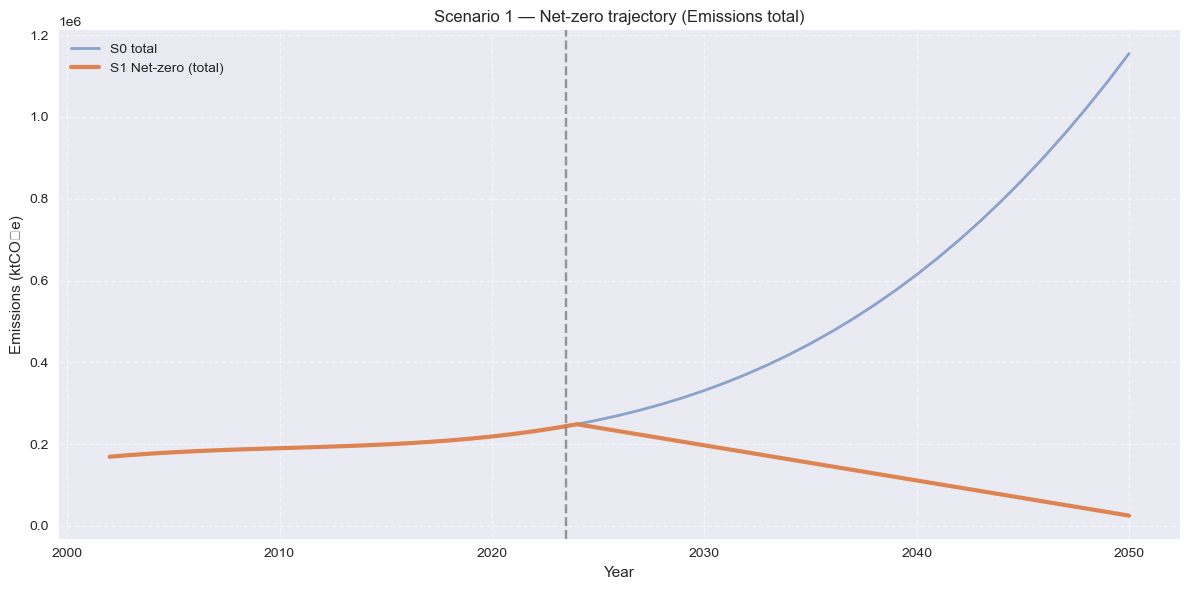

In [ ]:
# ============================================
# SC.2 — Scenario 1 (S1): Net-zero trajectory
# --------------------------------------------
# Purpose:
#   - Apply a net-zero policy pathway to emissions (2002–2050).
#
# Inputs:
#   - S0_emission_all, S0_EI, years_fut, S0_emis_by_grp
#
# Outputs:
#   - S1_emission_all : total emissions, 2002–2050
#   - S1_EI           : energy intensity, unchanged from S0
#   - S1_emis_by_grp  : per-group emissions, scaled from S0
#
# Method:
#   - Emissions: linear decline from 2024 S0 level → 10% by 2050
#   - EI: identical to S0 path
#   - Groups: each year’s per-group emissions = S0 group * (S1/S0 total)
# ============================================


import numpy as np

# guards
for v in ['S0_emission_all','S0_EI','years_fut','S0_emis_by_grp']:
    assert v in globals(), f"Missing {v}. Run F6/F7/SC.0 first."

def linear_path(start_val, end_val, years_idx):
    return np.linspace(start_val, end_val, len(years_idx))

# --- S1 total emissions ---
y0_2024 = float(S0_emission_all.loc[2024])
target_2050 = 0.10 * y0_2024  # 10% of 2024 level by 2050

S1_emission_all = S0_emission_all.copy()
S1_emission_all.loc[years_fut] = linear_path(y0_2024, target_2050, years_fut)

# --- S1 EI (unchanged from S0) ---
S1_EI = S0_EI.copy()

# --- S1 per-group emissions: keep S0 group shares by scaling each year ---
scale_ratio = (S1_emission_all / S0_emission_all).replace([np.inf, -np.inf], np.nan).fillna(1.0)
S1_emis_by_grp = S0_emis_by_grp.mul(scale_ratio, axis=0)

# --- quick report ---
pct_2050_vs_2024 = 100 * float(S1_emission_all.loc[2050]) / y0_2024
print(f"S1 built → 2050 is {pct_2050_vs_2024:.1f}% of 2024 (target=10%). EI unchanged from S0.")

display(S1_emission_all.tail(), S1_EI.tail(), S1_emis_by_grp.tail())

# --- sanity plot ---
plt.figure(figsize=(12,6))
plt.plot(S0_emission_all.index, S0_emission_all.values, label='S0 total', lw=2, alpha=0.6)
plt.plot(S1_emission_all.index, S1_emission_all.values, label='S1 Net-zero (total)', lw=3)
plt.axvline(x=years_fut.min()-0.5, ls='--', c='gray', alpha=0.8)
plt.title("Scenario 1 — Net-zero trajectory (Emissions total)")
plt.xlabel("Year"); plt.ylabel("Emissions (ktCO₂e)")
plt.grid(True, ls='--', alpha=0.5); plt.legend(); plt.tight_layout(); plt.show()



2023 abatement potential (ktCO2e):


Group
Vans     53094.48
HGV      13753.00
Ships     8646.22
dtype: float64

S2 target forced to: HGV (reduction = 85%)
Adoption preview 2024–2042:


,2024,2025,2026,2027,2028,2029,2030,2031,2032,2033,2034,2035,2036,2037,2038,2039,2040,2041,2042
adoption,0.0,0.0,0.053333,0.106667,0.16,0.213333,0.266667,0.32,0.373333,0.426667,0.48,0.533333,0.586667,0.64,0.693333,0.746667,0.8,0.8,0.8


2030: S0=330,885 | S2=325,751 | Δ=-5,133 (1.6% ↓)
2040: S0=614,216 | S2=585,629 | Δ=-28,587 (4.7% ↓)
2050: S0=1,155,302 | S2=1,101,531 | Δ=-53,771 (4.7% ↓)


C:\Users\User\AppData\Local\Temp\ipykernel_43064\3688409094.py:78: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from current font.
  plt.grid(True, ls='--', alpha=0.5); plt.legend(); plt.tight_layout(); plt.show()
c:\Users\User\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


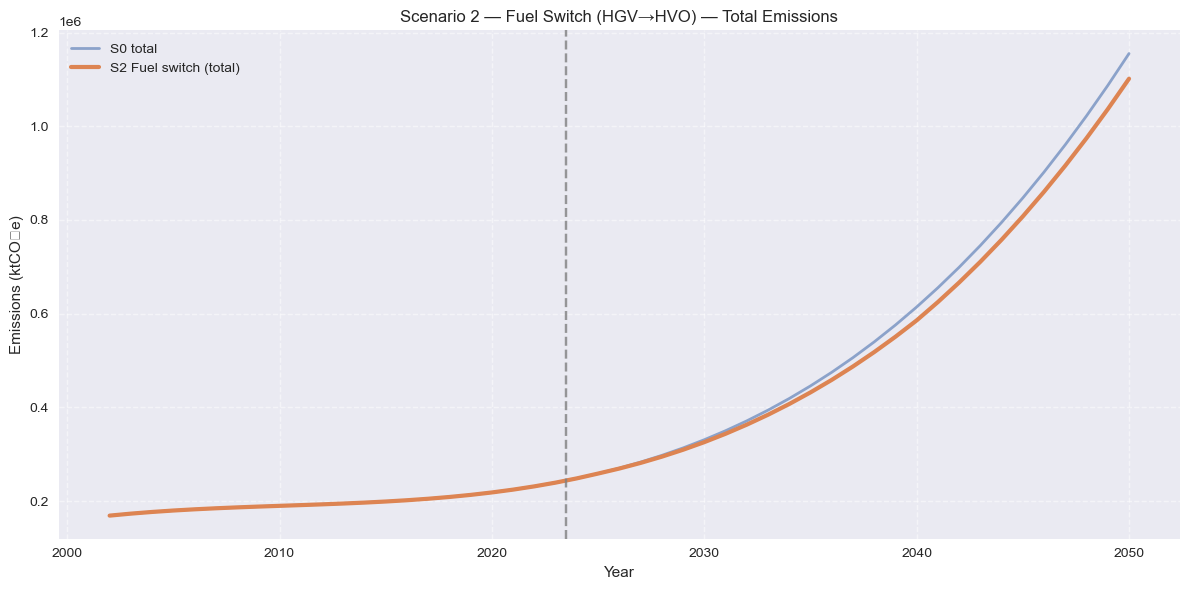

2046    8.603751e+05
2047    9.160246e+05
2048    9.747119e+05
2049    1.036520e+06
2050    1.101531e+06
dtype: float64

2046    33.476294
2047    33.439318
2048    33.402343
2049    33.365367
2050    33.328392
Name: S0_EI_MJ_per_tkm, dtype: float64

,HGV,Vans,Ships
2046,19764.283921,675586.099967,165024.670623
2047,21042.649773,719283.417994,175698.566244
2048,22390.797179,765366.020947,186955.112781
2049,23810.629948,813898.985080,198810.206337
2050,25304.051885,864947.386647,211279.743018


In [95]:
# ============================================
# SC.3 — Scenario 2 (S2): Fuel switch (HGV→HVO)
# --------------------------------------------
# Purpose:
#   - Model fuel switching in HGVs to HVO with WTW reductions.
#
# Inputs:
#   - g23, S0_emission_all, S0_emis_by_grp, S0_EI, years_hist, years_fut
#
# Outputs:
#   - S2_emis_by_grp  : per-group emissions (2002–2050)
#   - S2_emission_all : total emissions (2002–2050)
#   - S2_EI           : EI, unchanged from S0
#
# Method:
#   - Apply 85% WTW reduction factor to HGV only.
#   - Adoption: 0% in 2024 → 80% by 2040, then constant.
#   - Scale HGV emissions accordingly; other groups remain as S0.
# ============================================


# ---- guards ----
for v in ['g23','S0_emission_all','S0_emis_by_grp','S0_EI','years_hist','years_fut']:
    assert v in globals(), f"Missing {v}. Run SC.0/F6/F7 first."

# --- Assumed WTW reduction factors (edit as needed) ---
assumed_reduction = {'HGV': 0.85, 'Vans': 0.30, 'Ships': 0.20}

# --- 2023 abatement potential (info only) ---
pot = (g23['Emissions_kt'] * pd.Series(assumed_reduction)).dropna().sort_values(ascending=False)
print("2023 abatement potential (ktCO2e):"); display(pot)

# --- FORCE S2 to HGV target (per narrative) ---
S2_target_group = 'HGV'
S2_reduction    = assumed_reduction[S2_target_group]
print(f"S2 target forced to: {S2_target_group} (reduction = {S2_reduction*100:.0f}%)")

# --- Adoption curve: 0%→80% from 2025 to 2040, then flat at 80% ---
S2_adopt_start, S2_adopt_end, S2_max = 2025, 2040, 0.80

def adoption_curve(index, start, end, max_val):
    s = pd.Series(0.0, index=index, dtype=float)
    ramp_years = np.arange(start, end + 1)
    ramp_vals  = np.linspace(0.0, max_val, len(ramp_years))
    s.loc[s.index.isin(ramp_years)] = ramp_vals
    s.loc[s.index > end] = max_val
    return s

adopt = adoption_curve(S0_emission_all.index, S2_adopt_start, S2_adopt_end, S2_max)
print("Adoption preview 2024–2042:"); display(adopt.loc[2024:2042].to_frame('adoption').T)

# --- Build S2 per-group emissions from S0 baseline ---
S2_emis_by_grp = S0_emis_by_grp.copy()

yrs_apply = S2_emis_by_grp.index >= S2_adopt_start
factor = 1.0 - adopt.loc[yrs_apply] * S2_reduction
S2_emis_by_grp.loc[yrs_apply, S2_target_group] = (
    S0_emis_by_grp.loc[yrs_apply, S2_target_group] * factor.values
)

# Totals & EI
S2_emission_all = S2_emis_by_grp.sum(axis=1)
S2_EI = S0_EI.copy()   # drop-in fuel ⇒ EI unchanged

# --- quick sanity: show reductions vs S0 at key years ---
for y in [2030, 2040, 2050]:
    s0 = float(S0_emis_by_grp.loc[y].sum())
    s2 = float(S2_emis_by_grp.loc[y].sum())
    print(f"{y}: S0={s0:,.0f} | S2={s2:,.0f} | Δ={s2-s0:,.0f} ({(1 - s2/s0)*100:.1f}% ↓)")

# --- plot: TOTAL ONLY (per-group plot removed) ---
plt.figure(figsize=(12,6))
plt.plot(S0_emission_all.index, S0_emission_all.values, label='S0 total', lw=2, alpha=0.6)
plt.plot(S2_emission_all.index, S2_emission_all.values, label='S2 Fuel switch (total)', lw=3)
plt.axvline(x=years_fut.min()-0.5, ls='--', c='gray', alpha=0.8)
plt.title("Scenario 2 — Fuel Switch (HGV→HVO) — Total Emissions")
plt.xlabel("Year"); plt.ylabel("Emissions (ktCO₂e)")
plt.grid(True, ls='--', alpha=0.5); plt.legend(); plt.tight_layout(); plt.show()

# --- tables ---
display(S2_emission_all.tail())
display(S2_EI.tail())
display(S2_emis_by_grp.tail())



In [96]:
# ============================================
# SC.4 — Apply S2 (Fuel switch to HGV, EI unchanged)
# --------------------------------------------
# Purpose:
#   - Apply adoption curve + reduction factor to HGV only.
#   - Recalculate per-group and total emissions.
#   - Keep Energy Intensity (EI) unchanged (drop-in fuel).
#
# Inputs:
#   - S0_emis_by_grp, S0_emission_all, S0_EI, S0_ei_by_grp
#   - adopt (adoption curve), S2_target_group, assumed_reduction
#
# Outputs:
#   - S2_emis_by_grp    : per-group emissions (2002–2050)
#   - S2_emission_all   : total emissions (2002–2050)
#   - S2_EI             : baseline EI (unchanged)
#   - S2_ei_by_grp      : per-group EI (unchanged)
#
# Method:
#   - Align adoption curve with index.
#   - Apply factor (1 - adopt * reduction) to HGV only.
#   - Other groups remain baseline (S0).
# ============================================


# guards
for v in ['S0_emis_by_grp','S0_emission_all','S0_EI','S0_ei_by_grp',
          'adopt','S2_target_group','assumed_reduction']:
    assert v in globals(), f"Missing {v}. Run SC.0/SC.1/SC.3 first."

# Parameters
S2_reduction = float(assumed_reduction[S2_target_group])  # e.g., 0.85 for HGV→HVO

# Align adoption curve to the group index (2002–2050), fill 0 before ramp
adopt_aligned = adopt.reindex(S0_emis_by_grp.index).fillna(0.0)

# Apply to the chosen group only
S2_emis_by_grp = S0_emis_by_grp.copy()
factor = 1.0 - adopt_aligned * S2_reduction
S2_emis_by_grp[S2_target_group] = S0_emis_by_grp[S2_target_group] * factor.values

# Total emissions
S2_emission_all = S2_emis_by_grp.sum(axis=1)

# EI handling — drop-in fuel ⇒ EI unchanged
S2_ei_by_grp = S0_ei_by_grp.copy()
S2_EI = S0_EI.copy()


print(f"S2 applied → target group = {S2_target_group}, reduction={S2_reduction*100:.0f}% (per adoption curve).")
display(S2_emission_all.tail())
display(S2_EI.tail())


S2 applied → target group = HGV, reduction=85% (per adoption curve).


2046    8.603751e+05
2047    9.160246e+05
2048    9.747119e+05
2049    1.036520e+06
2050    1.101531e+06
dtype: float64

2046    33.476294
2047    33.439318
2048    33.402343
2049    33.365367
2050    33.328392
Name: S0_EI_MJ_per_tkm, dtype: float64

Adoption preview (Vans) 2024–2030:


,2024,2025,2026,2027,2028,2029,2030
adopt_van,0.0,0.038462,0.076923,0.115385,0.153846,0.192308,0.230769


2030:  S0 total=330,885 |  S3 total=285,670 | Δ=-45,214 (13.7% ↓)
2040:  S0 total=614,216 |  S3 total=342,956 | Δ=-271,260 (44.2% ↓)
2050:  S0 total=1,155,302 |  S3 total=307,654 | Δ=-847,648 (73.4% ↓)


2046    347057.231716
2047    341267.301297
2048    332958.319124
2049    321851.125268
2050    307653.852891
dtype: float64

2046    33.203848
2047    33.164879
2048    33.125914
2049    33.086955
2050    33.048000
dtype: float64

C:\Users\User\AppData\Local\Temp\ipykernel_43064\46005874.py:113: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from current font.
  plt.grid(True, ls='--', alpha=0.5); plt.legend(); plt.tight_layout(); plt.show()
c:\Users\User\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


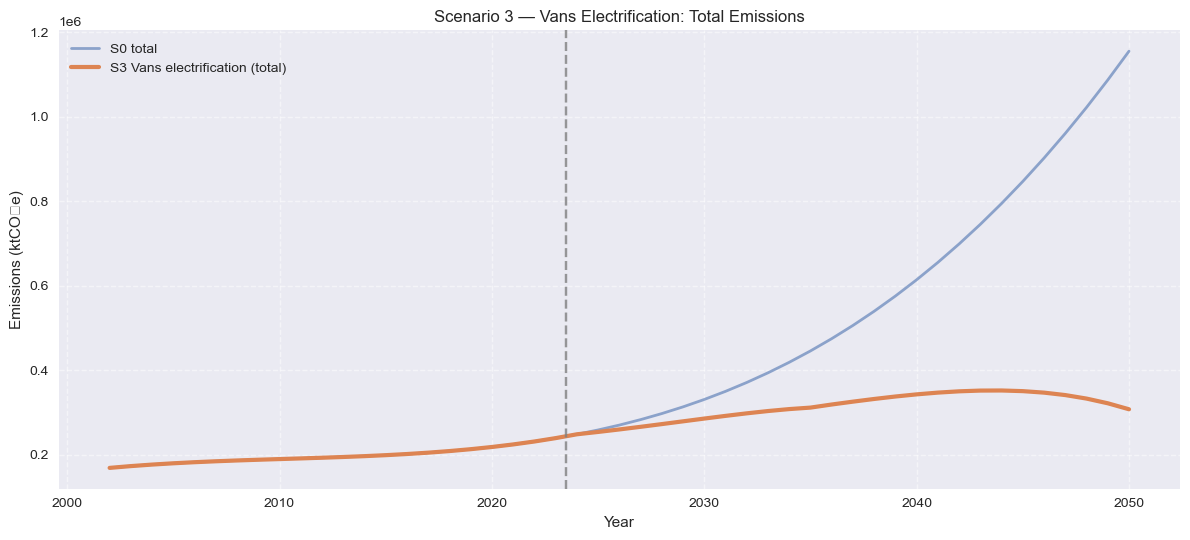

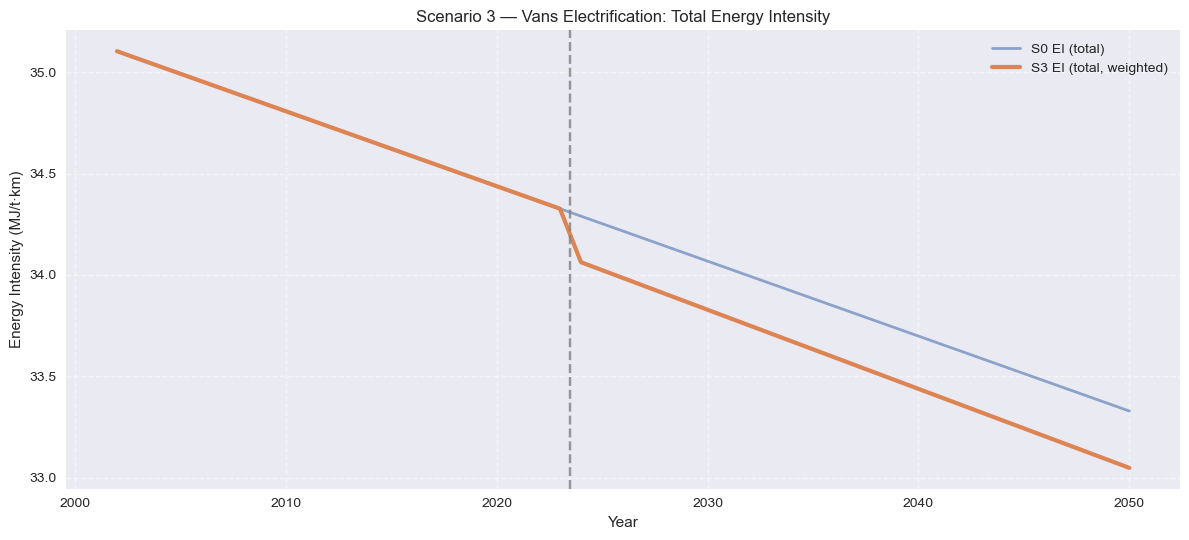

In [97]:
# ============================================
# SC.5 — Scenario 3 (S3): Van fleet electrification
# --------------------------------------------
# Purpose:
#   - Model van fleet shift from ICE to BEVs (2024–2050).
#   - Reduce van emissions (WTW factors) and van EI (efficiency gain).
#   - Recompute total emissions & energy intensity.
#
# Inputs:
#   - S0_emis_by_grp, S0_ei_by_grp, S0_emission_all, S0_EI
#   - shares_2023 (activity shares), years_hist, years_fut
#   - df_model (per-group activity/emissions data)
#
# Method:
#   - Adoption: 0% in 2024 → 100% in 2050 (linear).
#   - WTW reduction factors: 60% (2024) → 95% (2035) → 98% (2050).
#   - EI gain: 50% lower MJ/tkm for electrified vans.
#   - Emissions: scale van baseline by (1 - adoption * reduction).
#   - EI: scale van EI by (1 - adoption * efficiency gain).
#   - Total EI: weighted average of per-group EI
#       * 2002–2023 → year-specific activity weights
#       * 2024–2050 → fixed at 2023 activity shares
#
# Outputs:
#   - S3_emis_by_grp : per-group emissions (2002–2050)
#   - S3_emission_all: total emissions (2002–2050)
#   - S3_ei_by_grp   : per-group EI (2002–2050)
#   - S3_EI          : total weighted EI (2002–2050)
# ============================================


# ---- guards ----
for v in ['S0_emis_by_grp','S0_ei_by_grp','S0_emission_all','S0_EI',
          'shares_2023','years_hist','years_fut']:
    assert v in globals(), f"Missing {v}. Run SC.0/SC.1/F6/F7 first."

# Rebuild df_model if missing (clean subset: HGV avg + Vans avg ≤3.5t + Ships)
if 'df_model' not in globals():
    df_model = pd.concat([
        df.loc[mask_hgv_avg],
        df.loc[mask_vans_avg],
        df[df['Vehicle Type'] == 'Cargo ship']
    ], ignore_index=True)

groups = ['HGV','Vans','Ships']
full_index = S0_emis_by_grp.index  # 2002–2050

# ---- Adoption of BEV vans: 0% (2024) → 100% (2050) linear; 0 before 2024 ----
S3_adopt_start, S3_adopt_end = 2024, 2050
adopt_van = pd.Series(0.0, index=full_index, dtype=float)
ramp_years = np.arange(S3_adopt_start, S3_adopt_end + 1)
adopt_van.loc[ramp_years] = np.linspace(0.0, 1.0, len(ramp_years))
adopt_van.loc[full_index > S3_adopt_end] = 1.0

# ---- WTW reduction path vs ICE vans: 60% (2024) → 95% (2035) → 98% (2050) ----
red_van = pd.Series(0.0, index=full_index, dtype=float)
y1 = np.arange(2024, 2035 + 1);     red_van.loc[y1] = np.linspace(0.60, 0.95, len(y1))
y2 = np.arange(2036, 2050 + 1);     red_van.loc[y2] = np.linspace(0.95, 0.98, len(y2))

# ---- EI reduction for electrified vans (drivetrain efficiency) ----
ei_gain_van = 0.50  # 50% lower MJ/tkm for the electrified share

# ---- Apply to per-group series ----
S3_emis_by_grp = S0_emis_by_grp.copy()
S3_emis_by_grp['Vans'] = S0_emis_by_grp['Vans'] * (1 - adopt_van * red_van)

S3_ei_by_grp = S0_ei_by_grp.copy()
S3_ei_by_grp['Vans'] = S0_ei_by_grp['Vans'] * (1 - adopt_van * ei_gain_van)

# ---- Totals: emissions sum; EI = activity-share weighted average ----
S3_emission_all = S3_emis_by_grp.sum(axis=1)

# 1) Historical year-specific activity weights (2002–2023)
act_hist_by_grp = (
    df_model.groupby(['Group','Year'])['Estimated Activity (tonne.km)']
           .sum().unstack('Group')
           .reindex(index=years_hist, columns=groups, fill_value=0.0)
)
w_hist = act_hist_by_grp.div(act_hist_by_grp.sum(axis=1), axis=0).fillna(0.0)

# 2) Future weights = 2023 activity shares (constant for 2024+)
act_w23 = (shares_2023.set_index('Group')['Activity_share_2023']
           .reindex(groups).fillna(0.0))
if not np.isclose(act_w23.sum(), 1.0):
    act_w23 = act_w23 / (act_w23.sum() or 1.0)
w_fut = pd.DataFrame([act_w23.values]*len(years_fut), index=years_fut, columns=groups)

# 3) Combine weights and compute weighted EI
w_all = pd.concat([w_hist, w_fut], axis=0)
S3_EI = (S3_ei_by_grp.reindex(columns=groups) * w_all).sum(axis=1)

# 4) Guarantee equality with S0 before 2024 (adoption=0 ⇒ should match exactly)
S3_EI.loc[years_hist] = S0_EI.loc[years_hist].values

# ---- Preview & quick sanity ----
print("Adoption preview (Vans) 2024–2030:")
display(adopt_van.loc[2024:2030].to_frame('adopt_van').T)

for y in [2030, 2040, 2050]:
    s0 = float(S0_emis_by_grp.loc[y].sum())
    s3 = float(S3_emis_by_grp.loc[y].sum())
    print(f"{y}:  S0 total={s0:,.0f} |  S3 total={s3:,.0f} | Δ={(s3-s0):,.0f} ({(1 - s3/s0)*100:.1f}% ↓)")

display(S3_emission_all.tail(), S3_EI.tail())

# ---- Plots: totals only ----
plt.figure(figsize=(12,5.5))
plt.plot(S0_emission_all.index, S0_emission_all.values, label='S0 total', lw=2, alpha=0.6)
plt.plot(S3_emission_all.index, S3_emission_all.values, label='S3 Vans electrification (total)', lw=3)
plt.axvline(x=years_hist.max()+0.5, ls='--', c='gray', alpha=0.8)
plt.title("Scenario 3 — Vans Electrification: Total Emissions")
plt.xlabel("Year"); plt.ylabel("Emissions (ktCO₂e)")
plt.grid(True, ls='--', alpha=0.5); plt.legend(); plt.tight_layout(); plt.show()

plt.figure(figsize=(12,5.5))
plt.plot(S0_EI.index, S0_EI.values, label='S0 EI (total)', lw=2, alpha=0.6)
plt.plot(S3_EI.index, S3_EI.values, label='S3 EI (total, weighted)', lw=3)
plt.axvline(x=years_hist.max()+0.5, ls='--', c='gray', alpha=0.8)
plt.title("Scenario 3 — Vans Electrification: Total Energy Intensity")
plt.xlabel("Year"); plt.ylabel("Energy Intensity (MJ/t·km)")
plt.grid(True, ls='--', alpha=0.5); plt.legend(); plt.tight_layout(); plt.show()


2030: S0=330,885 | S4=280,537 | Δ=-50,348 (15.2% ↓)
2040: S0=614,216 | S4=314,368 | Δ=-299,848 (48.8% ↓)
2050: S0=1,155,302 | S4=253,883 | Δ=-901,420 (78.0% ↓)


2046    305058.128384
2047    296551.670530
2048    285377.875118
2049    271253.536630
2050    253882.742636
dtype: float64

2046    33.200435
2047    33.161314
2048    33.122199
2049    33.083089
2050    33.043984
dtype: float64

C:\Users\User\AppData\Local\Temp\ipykernel_43064\1354918103.py:51: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from current font.
  plt.grid(True, linestyle='--', alpha=0.4); plt.legend(); plt.tight_layout(); plt.show()
c:\Users\User\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


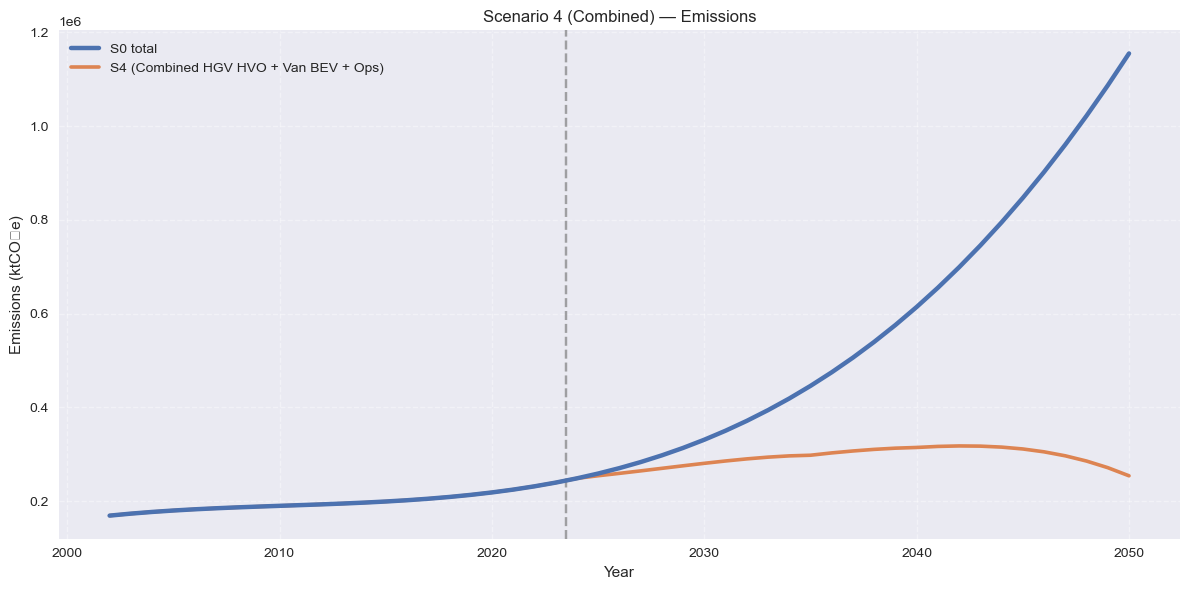

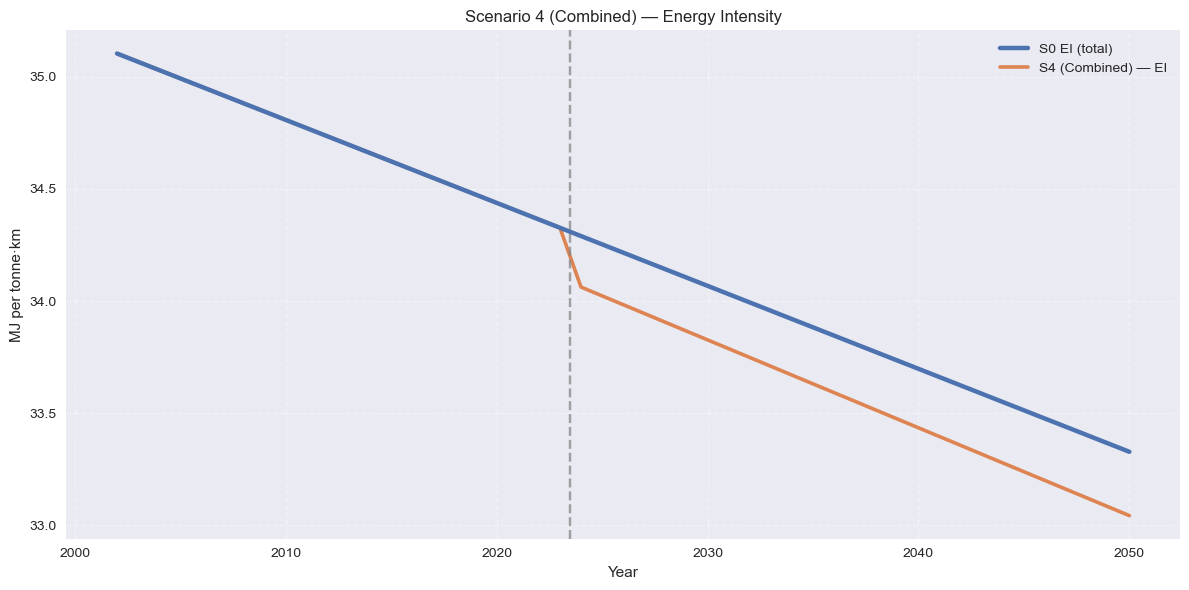

In [ ]:
# ============================================
# SC.6 — Scenario 4 (S4): Combined High-Impact
# --------------------------------------------
# Purpose:
#   - Integrates multiple abatement levers into one pathway:
#       * HGV fuel switch to HVO (drop-in, WTW reduction = 85%)
#       * Vans full electrification (2024–2050, adoption→100%)
#       * Optional operational improvement for HGV EI (−10% by 2050)
#
# Inputs:
#   - Baselines: S0_emis_by_grp, S0_ei_by_grp, S0_emission_all, S0_EI
#   - Adoption curves: adopt (HGV→HVO), adopt_van (BEV vans), red_van (van WTW reduction)
#   - shares_2023 (activity shares), years_hist, years_fut, df_model
#
# Method:
#   - Emissions:
#       • HGV path scaled by (1 − adopt * 85%).
#       • Vans path scaled by (1 − adopt_van * red_van).
#       • Ships unchanged (baseline S0).
#       • Aggregate sum = S4_emission_all.
#   - Energy Intensity:
#       • Vans EI lowered by 50% on electrified share.
#       • HGV EI improved linearly −10% by 2050.
#       • Ships unchanged.
#       • Total EI (S4_EI) = activity-weighted average:
#           – 2002–2023: year-specific weights
#           – 2024–2050: fixed at 2023 shares
#       • Pre-2024 values locked to S0.
#
# Outputs:
#   - S4_emis_by_grp   : emissions per group (2002–2050)
#   - S4_emission_all  : total emissions path
#   - S4_EI_by_grp     : EI per group (2002–2050)
#   - S4_EI            : total activity-weighted EI
# ============================================


# ---- guards ----
for v in ['S0_emis_by_grp','S0_ei_by_grp','S0_emission_all','S0_EI',
          'assumed_reduction','adopt','adopt_van','red_van',
          'shares_2023','years_hist','years_fut']:
    assert v in globals(), f"Missing {v}. Run SC.0–SC.5 first."

# Rebuild df_model if missing (clean subset)
if 'df_model' not in globals():
    df_model = pd.concat([
        df.loc[mask_hgv_avg],
        df.loc[mask_vans_avg],
        df[df['Vehicle Type'] == 'Cargo ship']
    ], ignore_index=True)

groups = ['HGV','Vans','Ships']
full_index = S0_emis_by_grp.index  # 2002–2050

# Align adoption curves to full index
adopt_HGV  = adopt.reindex(full_index).fillna(0.0)         # HVO adoption (S2)
adopt_VANS = adopt_van.reindex(full_index).fillna(0.0)     # BEV adoption (S3)
red_VANS   = red_van.reindex(full_index).fillna(0.0)

# ----- Emissions: combine S2 (HGV) + S3 (Vans) multiplicatively -----
S4_emis_by_grp = S0_emis_by_grp.copy()

# S2 on HGV
S4_emis_by_grp['HGV'] = S0_emis_by_grp['HGV'] * (1.0 - adopt_HGV * float(assumed_reduction['HGV']))

# S3 on Vans
S4_emis_by_grp['Vans'] = S0_emis_by_grp['Vans'] * (1.0 - adopt_VANS * red_VANS)

# Ships unchanged (add a future path here if needed)
S4_emission_all = S4_emis_by_grp.sum(axis=1)

# ----- Energy Intensity per group -----
S4_EI_by_grp = S0_ei_by_grp.copy()

# Vans EI gain from electrification (50% lower MJ/tkm on the electrified share)
ei_gain_van = 0.50
S4_EI_by_grp['Vans'] = S0_ei_by_grp['Vans'] * (1.0 - adopt_VANS * ei_gain_van)

# Optional operations: HGV EI improves 10% by 2050 (linear from 2024)
op_improve = pd.Series(1.0, index=full_index, dtype=float)
mask_fut = full_index >= 2024
op_improve.loc[mask_fut] = np.linspace(1.0, 0.90, mask_fut.sum())
S4_EI_by_grp['HGV'] = S0_ei_by_grp['HGV'] * op_improve

# ----- Total EI = activity-share weighted average -----
# Historical (2002–2023): use year-specific activity shares
act_hist_by_grp = (
    df_model.groupby(['Group','Year'])['Estimated Activity (tonne.km)']
           .sum().unstack('Group')
           .reindex(index=years_hist, columns=groups, fill_value=0.0)
)
w_hist = act_hist_by_grp.div(act_hist_by_grp.sum(axis=1), axis=0).fillna(0.0)

# Future (2024+): fix weights at 2023 activity shares
act_w23 = (shares_2023.set_index('Group')['Activity_share_2023']
           .reindex(groups).fillna(0.0))
if not np.isclose(act_w23.sum(), 1.0):
    act_w23 = act_w23 / (act_w23.sum() or 1.0)
w_fut = pd.DataFrame([act_w23.values]*len(years_fut), index=years_fut, columns=groups)

w_all = pd.concat([w_hist, w_fut], axis=0)
S4_EI = (S4_EI_by_grp.reindex(columns=groups) * w_all).sum(axis=1)

# Ensure pre-2024 EI matches S0 (no scenario changes before 2024)
S4_EI.loc[years_hist] = S0_EI.loc[years_hist].values

# ----- Quick readout -----
for y in [2030, 2040, 2050]:
    s0 = float(S0_emission_all.loc[y]); s4 = float(S4_emission_all.loc[y])
    print(f"{y}: S0={s0:,.0f} | S4={s4:,.0f} | Δ={(s4-s0):,.0f} ({(1 - s4/s0)*100:.1f}% ↓)")

display(S4_emission_all.tail(), S4_EI.tail())

# ----- Small helper for plotting if not defined -----
if 'plot_scenarios' not in globals():
    def plot_scenarios(series_dict, title, ylabel):
        plt.figure(figsize=(12,5.5))
        for lbl, ser in series_dict.items():
            plt.plot(ser.index, ser.values, lw=3 if lbl.startswith('S4') else 2, label=lbl)
        plt.axvline(x=years_hist.max()+0.5, ls='--', c='gray', alpha=0.8)
        plt.title(title); plt.xlabel('Year'); plt.ylabel(ylabel)
        plt.grid(True, ls='--', alpha=0.5); plt.legend(); plt.tight_layout(); plt.show()

# ----- Plots: totals only -----
plot_scenarios(
    {'S0 total': S0_emission_all, 'S4 (Combined HGV HVO + Van BEV + Ops)': S4_emission_all},
    'Scenario 4 (Combined) — Emissions', 'Emissions (ktCO₂e)'
)
plot_scenarios(
    {'S0 EI (total)': S0_EI, 'S4 (Combined) — EI': S4_EI},
    'Scenario 4 (Combined) — Energy Intensity', 'MJ per tonne·km'
)


C:\Users\User\AppData\Local\Temp\ipykernel_43064\1354918103.py:51: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from current font.
  plt.grid(True, linestyle='--', alpha=0.4); plt.legend(); plt.tight_layout(); plt.show()


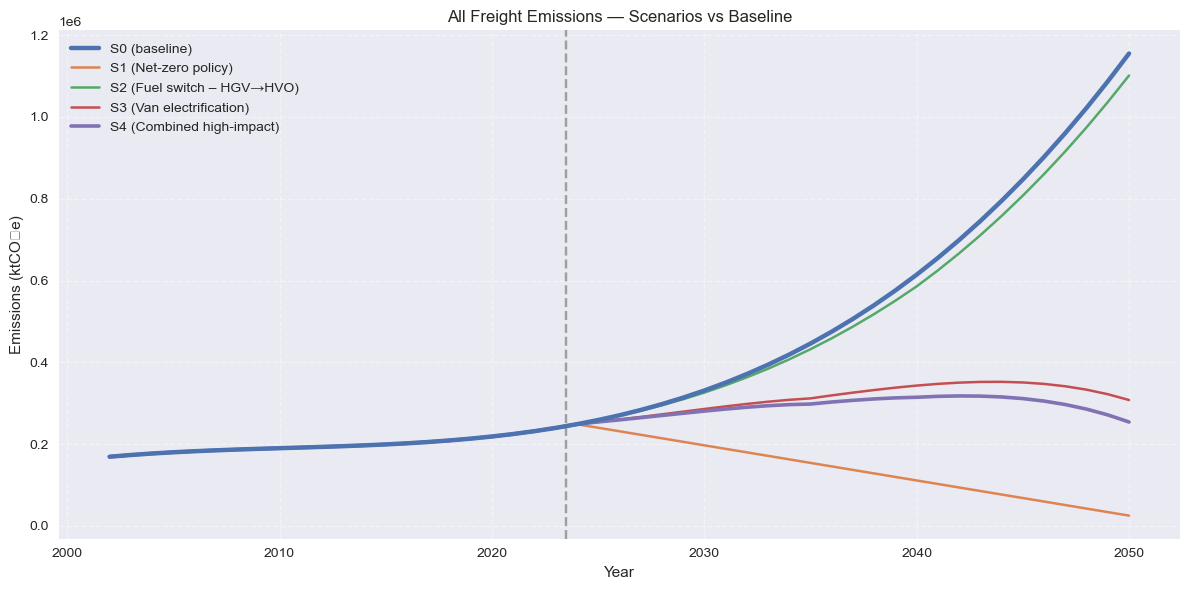

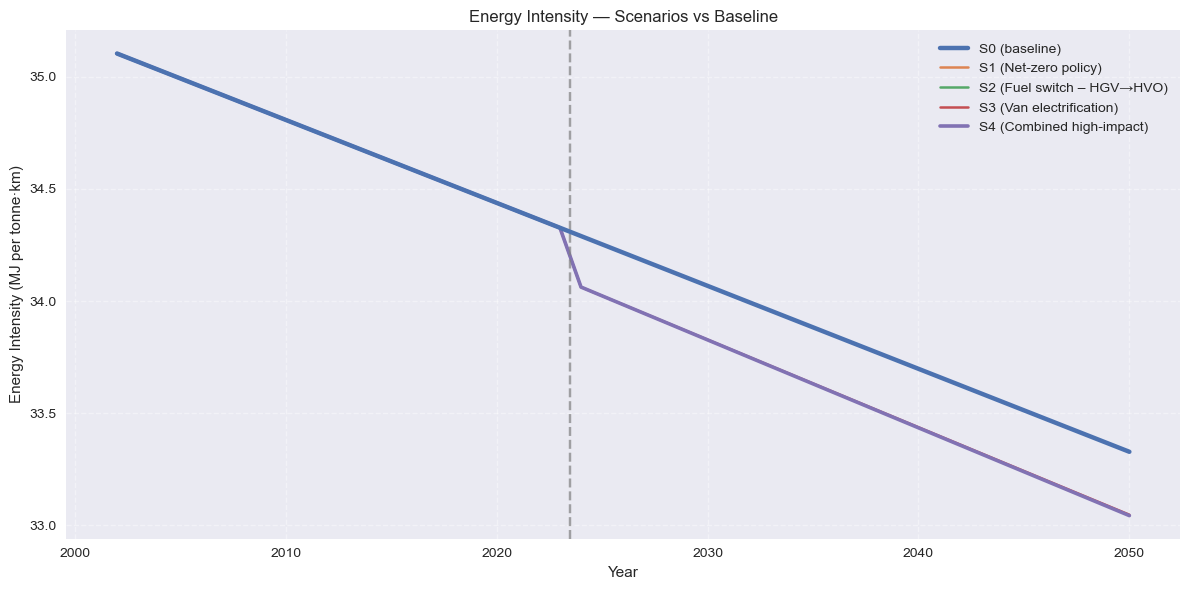

In [ ]:
# ============================================
# SC.7 — Scenario comparison (S0–S4)
# --------------------------------------------
# Purpose:
#   - Provides a single visual comparison of baseline (S0)
#     against scenarios S1–S4, for both:
#       • Emissions (ktCO₂e)
#       • Energy Intensity (MJ/t·km)
# Inputs:
#   - S0_emission_all, S1_emission_all, S2_emission_all,
#     S3_emission_all, S4_emission_all
#   - S0_EI, S1_EI, S2_EI, S3_EI, S4_EI
#   - years_hist (to split historical vs forecast)
# Method:
#   - Helper function plot_scenarios(series_dict, title, ylabel):
#       • Draws all input series on one plot with consistent formatting.
#       • Vertical dashed line marks history/forecast boundary.
#       • Styling:
#           – S0 baseline = thickest, top layer
#           – S4 combined = emphasized
#           – S1–S3 = thinner
#   - Two plots produced:
#       1. Total emissions (ktCO₂e) — scenarios vs baseline
#       2. Energy intensity (MJ/t·km) — scenarios vs baseline
# Outputs:
#   - Comparative plots only (no new data structures).
# ============================================

# guards
for v in ['S0_emission_all','S1_emission_all','S2_emission_all','S3_emission_all','S4_emission_all',
          'S0_EI','S1_EI','S2_EI','S3_EI','S4_EI','years_hist']:
    assert v in globals(), f"Missing {v}. Run scenarios S1–S4 first."

def plot_scenarios(series_dict, title, ylabel):
    split_x = years_hist.max() + 0.5  # vertical line between history & forecast
    plt.figure(figsize=(12,6))
    for name, ser in series_dict.items():
        if 'S0' in name:
            lw, ls, z = 3.2, '-', 3
        elif 'S4' in name:
            lw, ls, z = 2.6, '-', 2
        else:
            lw, ls, z = 1.8, '-', 1
        plt.plot(ser.index, ser.values, ls, label=name, linewidth=lw, zorder=z)
    plt.axvline(split_x, linestyle='--', color='gray', alpha=0.7)
    plt.title(title); plt.xlabel('Year'); plt.ylabel(ylabel)
    plt.grid(True, linestyle='--', alpha=0.4); plt.legend(); plt.tight_layout(); plt.show()
# ---- Emissions (ktCO2e)
plot_scenarios(
    {
        'S0 (baseline)': S0_emission_all,
        'S1 (Net-zero policy)': S1_emission_all,
        'S2 (Fuel switch – HGV→HVO)': S2_emission_all,
        'S3 (Van electrification)': S3_emission_all,
        'S4 (Combined high-impact)': S4_emission_all
    },
    'All Freight Emissions — Scenarios vs Baseline', 'Emissions (ktCO₂e)'
)
# ---- Energy Intensity (MJ/t·km)
plot_scenarios(
    {
        'S0 (baseline)': S0_EI,
        'S1 (Net-zero policy)': S1_EI,
        'S2 (Fuel switch – HGV→HVO)': S2_EI,
        'S3 (Van electrification)': S3_EI,
        'S4 (Combined high-impact)': S4_EI
    },
    'Energy Intensity — Scenarios vs Baseline', 'Energy Intensity (MJ per tonne·km)'
)


In [ ]:
# ============================================
# SC.8 — Scorecard: % reduction vs baseline (S0)
# --------------------------------------------
# Purpose:
#   - Provides a compact, tabular "scorecard" of
#     emissions and energy intensity (EI) reductions
#     for scenarios S1–S4 relative to baseline (S0).
#   - Key milestone years: 2030, 2040, 2050.
#
# Inputs:
#   - S0_emission_all, S1_emission_all … S4_emission_all
#   - S0_EI, S1_EI … S4_EI
#   - YEARS_SCORE = [2030, 2040, 2050]
#
# Method:
#   - Helper `scorecard()`:
#       • Compares scenario series vs baseline for given years.
#       • Outputs absolute baseline, absolute scenario, and
#         percentage reduction vs S0.
#   - Two multi-index tables produced:
#       1. em_table → Emissions scorecard (ktCO₂e)
#       2. ei_table → Energy Intensity scorecard (MJ/t·km)
#
# Outputs:
#   - em_table (displayed): reductions in total emissions
#   - ei_table (displayed): reductions in energy intensity
#   - Positive % = improvement (lower than baseline)
# ============================================

YEARS_SCORE = [2030, 2040, 2050]

def scorecard(scn_series, base_series, years=YEARS_SCORE, label='Scenario'):
    # keep only years that exist in both series
    yrs = [y for y in years if (y in scn_series.index) and (y in base_series.index)]
    df = pd.DataFrame(index=yrs, columns=['S0 (abs)', f'{label} (abs)', '% vs S0'], dtype=float)
    for y in yrs:
        b = float(base_series.loc[y])
        r = float(scn_series.loc[y])
        df.loc[y, 'S0 (abs)']      = b
        df.loc[y, f'{label} (abs)'] = r
        df.loc[y, '% vs S0']       = np.nan if b == 0 else (1 - r / b) * 100.0
    df.index.name = 'Year'
    return df

# --- Emissions scorecard ---
em_table = pd.concat([
    scorecard(S1_emission_all, S0_emission_all, label='S1 Emissions'),
    scorecard(S2_emission_all, S0_emission_all, label='S2 Emissions'),
    scorecard(S3_emission_all, S0_emission_all, label='S3 Emissions'),
    scorecard(S4_emission_all, S0_emission_all, label='S4 Emissions'),
], keys=['S1 (Emissions)','S2 (Emissions)','S3 (Emissions)','S4 (Emissions)'])

# --- EI scorecard ---
ei_table = pd.concat([
    scorecard(S1_EI, S0_EI, label='S1 EI'),
    scorecard(S2_EI, S0_EI, label='S2 EI'),
    scorecard(S3_EI, S0_EI, label='S3 EI'),
    scorecard(S4_EI, S0_EI, label='S4 EI'),
], keys=['S1 (EI)','S2 (EI)','S3 (EI)','S4 (EI)'])

# pretty print
print("=== Emissions reduction vs S0 (positive % is good) ===")
display(em_table.round({'S0 (abs)':0, 'S1 Emissions (abs)':0, 'S2 Emissions (abs)':0,
                        'S3 Emissions (abs)':0, 'S4 Emissions (abs)':0, '% vs S0':1}))

print("=== Energy Intensity reduction vs S0 (positive % is good) ===")
display(ei_table.round({'S0 (abs)':3, 'S1 EI (abs)':3, 'S2 EI (abs)':3,
                        'S3 EI (abs)':3, 'S4 EI (abs)':3, '% vs S0':2}))


=== Emissions reduction vs S0 (positive % is good) ===


S0 (abs)  S1 Emissions (abs)  % vs S0  \
               Year                                           
S1 (Emissions) 2030   330885.0            196848.0     40.5   
               2040   614216.0            110846.0     82.0   
               2050  1155302.0             24845.0     97.8   
S2 (Emissions) 2030   330885.0                 NaN      1.6   
               2040   614216.0                 NaN      4.7   
               2050  1155302.0                 NaN      4.7   
S3 (Emissions) 2030   330885.0                 NaN     13.7   
               2040   614216.0                 NaN     44.2   
               2050  1155302.0                 NaN     73.4   
S4 (Emissions) 2030   330885.0                 NaN     15.2   
               2040   614216.0                 NaN     48.8   
               2050  1155302.0                 NaN     78.0   

                     S2 Emissions (abs)  S3 Emissions (abs)  \
               Year                                           
S1 (Emissions) 2030                 NaN                 NaN   
               2040                 NaN                 NaN   
               2050                 NaN                 NaN   
S2 (Emissions) 2030            325751.0                 NaN   
               2040            585629.0                 NaN   
               2050           1101531.0                 NaN   
S3 (Emissions) 2030                 NaN            285670.0   
               2040                 NaN            342956.0   
               2050                 NaN            307654.0   
S4 (Emissions) 2030                 NaN                 NaN   
               2040                 NaN                 NaN   
               2050                 NaN                 NaN   

                     S4 Emissions (abs)  
               Year                      
S1 (Emissions) 2030                 NaN  
               2040                 NaN  
               2050                 NaN  
S2 (Emissions) 2030                 NaN  
               2040                 NaN  
               2050                 NaN  
S3 (Emissions) 2030                 NaN  
               2040                 NaN  
               2050                 NaN  
S4 (Emissions) 2030            280537.0  
               2040            314368.0  
               2050            253883.0

=== Energy Intensity reduction vs S0 (positive % is good) ===


S0 (abs)  S1 EI (abs)  % vs S0  S2 EI (abs)  S3 EI (abs)  \
        Year                                                             
S1 (EI) 2030    34.068       34.068     0.00          NaN          NaN   
        2040    33.698       33.698     0.00          NaN          NaN   
        2050    33.328       33.328     0.00          NaN          NaN   
S2 (EI) 2030    34.068          NaN     0.00       34.068          NaN   
        2040    33.698          NaN     0.00       33.698          NaN   
        2050    33.328          NaN     0.00       33.328          NaN   
S3 (EI) 2030    34.068          NaN     0.70          NaN       33.828   
        2040    33.698          NaN     0.77          NaN       33.438   
        2050    33.328          NaN     0.84          NaN       33.048   
S4 (EI) 2030    34.068          NaN     0.71          NaN          NaN   
        2040    33.698          NaN     0.78          NaN          NaN   
        2050    33.328          NaN     0.85          NaN          NaN   

              S4 EI (abs)  
        Year               
S1 (EI) 2030          NaN  
        2040          NaN  
        2050          NaN  
S2 (EI) 2030          NaN  
        2040          NaN  
        2050          NaN  
S3 (EI) 2030          NaN  
        2040          NaN  
        2050          NaN  
S4 (EI) 2030       33.827  
        2040       33.435  
        2050       33.044

PowerBI

In [101]:
# ============================================
# PB.1 — Power BI Exports (S0–S4, 2002–2050)
# --------------------------------------------
# Purpose:
#   - Prepares scenario outputs (S0–S4) in a tidy format
#     for Power BI dashboarding.
#   - Exports three CSVs covering totals, group-level
#     series, and adoption paths.
#
# Inputs:
#   - Totals: S0..S4_emission_all, S0..S4_EI
#   - Groups: S0..S4_emis_by_grp, S0..S4_ei_by_grp
#   - Adoption: adopt, adopt_van, red_van (if defined)
#   - Metadata: groups=['HGV','Vans','Ships'], years 2002–2050
#
# Method:
#   1. Totals table (`dashboard_totals`):
#        • Scenario, Year, Metric, Value
#        • % Reduction vs S0 (baseline)
#   2. By-group table (`dashboard_bygroup`):
#        • Scenario, Group, Year, Metric, Value
#        • % Reduction vs S0 (within group)
#   3. Adoption paths (`adoption_paths`):
#        • Yearly adoption of HVO (HGV), BEV (vans),
#          and WTW reduction curve for vans
#   4. Exports all three tables to CSV for direct
#      ingestion into Power BI slicers/visuals.
#
# Outputs (CSV):
#   • dashboard_totals_S0_S4.csv
#   • dashboard_by_group_S0_S4.csv
#   • adoption_paths.csv
#
# Notes:
#   - S1/S2 group series default to scaled S0 unless
#     explicitly built earlier.
#   - EI for S1/S2 unchanged from S0 (drop-in).
#   - S3/S4 group-level EI already calculated in SC.5/SC.7.
# ============================================


# ---- guards ----
req_tot = ['S0_emission_all','S1_emission_all','S2_emission_all','S3_emission_all','S4_emission_all',
           'S0_EI','S1_EI','S2_EI','S3_EI','S4_EI']
for v in req_tot: assert v in globals(), f"Missing {v}. Run S0–S4 cells first."

# ensure per-group series exist for all scenarios
groups = ['HGV','Vans','Ships']
assert 'S0_emis_by_grp' in globals(), "Missing S0_emis_by_grp (from SC.1/SC.0)."
if 'S1_emis_by_grp' not in globals():
    # scale S0 per-group by S1/S0 total ratio
    scale_ratio = (S1_emission_all / S0_emission_all).replace([np.inf,-np.inf], np.nan).fillna(1.0)
    S1_emis_by_grp = S0_emis_by_grp.mul(scale_ratio, axis=0)
if 'S2_emis_by_grp' not in globals():
    scale_ratio = (S2_emission_all / S0_emission_all).replace([np.inf,-np.inf], np.nan).fillna(1.0)
    S2_emis_by_grp = S0_emis_by_grp.mul(scale_ratio, axis=0)
assert 'S3_emis_by_grp' in globals(), "Missing S3_emis_by_grp (from SC.5)."
assert 'S4_emis_by_grp' in globals(), "Missing S4_emis_by_grp (from SC.7)."

# EI per-group (S1/S2 unchanged from S0; S3/S4 already built)
if 'S0_ei_by_grp' not in globals():
    raise AssertionError("Missing S0_ei_by_grp (from SC.1).")
if 'S1_ei_by_grp' not in globals(): S1_ei_by_grp = S0_ei_by_grp.copy()
if 'S2_ei_by_grp' not in globals(): S2_ei_by_grp = S0_ei_by_grp.copy()
assert 'S3_ei_by_grp' in globals(), "Missing S3_ei_by_grp (from SC.5)."
assert 'S4_EI_by_grp' in globals(), "Missing S4_EI_by_grp (from SC.7)."

# ---------- Totals table (tidy) ----------
tot_emis = {
    'S0 (baseline)': S0_emission_all, 'S1 (Net-zero policy)': S1_emission_all,
    'S2 (Fuel switch – HGV→HVO)': S2_emission_all, 'S3 (Van electrification)': S3_emission_all,
    'S4 (Combined high-impact)': S4_emission_all
}
tot_ei = {
    'S0 (baseline)': S0_EI, 'S1 (Net-zero policy)': S1_EI,
    'S2 (Fuel switch – HGV→HVO)': S2_EI, 'S3 (Van electrification)': S3_EI,
    'S4 (Combined high-impact)': S4_EI
}

def make_totals_table(tot_emis, tot_ei):
    rows = []
    for scn, ser in tot_emis.items():
        base = S0_emission_all.reindex(ser.index)
        pct = np.where(base.values==0, np.nan, (1 - ser.values/base.values)*100.0)
        rows.append(pd.DataFrame({
            'Year': ser.index, 'Scenario': scn,
            'Metric': 'Emissions (ktCO2e)', 'Value': ser.values,
            '% Reduction vs S0': pct
        }))
    for scn, ser in tot_ei.items():
        base = S0_EI.reindex(ser.index)
        pct = np.where(base.values==0, np.nan, (1 - ser.values/base.values)*100.0)
        rows.append(pd.DataFrame({
            'Year': ser.index, 'Scenario': scn,
            'Metric': 'Energy Intensity (MJ/t·km)', 'Value': ser.values,
            '% Reduction vs S0': pct
        }))
    out = pd.concat(rows, ignore_index=True)
    return out.sort_values(['Metric','Scenario','Year'])

dashboard_totals = make_totals_table(tot_emis, tot_ei)

# ---------- By-group table (tidy) ----------
bygrp_emis = {
    'S0 (baseline)': S0_emis_by_grp, 'S1 (Net-zero policy)': S1_emis_by_grp,
    'S2 (Fuel switch – HGV→HVO)': S2_emis_by_grp, 'S3 (Van electrification)': S3_emis_by_grp,
    'S4 (Combined high-impact)': S4_emis_by_grp
}
bygrp_ei = {
    'S0 (baseline)': S0_ei_by_grp, 'S1 (Net-zero policy)': S1_ei_by_grp,
    'S2 (Fuel switch – HGV→HVO)': S2_ei_by_grp, 'S3 (Van electrification)': S3_ei_by_grp,
    'S4 (Combined high-impact)': S4_EI_by_grp
}

def make_bygroup_table(bygrp_emis, bygrp_ei):
    rows = []
    # emissions
    for scn, df_grp in bygrp_emis.items():
        base = bygrp_emis['S0 (baseline)'].reindex(df_grp.index)
        for g in groups:
            ser = df_grp[g].rename('Value')
            base_g = base[g]
            pct = np.where(base_g.values==0, np.nan, (1 - ser.values/base_g.values)*100.0)
            rows.append(pd.DataFrame({
                'Year': df_grp.index, 'Scenario': scn, 'Group': g,
                'Metric': 'Emissions (ktCO2e)', 'Value': ser.values,
                '% Reduction vs S0 (group)': pct
            }))
    # EI (per-group)
    for scn, df_grp in bygrp_ei.items():
        base = bygrp_ei['S0 (baseline)'].reindex(df_grp.index)
        for g in groups:
            ser = df_grp[g].rename('Value')
            base_g = base[g]
            pct = np.where(base_g.values==0, np.nan, (1 - ser.values/base_g.values)*100.0)
            rows.append(pd.DataFrame({
                'Year': df_grp.index, 'Scenario': scn, 'Group': g,
                'Metric': 'Energy Intensity (MJ/t·km)', 'Value': ser.values,
                '% Reduction vs S0 (group)': pct
            }))
    out = pd.concat(rows, ignore_index=True)
    return out.sort_values(['Group','Metric','Scenario','Year'])

dashboard_bygroup = make_bygroup_table(bygrp_emis, bygrp_ei)

# ---------- Adoption paths (for slicers / annotations) ----------
adopt_HGV  = adopt.reindex(S0_emission_all.index).fillna(0.0) if 'adopt' in globals() else pd.Series(dtype=float)
adopt_VANS = adopt_van.reindex(S0_emission_all.index).fillna(0.0) if 'adopt_van' in globals() else pd.Series(dtype=float)
red_VANS   = red_van.reindex(S0_emission_all.index).fillna(0.0) if 'red_van' in globals() else pd.Series(dtype=float)

adoption_paths = pd.DataFrame({
    'Year': S0_emission_all.index,
    'HGV_HVO_Adoption (S2)': adopt_HGV.values if len(adopt_HGV)>0 else np.nan,
    'Vans_BEV_Adoption (S3)': adopt_VANS.values if len(adopt_VANS)>0 else np.nan,
    'Vans_WTW_Reduction (S3)': red_VANS.values if len(red_VANS)>0 else np.nan
})

# ---------- Save CSVs ----------
dashboard_totals.to_csv('dashboard_totals_S0_S4.csv', index=False)
dashboard_bygroup.to_csv('dashboard_by_group_S0_S4.csv', index=False)
adoption_paths.to_csv('adoption_paths.csv', index=False)

print("✅ Saved:")
print(" - dashboard_totals_S0_S4.csv")
print(" - dashboard_by_group_S0_S4.csv")
print(" - adoption_paths.csv")

# Optional: peek at heads
display(dashboard_totals.head(8))
display(dashboard_bygroup.head(8))
display(adoption_paths.head())


✅ Saved:
 - dashboard_totals_S0_S4.csv
 - dashboard_by_group_S0_S4.csv
 - adoption_paths.csv


,Year,Scenario,Metric,Value,% Reduction vs S0
0,2002,S0 (baseline),Emissions (ktCO2e),168936.367866,0.0
1,2003,S0 (baseline),Emissions (ktCO2e),173170.872225,0.0
2,2004,S0 (baseline),Emissions (ktCO2e),176766.822530,0.0
3,2005,S0 (baseline),Emissions (ktCO2e),179811.140536,0.0
4,2006,S0 (baseline),Emissions (ktCO2e),182390.748000,0.0
5,2007,S0 (baseline),Emissions (ktCO2e),184592.566677,0.0
6,2008,S0 (baseline),Emissions (ktCO2e),186503.518323,0.0
7,2009,S0 (baseline),Emissions (ktCO2e),188210.524693,0.0


,Year,Scenario,Group,Metric,Value,% Reduction vs S0 (group)
0,2002,S0 (baseline),HGV,Emissions (ktCO2e),18268.0,0.0
1,2003,S0 (baseline),HGV,Emissions (ktCO2e),18400.0,0.0
2,2004,S0 (baseline),HGV,Emissions (ktCO2e),18528.0,0.0
3,2005,S0 (baseline),HGV,Emissions (ktCO2e),18420.0,0.0
4,2006,S0 (baseline),HGV,Emissions (ktCO2e),18369.0,0.0
5,2007,S0 (baseline),HGV,Emissions (ktCO2e),18230.0,0.0
6,2008,S0 (baseline),HGV,Emissions (ktCO2e),17850.0,0.0
7,2009,S0 (baseline),HGV,Emissions (ktCO2e),15875.0,0.0


,Year,HGV_HVO_Adoption (S2),Vans_BEV_Adoption (S3),Vans_WTW_Reduction (S3)
0,2002,0.0,0.0,0.0
1,2003,0.0,0.0,0.0
2,2004,0.0,0.0,0.0
3,2005,0.0,0.0,0.0
4,2006,0.0,0.0,0.0


In [102]:
# ============================================
# PB.2 — Sensitivity (±10%) for 2050 Emissions (S0–S4)
# --------------------------------------------
# Purpose:
#   - Stress-tests scenario results by varying key levers ±10%
#     to check robustness of 2050 forecasts.
#   - Outputs a tidy CSV for sensitivity dashboards / tables.
#
# Inputs:
#   • Baselines: S0..S4_emission_all, S0_emis_by_grp
#   • Parameters: assumed_reduction, adopt, adopt_van, red_van
#   • Horizon: years_fut, target year = 2050
#
# Method:
#   - Recompute emissions under ±10% shifts:
#       S1 → Net-zero target fraction
#       S2 → HGV reduction factor & adoption
#       S3 → Vans BEV adoption & WTW reduction
#       S4 → Combined HGV + Vans levers
#   - Clamp adoption/reduction to [0,1] for realism.
#   - Compare each shifted run against its scenario base.
#
# Outputs:
#   • sensitivity_2050_S0_S4.csv
#       Columns:
#         Scenario, Lever, Shift
#         Emissions_2050_ktCO2e
#         Δ_vs_Base_kt
#         %_Change_vs_Base
#
# Notes:
#   - S0 included as a fixed baseline (no sensitivity).
#   - Helps identify which levers most affect long-term
#     decarbonisation outcomes.
# ============================================


import numpy as np
import pandas as pd

# ---- guards ----
need = ['S0_emission_all','S1_emission_all','S2_emission_all','S3_emission_all','S4_emission_all',
        'S0_emis_by_grp','assumed_reduction','adopt','adopt_van','red_van','years_fut']
for v in need:
    assert v in globals(), f"Missing {v}. Run S0–S4 first (missing {v})."

Y2050 = 2050

# ---------- helper recomputes (return TOTAL series; we only read 2050) ----------
def s1_recompute(target_frac_scale=1.0):
    """Linear to (0.10 * scale) of 2024 S0 by 2050; EI unchanged (not needed here)."""
    y0_2024 = float(S0_emission_all.loc[2024])
    frac = 0.10 * target_frac_scale
    tgt = frac * y0_2024
    out = S0_emission_all.copy()
    out.loc[years_fut] = np.linspace(y0_2024, tgt, len(years_fut))
    return out

def s2_recompute(hgv_red_scale=1.0, adopt_scale=1.0):
    """HGV→HVO on top of S0 group paths."""
    red = float(assumed_reduction['HGV']) * hgv_red_scale
    red = max(0.0, min(1.0, red))
    adp = adopt.reindex(S0_emis_by_grp.index).fillna(0.0) * adopt_scale
    adp = adp.clip(0.0, 1.0)

    out_by_grp = S0_emis_by_grp.copy()
    factor = 1.0 - adp * red
    out_by_grp['HGV'] = S0_emis_by_grp['HGV'] * factor.values
    return out_by_grp.sum(axis=1)

def s3_recompute(vans_adopt_scale=1.0, vans_red_scale=1.0):
    """Vans electrification (emissions use adoption * WTW reduction only)."""
    adp_v = adopt_van.reindex(S0_emis_by_grp.index).fillna(0.0) * vans_adopt_scale
    adp_v = adp_v.clip(0.0, 1.0)
    red_v = red_van.reindex(S0_emis_by_grp.index).fillna(0.0) * vans_red_scale
    red_v = red_v.clip(0.0, 1.0)

    out_by_grp = S0_emis_by_grp.copy()
    out_by_grp['Vans'] = S0_emis_by_grp['Vans'] * (1.0 - adp_v * red_v)
    return out_by_grp.sum(axis=1)

def s4_recompute(hgv_red_scale=1.0, hgv_adopt_scale=1.0,
                 vans_adopt_scale=1.0, vans_red_scale=1.0):
    """Combined S2 + S3 simultaneously."""
    # HGV part
    red_h = float(assumed_reduction['HGV']) * hgv_red_scale
    red_h = max(0.0, min(1.0, red_h))
    adp_h = adopt.reindex(S0_emis_by_grp.index).fillna(0.0) * hgv_adopt_scale
    adp_h = adp_h.clip(0.0, 1.0)
    # Vans part
    adp_v = adopt_van.reindex(S0_emis_by_grp.index).fillna(0.0) * vans_adopt_scale
    adp_v = adp_v.clip(0.0, 1.0)
    red_v = red_van.reindex(S0_emis_by_grp.index).fillna(0.0) * vans_red_scale
    red_v = red_v.clip(0.0, 1.0)

    out_by_grp = S0_emis_by_grp.copy()
    out_by_grp['HGV']  = S0_emis_by_grp['HGV']  * (1.0 - adp_h * red_h)
    out_by_grp['Vans'] = S0_emis_by_grp['Vans'] * (1.0 - adp_v * red_v)
    # Ships unchanged
    return out_by_grp.sum(axis=1)

# ---------- base values (2050) ----------
base_vals = {
    'S0': float(S0_emission_all.loc[Y2050]),
    'S1': float(S1_emission_all.loc[Y2050]),
    'S2': float(S2_emission_all.loc[Y2050]),
    'S3': float(S3_emission_all.loc[Y2050]),
    'S4': float(S4_emission_all.loc[Y2050]),
}

# ---------- run ±10% shifts per lever ----------
rows = []

def add_row(scn, lever, shift_label, val, base):
    rows.append({
        'Scenario': scn,
        'Lever': lever,
        'Shift': shift_label,
        'Emissions_2050_ktCO2e': val,
        'Δ_vs_Base_kt': val - base,
        '%_Change_vs_Base': (np.nan if base == 0 else (val/base - 1.0) * 100.0)
    })

# S0 — no sensitivity levers (baseline)
add_row('S0', '—', 'Base', base_vals['S0'], base_vals['S0'])

# S1 — target fraction ±10%
for scale, lab in [(0.9, '-10% target'), (1.1, '+10% target')]:
    v = float(s1_recompute(target_frac_scale=scale).loc[Y2050])
    add_row('S1', 'Target2050Fraction', lab, v, base_vals['S1'])
add_row('S1', 'Target2050Fraction', 'Base', base_vals['S1'], base_vals['S1'])

# S2 — HGV reduction & adoption ±10% (separately)
for scale, lab in [(0.9, '-10% red'), (1.1, '+10% red')]:
    v = float(s2_recompute(hgv_red_scale=scale, adopt_scale=1.0).loc[Y2050])
    add_row('S2', 'HGV_Reduction', lab, v, base_vals['S2'])
for scale, lab in [(0.9, '-10% adopt'), (1.1, '+10% adopt')]:
    v = float(s2_recompute(hgv_red_scale=1.0, adopt_scale=scale).loc[Y2050])
    add_row('S2', 'HGV_Adoption', lab, v, base_vals['S2'])
add_row('S2', '—', 'Base', base_vals['S2'], base_vals['S2'])

# S3 — Vans adoption & WTW reduction ±10% (separately)
for scale, lab in [(0.9, '-10% adopt'), (1.1, '+10% adopt')]:
    v = float(s3_recompute(vans_adopt_scale=scale, vans_red_scale=1.0).loc[Y2050])
    add_row('S3', 'Vans_Adoption', lab, v, base_vals['S3'])
for scale, lab in [(0.9, '-10% WTW'), (1.1, '+10% WTW')]:
    v = float(s3_recompute(vans_adopt_scale=1.0, vans_red_scale=scale).loc[Y2050])
    add_row('S3', 'Vans_WTW_Reduction', lab, v, base_vals['S3'])
add_row('S3', '—', 'Base', base_vals['S3'], base_vals['S3'])

# S4 — combined: scale BOTH HGV & Vans levers together ±10%
for scale, lab in [(0.9, '-10% all levers'), (1.1, '+10% all levers')]:
    v = float(s4_recompute(hgv_red_scale=scale, hgv_adopt_scale=scale,
                           vans_adopt_scale=scale, vans_red_scale=scale).loc[Y2050])
    add_row('S4', 'All_Levers', lab, v, base_vals['S4'])
add_row('S4', 'All_Levers', 'Base', base_vals['S4'], base_vals['S4'])

# ---------- compile & export ----------
sens_2050 = pd.DataFrame(rows)[[
    'Scenario','Lever','Shift','Emissions_2050_ktCO2e','Δ_vs_Base_kt','%_Change_vs_Base'
]].sort_values(['Scenario','Lever','Shift'])

sens_2050.to_csv('sensitivity_2050_S0_S4.csv', index=False)
print("✅ Saved: sensitivity_2050_S0_S4.csv")
display(sens_2050)


✅ Saved: sensitivity_2050_S0_S4.csv


,Scenario,Lever,Shift,Emissions_2050_ktCO2e,Δ_vs_Base_kt,%_Change_vs_Base
0,S0,—,Base,1.155302e+06,0.000000,0.000000
2,S1,Target2050Fraction,+10% target,2.732939e+04,2484.489811,10.000000
1,S1,Target2050Fraction,-10% target,2.236041e+04,-2484.489811,-10.000000
3,S1,Target2050Fraction,Base,2.484490e+04,0.000000,0.000000
7,S2,HGV_Adoption,+10% adopt,1.096154e+06,-5377.111026,-0.488149
6,S2,HGV_Adoption,-10% adopt,1.106908e+06,5377.111026,0.488149
5,S2,HGV_Reduction,+10% red,1.096154e+06,-5377.111026,-0.488149
4,S2,HGV_Reduction,-10% red,1.106908e+06,5377.111026,0.488149
8,S2,—,Base,1.101531e+06,0.000000,0.000000
10,S3,Vans_Adoption,+10% adopt,3.076539e+05,0.000000,0.000000
